# CODEX analyses

## Imports and data loading

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time
import warnings
import joblib
# from pathlib3x import Path
from pathlib import Path
from time import time
from tqdm import tqdm
import copy
from skimage import color
import matplotlib as mpl
import napari
import colorcet as cc
import composition_stats as cs

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import umap
# if not installed run: conda install -c conda-forge umap-learn
import hdbscan
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
import sklearn.metrics as metrics
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import loguniform

from skimage import io

from scipy.stats import ttest_ind    # Welch's t-test
from scipy.stats import mannwhitneyu # Mann-Whitney rank test
from scipy.stats import ks_2samp     # Kolmogorov-Smirnov statistic

from tysserand import tysserand as ty
from mosna import mosna

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'white'
mpl.rcParams["axes.facecolor"] = 'white'
mpl.rcParams["savefig.facecolor"] = 'white'

In [100]:
# If need to reload modules after their modification
from importlib import reload
ty = reload(ty)
mosna = reload(mosna)

In [101]:
RUN_LONG = False

### Objects data

File that contains all the detected objects (the cells) across all samples.

In [102]:
data_dir = Path("../data/raw/CODEX_CTCL")
try:
    objects_path = data_dir / "41467_2021_26974_MOESM3_ESM_-_Objects.jbl"
    obj = joblib.load(objects_path)
except FileNotFoundError:
    objects_path = data_dir / "41467_2021_26974_MOESM3_ESM_-_Objects.xlsx"
    obj = pd.read_excel(objects_path, skiprows=2)
obj

Count  EventCount  Index in File  ClusterID FileName  ClusterName  \
0            0           1             60      33987   reg001      B cells   
1            1           1             94      33987   reg001      B cells   
2            2           1            198      33987   reg001      B cells   
3            3           1            284      33987   reg001      B cells   
4            4           1            298      33987   reg001      B cells   
...        ...         ...            ...        ...      ...          ...   
117165  116917           1            633      33981   reg066  vasculature   
117166  116918           1            677      33981   reg066  vasculature   
117167  116919           1            681      33981   reg066  vasculature   
117168  116920           1            705      33981   reg066  vasculature   
117169  116921           1            711      33981   reg066  vasculature   

        Spots  Patients  Groups      FOXP3  ...  PD-1+CD8+  CD4+Tcells  \
0           1         1       1   0.692403  ...          0           0   
1           1         1       1   8.094747  ...          0           0   
2           1         1       1   4.110389  ...          0           0   
3           1         1       1   0.000000  ...          0           0   
4           1         1       1   2.937673  ...          0           0   
...       ...       ...     ...        ...  ...        ...         ...   
117165     66        14       4  84.269714  ...          0           0   
117166     66        14       4  56.425945  ...          0           0   
117167     66        14       4  63.152092  ...          0           0   
117168     66        14       4  66.873306  ...          0           0   
117169     66        14       4  17.966373  ...          0           0   

        PD-1+tumor  CD8+Tcells  Ki67+CD4+  Ki-67+Tregs  ICOS+Tregs  IDO+Tregs  \
0                0           0          0            0           0          0   
1                0           0          0            0           0          0   
2                0           0          0            0           0          0   
3                0           0          0            0           0          0   
4                0           0          0            0           0          0   
...            ...         ...        ...          ...         ...        ...   
117165           0           0          0            0           0          0   
117166           0           0          0            0           0          0   
117167           0           0          0            0           0          0   
117168           0           0          0            0           0          0   
117169           0           0          0            0           0          0   

        Ki67+tumor  original_index  
0                0               0  
1                0               1  
2                0               2  
3                0               3  
4                0               4  
...            ...             ...  
117165           0          116917  
117166           0          116918  
117167           0          116919  
117168           0          116920  
117169           0          116921  

[117170 rows x 121 columns]

In [103]:
# sample_cols = obj.columns[:10]
obj.rename(columns={'X': 'x', 'Y': 'y', 'Z':'z'}, inplace=True)
sample_cols = ['FileName', 'ClusterName', 'Patients', 'Spots' ,'Groups']
marker_cols = obj.columns[9:67]
marker_cols = [x for x in marker_cols if x != 'HOECHST1:Cyc_1_ch_1']
# cell_pos_cols = obj.columns[69:76]
cell_pos_cols = ['x', 'y'] # no z this time ! 
# cell_type_cols = obj.columns[76:101]
cell_type_cols = list(obj.columns[75:96])
marker_posit_cols = list(obj.columns[100:-1])
all_cols = sample_cols + marker_cols + cell_pos_cols + cell_type_cols + marker_posit_cols
nb_clusters = obj['ClusterName'].unique().size

In [104]:
obj.shape

(117170, 121)

In [105]:
# Select only pre-treatment samples
obj = obj.loc[obj['Groups'] < 3, :]
obj.index = np.arange(len(obj))
obj['Groups'].unique()

array([1, 2])

In [106]:
# some debuging...
obj.loc[obj["FileName"] == 'reg040', :]

Count  EventCount  Index in File  ClusterID FileName   ClusterName  \
46        567           1            265      33987   reg040       B cells   
47        568           1            560      33987   reg040       B cells   
48        569           1           1087      33987   reg040       B cells   
434      3040           1            449      33988   reg040  CD4+ T cells   
435      3043           1            880      33988   reg040  CD4+ T cells   
...       ...         ...            ...        ...      ...           ...   
36663  114847           1           1297      33981   reg040   vasculature   
36664  114848           1           1302      33981   reg040   vasculature   
36665  114849           1           1303      33981   reg040   vasculature   
36666  114850           1           1304      33981   reg040   vasculature   
36667  114851           1           1318      33981   reg040   vasculature   

       Spots  Patients  Groups       FOXP3  ...  PD-1+CD8+  CD4+Tcells  \
46        40        10       1  105.316605  ...          0           0   
47        40        10       1   41.249653  ...          0           0   
48        40        10       1   42.894711  ...          0           0   
434       40        10       1  146.861786  ...          0           1   
435       40        10       1   98.519394  ...          0           1   
...      ...       ...     ...         ...  ...        ...         ...   
36663     40        10       1  126.448128  ...          0           0   
36664     40        10       1   60.009136  ...          0           0   
36665     40        10       1    7.867873  ...          0           0   
36666     40        10       1   25.090118  ...          0           0   
36667     40        10       1   33.617397  ...          0           0   

       PD-1+tumor  CD8+Tcells  Ki67+CD4+  Ki-67+Tregs  ICOS+Tregs  IDO+Tregs  \
46              0           0          0            0           0          0   
47              0           0          0            0           0          0   
48              0           0          0            0           0          0   
434             0           0          0            0           0          0   
435             0           0          0            0           0          0   
...           ...         ...        ...          ...         ...        ...   
36663           0           0          0            0           0          0   
36664           0           0          0            0           0          0   
36665           0           0          0            0           0          0   
36666           0           0          0            0           0          0   
36667           0           0          0            0           0          0   

       Ki67+tumor  original_index  
46              0             567  
47              0             568  
48              0             569  
434             0            3040  
435             0            3043  
...           ...             ...  
36663           0          114847  
36664           0          114848  
36665           0          114849  
36666           0          114850  
36667           0          114851  

[1317 rows x 121 columns]

In [107]:
pd.set_option('display.max_rows', 500)
obj[['FileName', 'Patients', 'Groups', 'Count']].groupby(['Patients', 'Groups', 'FileName']).count()

Count
Patients Groups FileName       
1        1      reg001     1301
                reg002     2324
2        1      reg005      112
                reg006      603
3        2      reg009     2334
                reg010     1970
4        2      reg013     1765
                reg014     1270
5        1      reg017      558
                reg018      458
6        2      reg021     2483
                reg022     2325
7        2      reg025      144
                reg026      257
8        2      reg029     1916
                reg030     1909
                reg031     1102
9        1      reg035     2053
                reg036      618
10       1      reg039     1225
                reg040     1317
11       1      reg041     1105
                reg042      385
12       2      reg045     1914
                reg046      808
13       1      reg051     1082
                reg052     1707
14       2      reg057     1166
                reg058     1854

In [108]:
pd.set_option('display.max_rows', 10)

### Response status pre/post treatment

In [109]:
code_groups = {
  1: 'Responder, pre-treatment',
  2: 'Non-responder, pre-treatment',
  3: 'Responder, post-treatment',
  4: 'Non-responder, post-treatment',
} 

In [110]:
status_path = data_dir / "41467_2021_26974_MOESM5_ESM - Patients_spots_conditons.xlsx"
status = pd.read_excel(status_path, skiprows=2, usecols=['Patients', 'Groups', 'Spots'])
# samples 25, 36, 37, 40, 44 are missing
# 36 and 37 should be patient 9
# 40 is either 10 or 11
# 44 is 11, which make 4 samples of this patient
# so probably 40 is patient 10

# # /!\ this is a guess that makes sense, but it still might be wrong /!\
# guessed_data = [[9, 1, 36],
#                 [9, 3, 37],
#                 [10, 3, 40],
#                 [11, 3, 44],
#                 ]
# status = pd.concat([status, pd.DataFrame(guessed_data, columns=status.columns)], axis=0)

status['FileName'] = status['Spots'].apply(lambda x: f'reg{x:03}')
# pd.set_option('display.max_rows', 100)

if 'FileName' in status.columns:
    status.index = status['FileName']
    status.drop(columns=['FileName'], inplace=True)
    status.index.name = 'id'
status.sort_values('Spots')

Patients  Groups  Spots
id                             
reg001         1       1      1
reg002         1       1      2
reg003         1       3      3
reg004         1       3      4
reg006         2       1      6
...          ...     ...    ...
reg066        14       4     66
reg067         9       3     67
reg068         9       3     68
reg069        13       3     69
reg070        13       3     70

[64 rows x 3 columns]

In [111]:
# Status has too many missing values
# we make a status dataframe from the objects dataframe
status = obj[['FileName', 'Patients', 'Groups', 'Count']].groupby(['Patients', 'Groups', 'FileName']).count().reset_index()
status.drop(columns=['Count'], inplace=True)
if 'FileName' in status.columns:
    status.index = status['FileName']
    status.drop(columns=['FileName'], inplace=True)
    status.index.name = 'id'
status['Spots'] = [int(x[-2:]) for x in status.index]
status

Patients  Groups  Spots
id                             
reg001         1       1      1
reg002         1       1      2
reg005         2       1      5
reg006         2       1      6
reg009         3       2      9
...          ...     ...    ...
reg046        12       2     46
reg051        13       1     51
reg052        13       1     52
reg057        14       2     57
reg058        14       2     58

[29 rows x 3 columns]

### Survival data

In [112]:
survival_path = data_dir / "cohort_response.ods"
surv = pd.read_excel(survival_path)
surv.index = surv['Patient ID']
surv.drop(columns=['Patient ID'], inplace=True)
# surv.index.name = 'sample'
surv

Age at screening (years)  Gender Diagnosis Disease Stage  \
Patient ID                                                             
1                              76.14    Male        MF          IIIA   
2                              60.59    Male        MF          IIIB   
3                              52.01    Male        SS           IVA   
4                              85.14  Female        SS           IVA   
5                              75.24    Male        MF           IIB   
...                              ...     ...       ...           ...   
10                             66.40    Male        MF          IIIA   
11                             72.23    Male        SS           IVA   
12                             72.59    Male        SS           IVA   
13                             44.10  Female        SS           IVA   
14                             63.69    Male        MF            IB   

            Prior therapies Response status        Biopsy timepoints  \
Patient ID                                                             
1                         3       Responder                 Pre, EOT   
2                         4       Responder                 Pre, EOT   
3                         3   Non-responder                 Pre, EOT   
4                         4   Non-responder                 Pre, EOT   
5                         6       Responder                 Pre, EOT   
...                     ...             ...                      ...   
10                        2       Responder                      Pre   
11                        3       Responder            Pre, Response   
12                        5   Non-responder         Pre, Progression   
13                        1       Responder  Pre, CO2, Response, EOT   
14                        5   Non-responder  Pre, CO2, Response, EOT   

            CO2 (weeks)  Response / progression time (weeks)  \
Patient ID                                                     
1                   NaN                                  NaN   
2                   NaN                                  NaN   
3                   NaN                                  NaN   
4                   NaN                                  NaN   
5                   NaN                                  NaN   
...                 ...                                  ...   
10                  NaN                                  NaN   
11                  NaN                                 22.0   
12                  NaN                                 15.0   
13                  3.0                                 15.0   
14                  3.0                                 10.0   

            EOT time (weeks)  Death time (weeks)  Follow-up time (weeks)  
Patient ID                                                                
1                      104.0                 NaN                     142  
2                      104.0                 NaN                     151  
3                       98.0                98.0                      98  
4                      104.0               142.0                     142  
5                      104.0                 NaN                     103  
...                      ...                 ...                     ...  
10                       NaN               119.0                     119  
11                     104.0                 NaN                     171  
12                      15.0                 NaN                      15  
13                     104.0                 NaN                     179  
14                      92.0                92.0                      92  

[14 rows x 12 columns]

## Spatial networks reconstruction

### Load samples of one patient

We will have a look at the spatial networks of the 4 samples of the first patient to check they seem "correct", i.e. not over nor under connected.

processing filename reg001
processing filename reg002
processing filename reg003
processing filename reg004


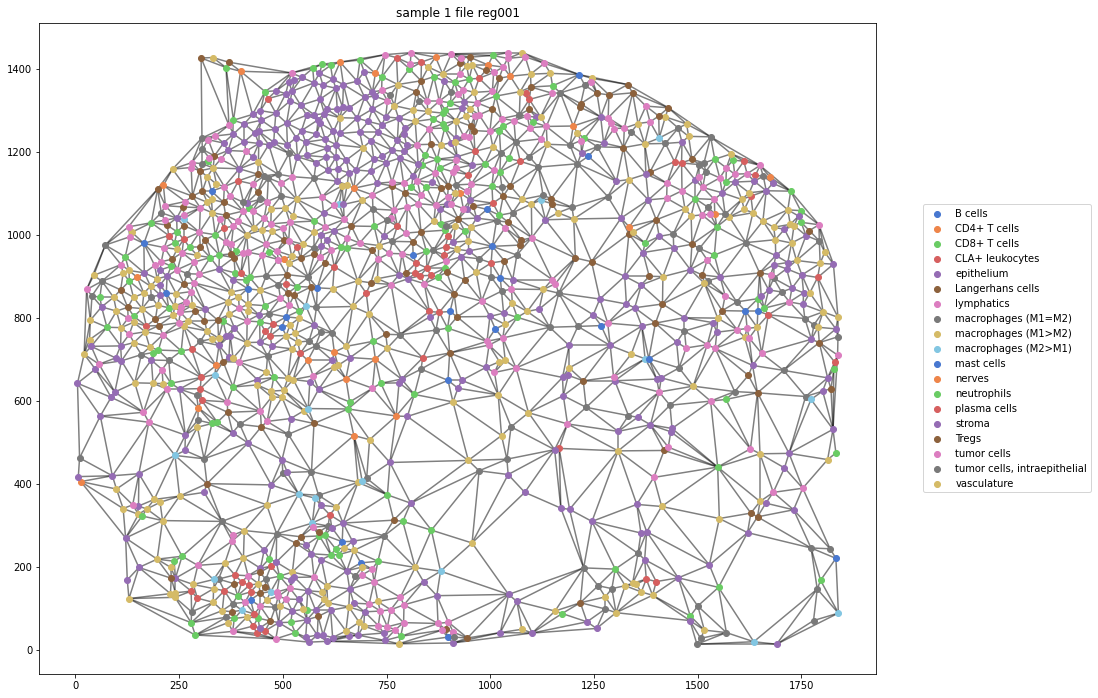

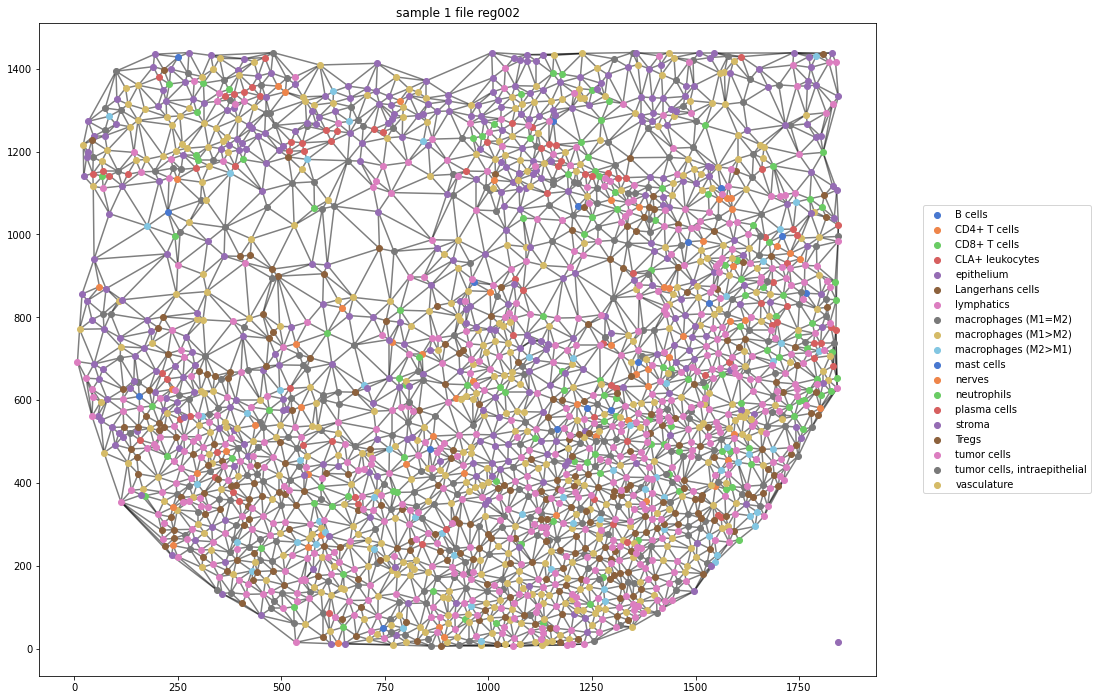

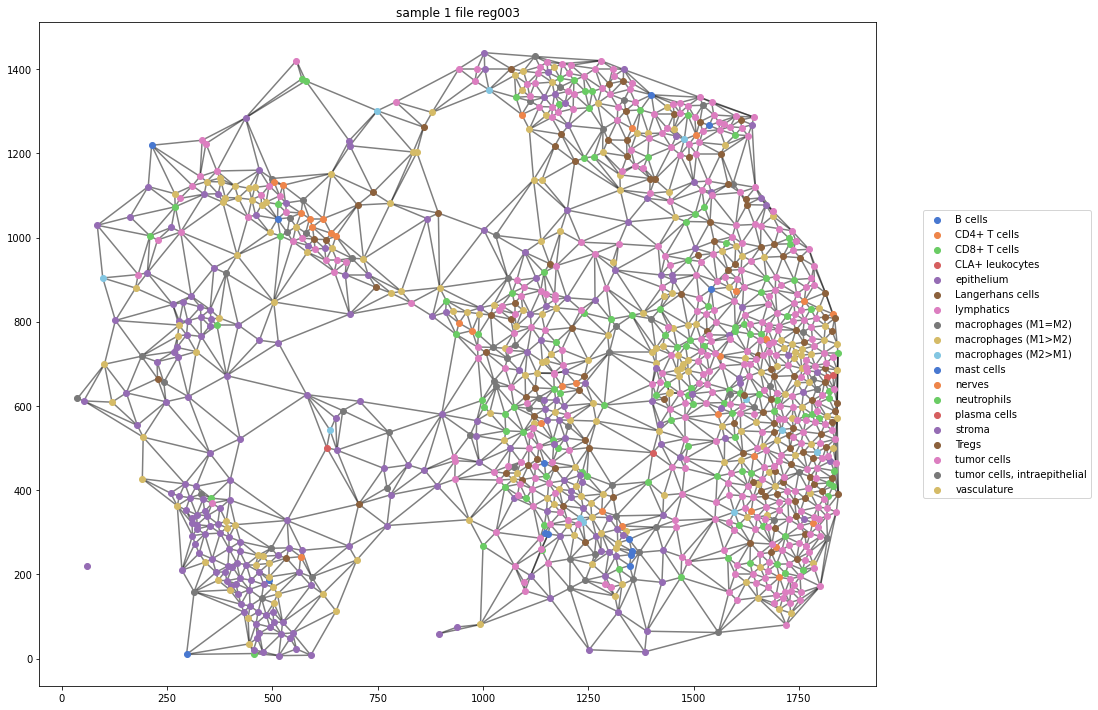

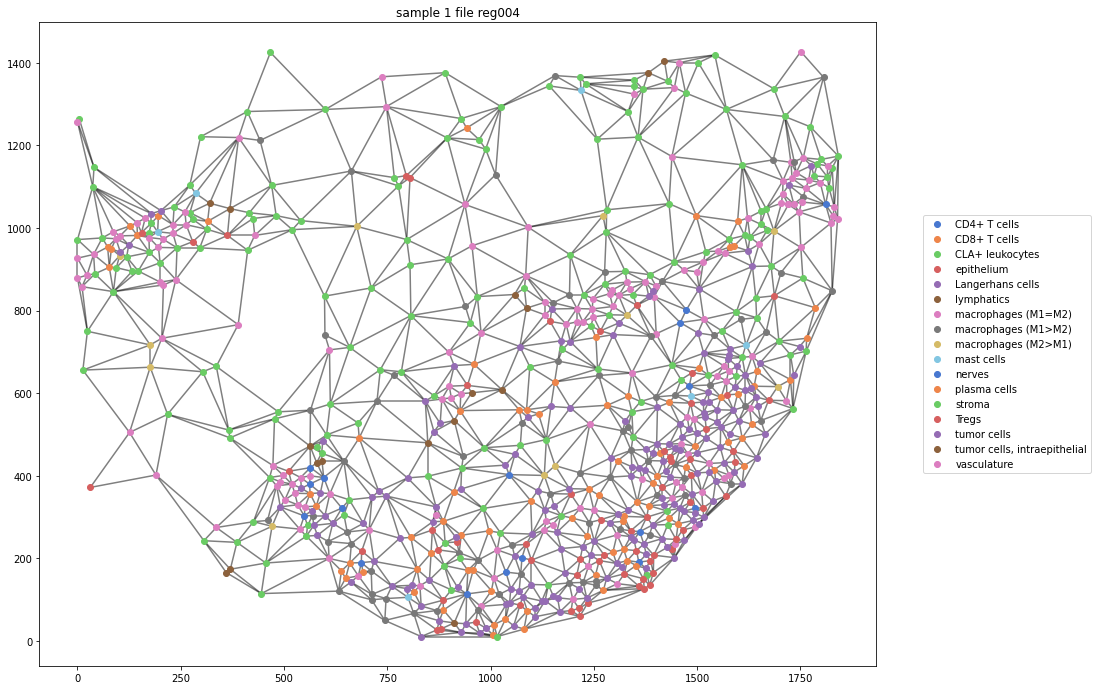

In [11]:
sample_id = 1  # that's our patient
select_sample = obj['Patients'] == sample_id
filenames = obj.loc[select_sample, 'FileName'].unique()  # look for the several samples per patient
for filename in filenames:
    print("processing filename {}".format(filename))
    select_file = obj['FileName'] == filename
    nodes = obj.loc[select_sample & select_file, all_cols]
    coords = nodes[cell_pos_cols].values
    pairs = ty.build_delaunay(coords, trim_dist=200)
    # we want to avoid isolated cells, so we link them to their 2 closest neighbors
    # pairs = ty.link_solitaries(coords, pairs, method='knn', k=2)

    fig, ax = ty.plot_network(coords, pairs, labels=nodes['ClusterName'],
                              legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)})
    plt.title("sample {} file {}".format(sample_id, filename))

### All samples network reconstruction

#### Plot spatial networks

In [113]:
processed_dir = Path('../data/processed/CODEX_CTCL')

In [114]:
# Choose optimal distances
save_dir = processed_dir / "pretreatment_samples_networks_xy_solitary-0_choose_distance"

files_dst = [
    "reg001",
    "reg003",
    "reg005",
    "reg006",
    "reg037",
    "reg040",
    "reg042",
    "reg051",
    "reg054",
    "reg055",
    "reg016",
    "reg058",
    "reg060",
    "reg019",
]

k_sol = 0 

if RUN_LONG:
    for filename in files_dst:
        print("    processing filename {}".format(filename))
        select_file = obj['FileName'] == filename
        nodes = obj.loc[select_file, all_cols]
        coords = nodes[cell_pos_cols].values
        pairs = ty.build_delaunay(coords, trim_dist=200)
        print("    ", end="")
        if k_sol > 0:
            pairs = ty.link_solitaries(coords, pairs, method='knn', k=k_sol)
        distances = ty.distance_neighbors(coords, pairs)

        fig, ax = ty.plot_network_distances(
            coords, pairs, distances, labels=nodes['ClusterName'],
            legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)}
            )
        plt.axis('off');
        title = f"network_distances_filename-{filename}"
        plt.savefig(str(save_dir / title) + '.png', bbox_inches='tight', facecolor='white')
        plt.show()

In [15]:
trim_dist = 200 # or 'percentile_size'
k_sol = 0 # or 1, 2, 3, ...
reconst_dir = processed_dir / f"pretreatment_samples_networks_xy_trim_dist-{trim_dist}_solitary-{k_sol}"
save_dir = reconst_dir / "networks_images"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [16]:
if RUN_LONG:
    for sample_id in obj['Patients'].unique():
        print(f"processing sample {sample_id}")
        select_sample = obj['Patients'] == sample_id
        filenames = obj.loc[select_sample, 'FileName'].unique()
        for filename in filenames:
            print("    processing filename {}".format(filename))
            select_file = obj['FileName'] == filename
            nodes = obj.loc[select_sample & select_file, all_cols]
            coords = nodes[cell_pos_cols].values
            pairs = ty.build_delaunay(coords, trim_dist=trim_dist)
            print("    ", end="")
            if k_sol > 0:
                pairs = ty.link_solitaries(coords, pairs, method='knn', k=k_sol)

            fig, ax = ty.plot_network(coords, pairs, labels=nodes['ClusterName'],
                                      legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)})
            plt.axis('off');
            title = f"sample-{sample_id}_filename-{filename}_network_delaunay"
            plt.savefig(str(save_dir / title) + '.png', bbox_inches='tight', facecolor='white')
            plt.show()

#### Merge all samples

In [17]:
if RUN_LONG:
    edges_all = pd.DataFrame(data=None, columns=['source', 'target'])
    # number of nodes previously seen
    nb_nodes = 0
    for sample_id in obj['Patients'].unique():
        print(f"processing sample {sample_id}")
        select_sample = obj['Patients'] == sample_id
        filenames = obj.loc[select_sample, 'FileName'].unique()
        for filename in filenames:
            print("    processing filename {}".format(filename))
            select_file = obj['FileName'] == filename
            nodes = obj.loc[select_sample & select_file, all_cols]
            coords = nodes[cell_pos_cols].values
            pairs = ty.build_delaunay(coords, trim_dist=trim_dist)
            print("    ", end="")
            if k_sol > 0:
                pairs = ty.link_solitaries(coords, pairs, method='knn', k=k_sol)

            # increase ids in pairs by the number of nodes in all previously loaded networks
            pairs = pairs + nb_nodes
            edges = pd.DataFrame(data=pairs, columns=['source', 'target'])
            # update number of nodes for next network
            nb_nodes = nb_nodes + coords.shape[0]
            edges_all = pd.concat([edges_all, edges], ignore_index=True)
    edges_all.to_csv(reconst_dir / 'sample_all-edges.csv', index=False)
else:
    edges_all = pd.read_csv(reconst_dir / 'sample_all-edges.csv')

In [19]:
# or save in separate file for convenience
if RUN_LONG:
    for sample_id in obj['Patients'].unique():
        print(f"processing sample {sample_id}")
        select_sample = obj['Patients'] == sample_id
        filenames = obj.loc[select_sample, 'FileName'].unique()
        for filename in filenames:
            print("    processing filename {}".format(filename))
            select_file = obj['FileName'] == filename
            nodes = obj.loc[select_sample & select_file, all_cols]
            coords = nodes[cell_pos_cols].values
            pairs = ty.build_delaunay(coords, trim_dist=trim_dist)
            print("    ", end="")
            if k_sol > 0:
                pairs = ty.link_solitaries(coords, pairs, method='knn', k=k_sol)

            edges = pd.DataFrame(data=pairs, columns=['source', 'target'])
            edges.to_csv(reconst_dir / f'edges_sample-{filename}.csv', index=False)

## Response groups characteristics and survival analysis

We will look at what variables define or explain response to therapy or longer survival.  
For this, we will start with the simplest statistics, like proportions of cell types or marker-positive cells, and we will gradulally increase the complexity of variables, looking at interactions between cell types and finally discovering spatial neighborhoods, potentially predictive of response to therapy.

### Cell types proportions

In [18]:
# we add attributes to nodes to color network figures
nodes_all = obj[cell_pos_cols].copy()
nodes_all['CellCluster'] = obj['ClusterName'].values
nodes_all = nodes_all.join(pd.get_dummies(obj['ClusterName']))
attribute_uniq = nodes_all['CellCluster'].unique()

In [19]:
# here we don't use `FileName` in the group / unstack procedure to aggregate statistics 
# per patient and condition (before / after treatment) rather than per sample.

count_types = obj[['Patients', 'Groups', 'Count']].join(nodes_all['CellCluster']).groupby(['Patients', 'Groups', 'CellCluster']).count().unstack()
count_types.columns = count_types.columns.droplevel()
count_types = count_types.fillna(value=0).astype(int)
# count_types.index.name = 'sample'
count_types.to_csv(save_dir / 'count_types_per_patient_per_condition.csv')
count_types.head(6)

CellCluster      B cells  CD4+ T cells  CD8+ T cells  CLA+ leukocytes  \
Patients Groups                                                         
1        1            34            50           229               20   
2        1             6             3             5                3   
3        2             2           208           186               14   
4        2           178            20            45                0   
5        1             0             0             1                0   
6        2            83           200           693               15   

CellCluster      DCs, CD11c+  IDO+ stromal cells  Langerhans cells  Tregs  \
Patients Groups                                                             
1        1                 0                   0                42    350   
2        1                 0                   0                12     15   
3        2                 0                   2               130     99   
4        2                 0                   0                16      9   
5        1                 0                   0                 5      6   
6        2                 0                   3                95    357   

CellCluster      epithelium  lymphatics  ...  macrophages (M1>M2)  \
Patients Groups                          ...                        
1        1              112          23  ...                  545   
2        1                6           5  ...                   71   
3        2             1759          24  ...                  397   
4        2              901           7  ...                  202   
5        1              913           0  ...                   17   
6        2               11         102  ...                  809   

CellCluster      macrophages (M2>M1)  mast cells  nerves  neutrophils  \
Patients Groups                                                         
1        1                        83           9      33           36   
2        1                        64           3       6            1   
3        2                        39          33      17            0   
4        2                        10          12       9            0   
5        1                         2           2       3            0   
6        2                        43          20       5           26   

CellCluster      plasma cells  stroma  tumor cells  \
Patients Groups                                      
1        1                133     582          777   
2        1                  4     203          155   
3        2                  4     328          546   
4        2                  4     356          987   
5        1                  1      34            7   
6        2                 35     679         1157   

CellCluster      tumor cells, intraepithelial  vasculature  
Patients Groups                                             
1        1                                 48          149  
2        1                                  2           95  
3        2                                274           86  
4        2                                  5          186  
5        1                                  1           18  
6        2                                 22          255  

[6 rows x 21 columns]

Instead of counts we use proportions of cell types per patient and condition.

In [20]:
prop_types = count_types.div(count_types.sum(axis=1), axis=0)
prop_types

CellCluster       B cells  CD4+ T cells  CD8+ T cells  CLA+ leukocytes  \
Patients Groups                                                          
1        1       0.009379      0.013793      0.063172         0.005517   
2        1       0.008392      0.004196      0.006993         0.004196   
3        2       0.000465      0.048327      0.043216         0.003253   
4        2       0.058649      0.006590      0.014827         0.000000   
5        1       0.000000      0.000000      0.000984         0.000000   
6        2       0.017263      0.041597      0.144135         0.003120   
7        2       0.000000      0.000000      0.000000         0.000000   
8        2       0.004871      0.008524      0.007916         0.002841   
9        1       0.000749      0.007113      0.019094         0.000749   
10       1       0.002754      0.005507      0.028718         0.000000   
11       1       0.001342      0.006711      0.014765         0.000000   
12       2       0.005878      0.018001      0.039309         0.001837   
13       1       0.001793      0.013625      0.005737         0.002510   
14       2       0.004636      0.014238      0.034437         0.002318   

CellCluster      DCs, CD11c+  IDO+ stromal cells  Langerhans cells     Tregs  \
Patients Groups                                                                
1        1          0.000000            0.000000          0.011586  0.096552   
2        1          0.000000            0.000000          0.016783  0.020979   
3        2          0.000000            0.000465          0.030204  0.023002   
4        2          0.000000            0.000000          0.005272  0.002965   
5        1          0.000000            0.000000          0.004921  0.005906   
6        2          0.000000            0.000624          0.019759  0.074251   
7        2          0.000000            0.000000          0.002494  0.000000   
8        2          0.000000            0.000000          0.001827  0.007713   
9        1          0.000000            0.000000          0.004118  0.003370   
10       1          0.000000            0.000000          0.007081  0.042486   
11       1          0.000671            0.000000          0.014765  0.053691   
12       2          0.000000            0.000735          0.020206  0.059882   
13       1          0.000000            0.000000          0.019720  0.017928   
14       2          0.000331            0.000000          0.017550  0.207947   

CellCluster      epithelium  lymphatics  ...  macrophages (M1>M2)  \
Patients Groups                          ...                        
1        1         0.030897    0.006345  ...             0.150345   
2        1         0.008392    0.006993  ...             0.099301   
3        2         0.408690    0.005576  ...             0.092240   
4        2         0.296870    0.002306  ...             0.066557   
5        1         0.898622    0.000000  ...             0.016732   
6        2         0.002288    0.021215  ...             0.168261   
7        2         0.000000    0.007481  ...             0.039900   
8        2         0.068602    0.009133  ...             0.035316   
9        1         0.389742    0.001498  ...             0.048297   
10       1         0.291503    0.010228  ...             0.125492   
11       1         0.306040    0.004698  ...             0.065101   
12       2         0.316312    0.008450  ...             0.100661   
13       1         0.539261    0.001434  ...             0.058444   
14       2         0.150662    0.006954  ...             0.101656   

CellCluster      macrophages (M2>M1)  mast cells    nerves  neutrophils  \
Patients Groups                                                           
1        1                  0.022897    0.002483  0.009103     0.009931   
2        1                  0.089510    0.004196  0.008392     0.001399   
3        2                  0.009061    0.007667  0.003950     0.000000   
4        2                  0.003295    0.003954  0.00

#### Descriptive statistics

##### First order

In [109]:
pvals = mosna.find_DE_markers(prop_types, group_ref=1, group_tgt=2, group_var='Groups', composed_vars=False)
pvals = pvals.sort_values(by='pval', ascending=True)
pvals

pval  pval_corr
CellCluster                             
macrophages (M1=M2)  0.212121   0.999961
CD4+ T cells         0.212121   0.999961
tumor cells          0.575175   0.999961
macrophages (M2>M1)  0.575175   0.999961
lymphatics           0.575175   0.999961
...                       ...        ...
neutrophils          0.962704   0.999961
stroma               0.962704   0.999961
DCs, CD11c+          0.999961   0.999961
mast cells           0.999961   0.999961
plasma cells         0.999961   0.999961

[21 rows x 2 columns]

Cell types proportions are not significantly associated with response / non response in samples before treatment.  
But `mosna` can find composed variables potentially related to response of patients:

In [23]:
# `find_DE_markers` can make composite variables, but we do it beforehand to reuse them
prop_types_comp = pd.concat([prop_types, mosna.make_composed_variables(prop_types, order=1)], axis=1)

pvals = mosna.find_DE_markers(prop_types_comp, group_ref=1, group_tgt=2, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

In [24]:
pvals.head(20)

pval  pval_corr
(lymphatics / macrophages (M1=M2))             0.008159   0.907407
(tumor cells / vasculature)                    0.053030   0.907407
(B cells / macrophages (M2>M1))                0.053030   0.907407
(lymphatics / vasculature)                     0.053030   0.907407
(CD8+ T cells / macrophages (M2>M1))           0.053030   0.907407
...                                                 ...        ...
(epithelium / macrophages (M1>M2))             0.212121   0.907407
(CD8+ T cells / tumor cells, intraepithelial)  0.212121   0.907407
(Tregs / macrophages (M2>M1))                  0.212121   0.907407
(CD4+ T cells / Tregs)                         0.212121   0.907407
(CD4+ T cells / epithelium)                    0.212121   0.907407

[20 rows x 2 columns]

#### Visualization

In [25]:
prop_types_comp

B cells  CD4+ T cells  CD8+ T cells  CLA+ leukocytes  \
Patients Groups                                                          
1        1       0.009379      0.013793      0.063172         0.005517   
2        1       0.008392      0.004196      0.006993         0.004196   
3        2       0.000465      0.048327      0.043216         0.003253   
4        2       0.058649      0.006590      0.014827         0.000000   
5        1       0.000000      0.000000      0.000984         0.000000   
...                   ...           ...           ...              ...   
10       1       0.002754      0.005507      0.028718         0.000000   
11       1       0.001342      0.006711      0.014765         0.000000   
12       2       0.005878      0.018001      0.039309         0.001837   
13       1       0.001793      0.013625      0.005737         0.002510   
14       2       0.004636      0.014238      0.034437         0.002318   

                 DCs, CD11c+  IDO+ stromal cells  Langerhans cells     Tregs  \
Patients Groups                                                                
1        1          0.000000            0.000000          0.011586  0.096552   
2        1          0.000000            0.000000          0.016783  0.020979   
3        2          0.000000            0.000465          0.030204  0.023002   
4        2          0.000000            0.000000          0.005272  0.002965   
5        1          0.000000            0.000000          0.004921  0.005906   
...                      ...                 ...               ...       ...   
10       1          0.000000            0.000000          0.007081  0.042486   
11       1          0.000671            0.000000          0.014765  0.053691   
12       2          0.000000            0.000735          0.020206  0.059882   
13       1          0.000000            0.000000          0.019720  0.017928   
14       2          0.000331            0.000000          0.017550  0.207947   

                 epithelium  lymphatics  ...  (plasma cells / stroma)  \
Patients Groups                          ...                            
1        1         0.030897    0.006345  ...                 0.228522   
2        1         0.008392    0.006993  ...                 0.019704   
3        2         0.408690    0.005576  ...                 0.012195   
4        2         0.296870    0.002306  ...                 0.011236   
5        1         0.898622    0.000000  ...                 0.029412   
...                     ...         ...  ...                      ...   
10       1         0.291503    0.010228  ...                 0.007246   
11       1         0.306040    0.004698  ...                 0.000000   
12       2         0.316312    0.008450  ...                 0.020202   
13       1         0.539261    0.001434  ...                 0.037815   
14       2         0.150662    0.006954  ...                 0.013333   

                 (plasma cells / tumor cells)  \
Patients Groups                                 
1        1                           0.171171   
2        1                           0.025806   
3        2                           0.007326   
4        2                           0.004053   
5        1                           0.142857   
...                                       ...   
10       1                           0.018293   
11       1                           0.000000   
12       2                           0.006920   
13       1                           0.021480   
14       2                           0.003797   

                 (plasma cells / tumor cells, intraepithelial)  \
Patients Groups                                                  
1        1                                            2.770833   
2        1                                            2.000000   
3        2                                            0.014599   
4        2                                            0.800000   
5        1                    

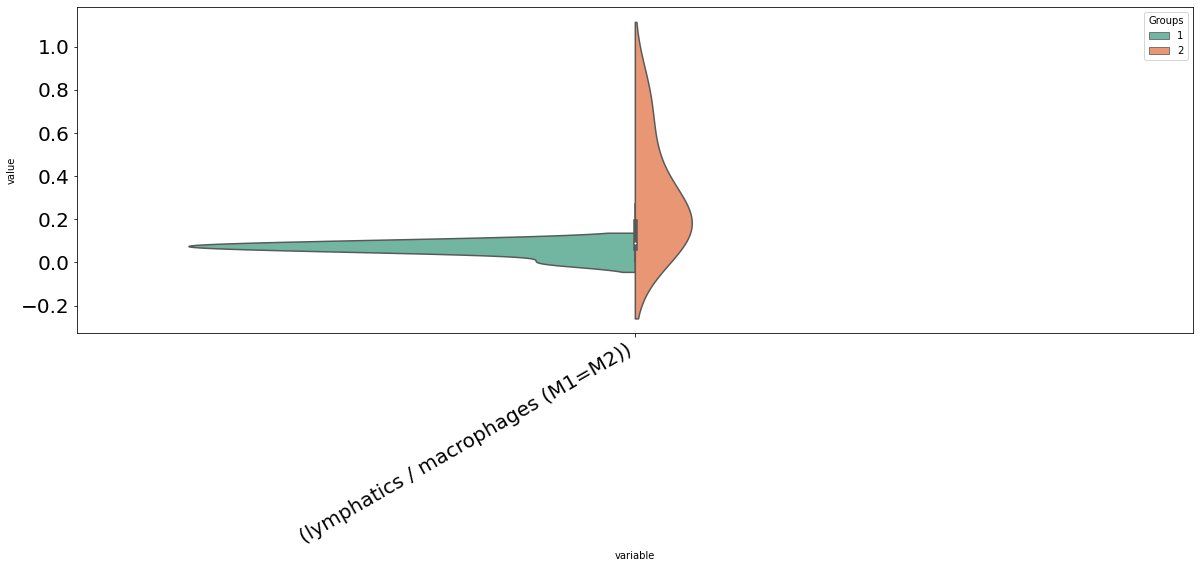

In [26]:
fig, ax = mosna.plot_distrib_groups(
    prop_types_comp, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    )

##### Second order

In [28]:
# `find_DE_markers` can make composite variables, but we do it beforehand to reuse them
prop_types_comp = pd.concat([prop_types, mosna.make_composed_variables(prop_types, order=2)], axis=1)

pvals = mosna.find_DE_markers(prop_types_comp, group_ref=1, group_tgt=2, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

In [29]:
pvals.head(20)

pval  pval_corr
((lymphatics / macrophages (M1=M2)) / (macropha...  0.000583        1.0
((CD8+ T cells / nerves) / (Tregs / tumor cells))   0.008159        1.0
((lymphatics / macrophages (M1>M2)) / (stroma /...  0.008159        1.0
((lymphatics / tumor cells) / (macrophages (M1=...  0.008159        1.0
(lymphatics / macrophages (M1=M2))                  0.008159        1.0
...                                                      ...        ...
((CD4+ T cells / stroma) / (Tregs / lymphatics))    0.008159        1.0
((epithelium / nerves) / (epithelium / tumor ce...  0.008159        1.0
((macrophages (M1>M2) / vasculature) / (macroph...  0.008159        1.0
((lymphatics / stroma) / (macrophages (M1=M2) /...  0.008159        1.0
((CD4+ T cells / nerves) / (mast cells / tumor ...  0.008159        1.0

[20 rows x 2 columns]

The first variables related to cell types proportions are composed variables of the 2nd order (ratio of ratios), only `lymphatics / macrophages (M1=M2)` appear in the simpler composed variables, but all corrected pvalues are > 0.05. This is because mosna produced *a lot* of composed variables.

#### Visualization

In [30]:
prop_types_comp

B cells  CD4+ T cells  CD8+ T cells  CLA+ leukocytes  \
Patients Groups                                                          
1        1       0.009379      0.013793      0.063172         0.005517   
2        1       0.008392      0.004196      0.006993         0.004196   
3        2       0.000465      0.048327      0.043216         0.003253   
4        2       0.058649      0.006590      0.014827         0.000000   
5        1       0.000000      0.000000      0.000984         0.000000   
...                   ...           ...           ...              ...   
10       1       0.002754      0.005507      0.028718         0.000000   
11       1       0.001342      0.006711      0.014765         0.000000   
12       2       0.005878      0.018001      0.039309         0.001837   
13       1       0.001793      0.013625      0.005737         0.002510   
14       2       0.004636      0.014238      0.034437         0.002318   

                 DCs, CD11c+  IDO+ stromal cells  Langerhans cells     Tregs  \
Patients Groups                                                                
1        1          0.000000            0.000000          0.011586  0.096552   
2        1          0.000000            0.000000          0.016783  0.020979   
3        2          0.000000            0.000465          0.030204  0.023002   
4        2          0.000000            0.000000          0.005272  0.002965   
5        1          0.000000            0.000000          0.004921  0.005906   
...                      ...                 ...               ...       ...   
10       1          0.000000            0.000000          0.007081  0.042486   
11       1          0.000671            0.000000          0.014765  0.053691   
12       2          0.000000            0.000735          0.020206  0.059882   
13       1          0.000000            0.000000          0.019720  0.017928   
14       2          0.000331            0.000000          0.017550  0.207947   

                 epithelium  lymphatics  ...  \
Patients Groups                          ...   
1        1         0.030897    0.006345  ...   
2        1         0.008392    0.006993  ...   
3        2         0.408690    0.005576  ...   
4        2         0.296870    0.002306  ...   
5        1         0.898622    0.000000  ...   
...                     ...         ...  ...   
10       1         0.291503    0.010228  ...   
11       1         0.306040    0.004698  ...   
12       2         0.316312    0.008450  ...   
13       1         0.539261    0.001434  ...   
14       2         0.150662    0.006954  ...   

                 ((stroma / tumor cells, intraepithelial) / (stroma / vasculature))  \
Patients Groups                                                                       
1        1                                                3.104167                    
2        1                                               47.500000                    
3        2                                                0.313869                    
4        2                                               37.200000                    
5        1                                               18.000000                    
...                                                            ...                    
10       1                                               62.600000                    
11       1                                                8.411765                    
12       2                                                0.905983                    
13       1                                                7.000000                    
14       2                                               18.222222                    

                 ((stroma / tumor cells, intraepithelial) / (tumor cells / tumor cells, intraepithelial))  \
Patients Groups                                                                                             
1        1                             

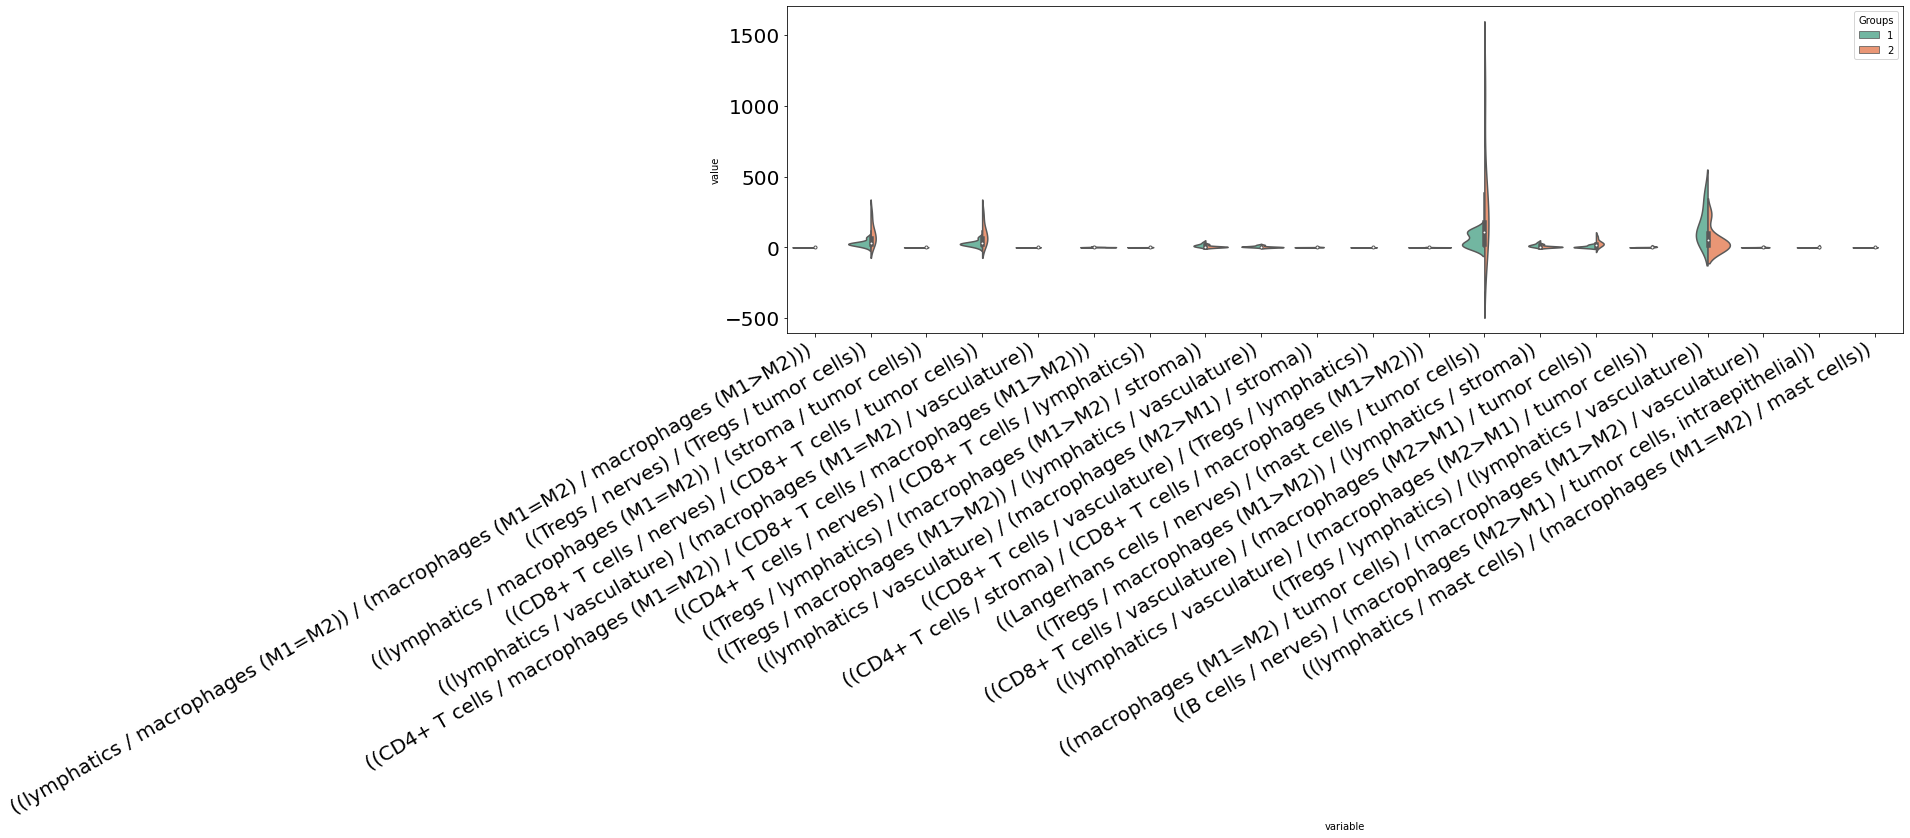

In [31]:
fig, ax = mosna.plot_distrib_groups(
    prop_types_comp, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    )

Some variables hide the distribution of other variables by their much larger range, we can exclude them to better see the other variables:

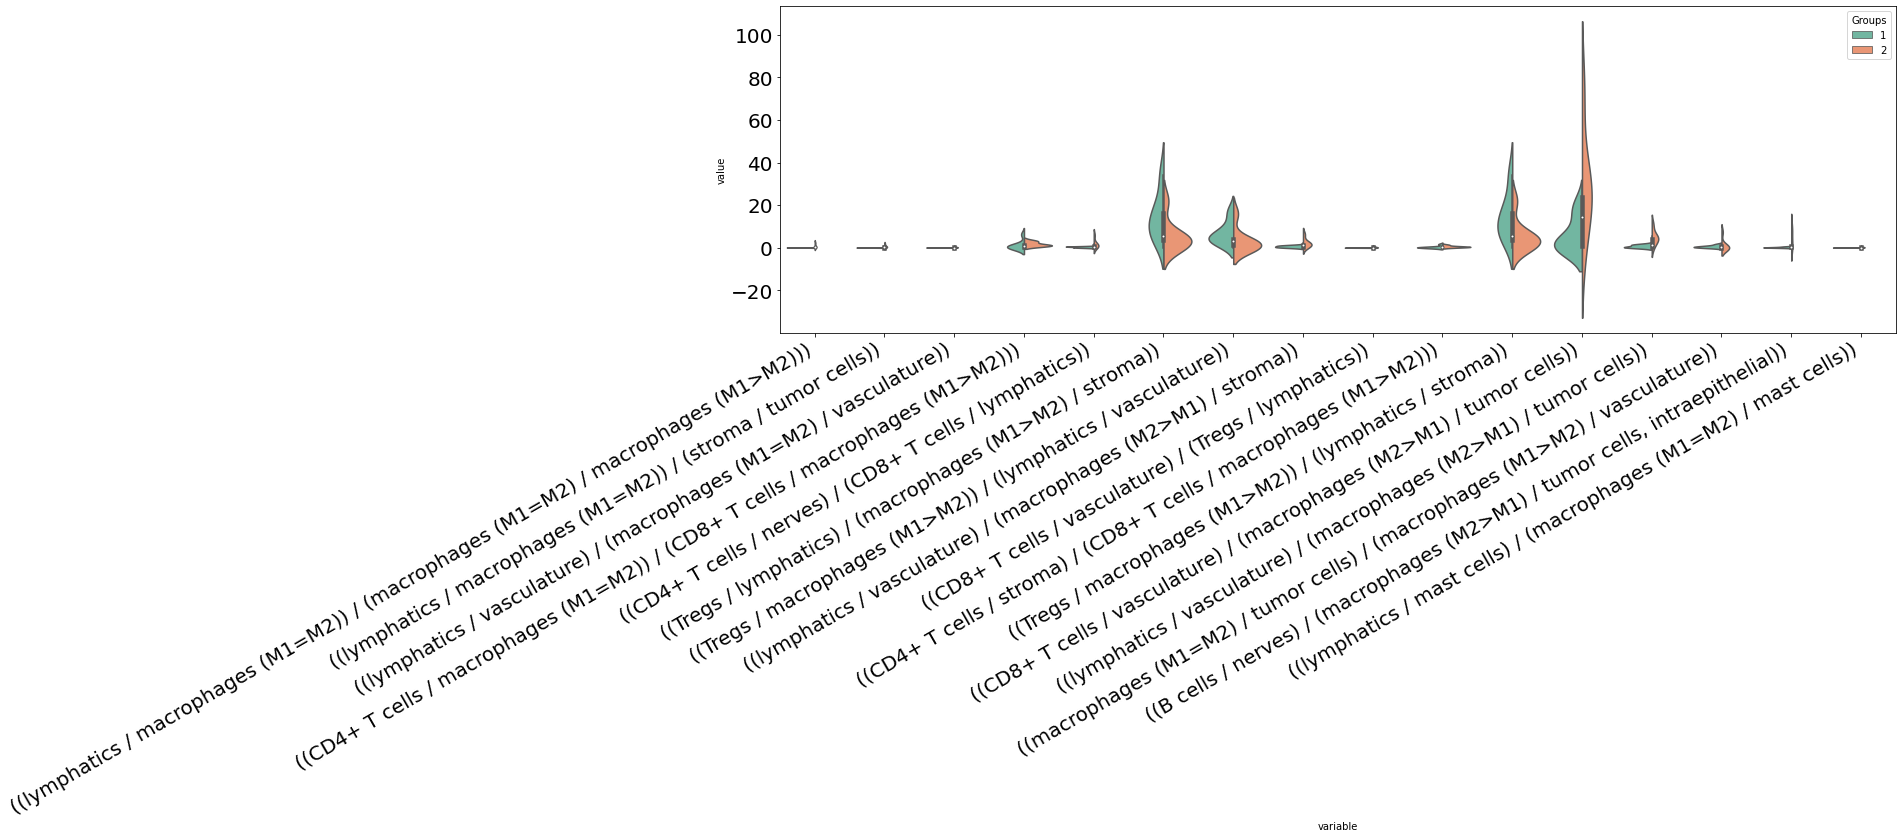

In [32]:
exclude_vars = [
    '((Langerhans cells / nerves) / (mast cells / tumor cells))',
    '((Tregs / lymphatics) / (lymphatics / vasculature))',
    '((Tregs / nerves) / (Tregs / tumor cells))',
    '((CD8+ T cells / nerves) / (CD8+ T cells / tumor cells))',
]
fig, ax = mosna.plot_distrib_groups(
    prop_types_comp, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    exclude_vars=exclude_vars,
    )

### Heatmap of cell types proportions

Here we standardize the columns to make them more comparable between each other and get a more relevant bi-clustering.

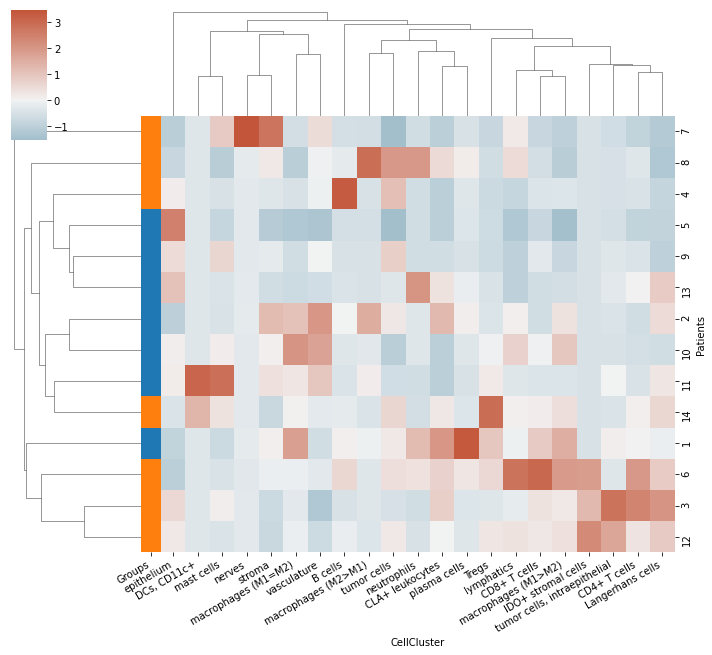

In [33]:
g = mosna.plot_heatmap(
    prop_types.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    z_score=1,
    )

There is no clear separation of patients into their respective groups from their proportions of cell types scaled across patients.

In [34]:
# we need to clean-up data for further analyses and visualizations
prop_types_comp_cleaned, select_finite = mosna.clean_data(
    prop_types_comp, 
    method='mixed',
    thresh=0.9,
    )

There are 82218 non finite values
Imputing data


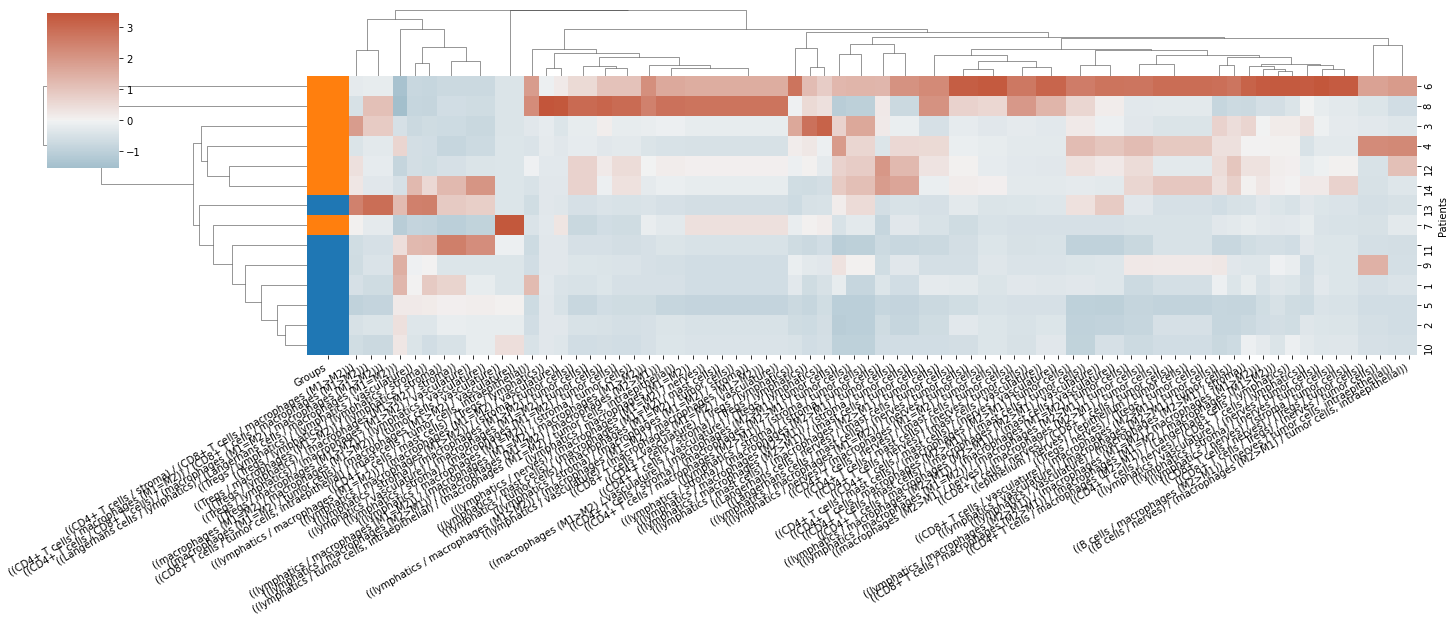

In [35]:
best_pval_names = pvals.loc[pvals['pval'] < 0.05, :].index
# or to select only 20 variables:
# best_pval_names = pvals.head(20).index
mosna.plot_heatmap(
    prop_types_comp_cleaned[best_pval_names].reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    z_score=1,
    figsize=(20, 12),
    )

By selecting the variables with p-values under 5%, although their corresponding corrected p-values are not significant, we can notice a much better separation between patients groups.  
We must be careful though: we have computed a lot of composed variables, and selected those who happened to have the best p-values.

#### Stepwise logistic regression

In [37]:
best_pval_names = pvals.loc[pvals['pval'] < 0.05, :].index.tolist()
model, included = mosna.stepwise_regression(X=prop_types_comp_cleaned, y_name='Groups', y_values=[1, 2], col_names=best_pval_names, verbose=True)

Add  ((Langerhans cells / lymphatics) / (Langerhans cells / macrophages (M1=M2))) with p-value 0.000972217
Add  ((macrophages (M1>M2) / vasculature) / (macrophages (M2>M1) / tumor cells)) with p-value 0.00017107
Add  ((lymphatics / macrophages (M2>M1)) / (macrophages (M1=M2) / macrophages (M1>M2))) with p-value 3.821e-05


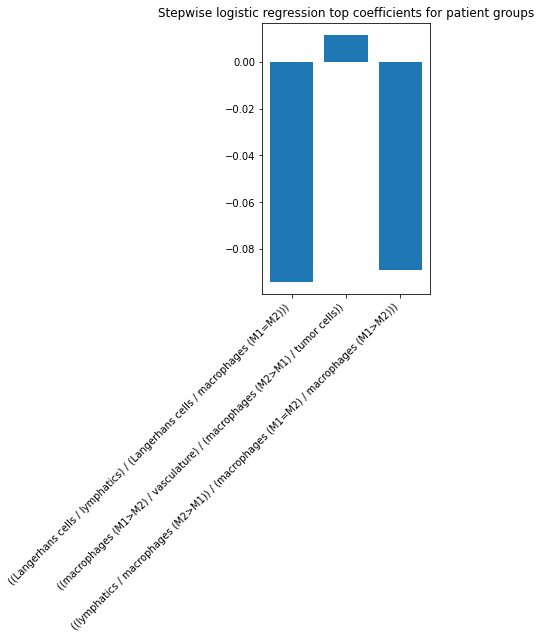

In [38]:
# plot the model's coefficients
coefs = model.params[1:] # skip intercept
nb_coefs = min(coefs.size, 20)
if nb_coefs > 0:
    fig, ax = plt.subplots(figsize=(nb_coefs,5))
    ax.bar(coefs.index, coefs)
    plt.xticks(rotation=45, ha='right');
    title = f"Stepwise logistic regression top coefficients for patient groups"
    plt.title(title)

#### Risk ratios

#### Survival analysis

### Marker-positive cells proportions

In [29]:
def highlight_under(s, thresh=0.05, color='darkorange'):
    '''
    highlight values that are under a threshold
    '''
    is_under = s <= thresh
    attr = 'background-color: {}'.format(color)
    return [attr if v else '' for v in is_under]

We have seen that cell types proportions don't explain response of patient to therapy. But maybe interactions between cell types play a role in response?  
To answer this question we will look at the *mixing matrix* and *assortativity* of tissue networks.  

## Cell types interactions

We compute cell types interactions per sample to aggregate latter per patient or condition.

###  Assortativity and Mixing Matrix

#### Computation of assortativity

In [21]:
grouping = 'FileName'
n_shuffle = 500
load_dir = reconst_dir
save_dir = load_dir / "assortativity"
filename = save_dir / f'network_interactions_stats_grouping-{grouping}_n_shuffle-{n_shuffle}.csv'

if RUN_LONG or not filename.exists():
    print("Computing z-scored assortativity")
    start = time()
    net_stats = mosna.batch_assort_mixmat(nodes_all, edges_all, 
                                    attributes=attribute_uniq, 
                                    groups=obj[grouping], 
                                    n_shuffle=n_shuffle,
                                    parallel_groups=False,
                                    memory_limit='100GB',
                                    save_intermediate_results=False, 
                                    dir_save_interm=save_dir)
    end = time()
    duration = end - start
    print(f"Assortativity took {duration}s for n_suffle {n_shuffle}")

    net_stats.index = net_stats['id']
    net_stats.drop(columns=['id'], inplace=True)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    net_stats.to_csv(filename)
else:
    print("Loading z-scored assortativity")
    net_stats = pd.read_csv(filename, index_col=0)

Loading z-scored assortativity


In [22]:
net_stats

# total  % B cells  % CD4+ T cells  % CD8+ T cells  % CLA+ leukocytes  \
id                                                                              
reg001     1301   0.017679        0.012298        0.082244           0.009224   
reg002     2324   0.004733        0.014630        0.052496           0.003442   
reg006      603   0.009950        0.004975        0.008292           0.004975   
reg035     2053   0.000487        0.007306        0.014613           0.000974   
reg036      618   0.001618        0.006472        0.033981           0.000000   
reg039     1225   0.003265        0.006531        0.033469           0.000000   
reg040     1317   0.002278        0.004556        0.024298           0.000000   
reg042      385   0.005195        0.000000        0.005195           0.000000   
reg051     1082   0.001848        0.018484        0.010166           0.001848   
reg052     1707   0.001757        0.010545        0.002929           0.002929   
reg009     2334   0.000857        0.046701        0.048843           0.001714   
reg013     1765   0.086686        0.008499        0.015864           0.000000   
reg014     1270   0.019685        0.003937        0.013386           0.000000   
reg021     2483   0.020942        0.038260        0.149819           0.003625   
reg022     2325   0.013333        0.045161        0.138065           0.002581   
reg029     1916   0.002610        0.007307        0.004697           0.004175   
reg030     1909   0.008905        0.012572        0.013620           0.003143   
reg031     1102   0.001815        0.003630        0.003630           0.000000   
reg045     1914   0.005225        0.017241        0.037095           0.002090   
reg046      808   0.007426        0.019802        0.044554           0.001238   
reg057     1166   0.006003        0.021441        0.066038           0.002573   
reg058     1854   0.003776        0.009709        0.014563           0.002157   
reg041     1105   0.000000        0.009050        0.018100           0.000000   
reg010     1970   0.000000        0.050254        0.036548           0.005076   
reg017      558   0.000000        0.000000        0.001792           0.000000   
reg005      112   0.000000        0.000000        0.000000           0.000000   
reg018      458   0.000000        0.000000        0.000000           0.000000   
reg026      257   0.000000        0.000000        0.000000           0.000000   
reg025      144   0.000000        0.000000        0.000000           0.000000   

        % DCs, CD11c+  % epithelium  % IDO+ stromal cells  % Langerhans cells  \
id                                                                              
reg001       0.000000      0.069178              0.000000            0.016910   
reg002       0.000000      0.009466              0.000000            0.008606   
reg006       0.000000      0.006633              0.000000            0.019900   
reg035       0.000000      0.500731              0.000000            0.004384   
reg036       0.000000      0.021036              0.000000            0.003236   
reg039       0.000000      0.288163              0.000000            0.004898   
reg040       0.000000      0.294609              0.000000            0.009112   
reg042       0.000000      0.002597              0.000000            0.007792   
reg051       0.000000      0.396488              0.000000            0.021257   
reg052       0.000000      0.629760              0.000000            0.018746   
reg009       0.000000      0.416881              0.000428            0.033419   
reg013       0.000000      0.265156              0.000000            0.003399   
reg014       0.000000      0.340945              0.000000            0.007874   
reg021       0.000000      0.001208              0.000403            0.017318   
reg022       0.000000      0.003441              0.000860            0.022366   
reg029       0.000000      0.070981              0.000000            0.002088   
reg030       0.000000      0.077528   

#### Example of Mixing Matrix

In [23]:
sample_id = 'reg001'
# TODO: reimplement the 'RAW' flag
# raw_cols = [x for x in net_stats.columns if x.endswith('RAW') and not x.startswith('assort')]
raw_cols = net_stats.iloc[:, 26:257].columns
z_cols = [x for x in net_stats.columns if x.endswith('Z') and not x.startswith('assort')]

mixmat_raw = mosna.series_to_mixmat(net_stats.loc[sample_id, raw_cols], discard=' RAW').astype(float)
mixmat_z = mosna.series_to_mixmat(net_stats.loc[sample_id, z_cols], discard=' Z').astype(float)
assort_raw = net_stats.loc[sample_id, "assort"]
assort_z = net_stats.loc[sample_id, "assort Z"]

# select_cols = np.logical_and(mixmat_raw.isna(axis=0) == 0, mixmat_z.isna(axis=0) == 0)

Raw assortativity by cell types: 0.97
Z-scored assortativity by cell types: 118.32


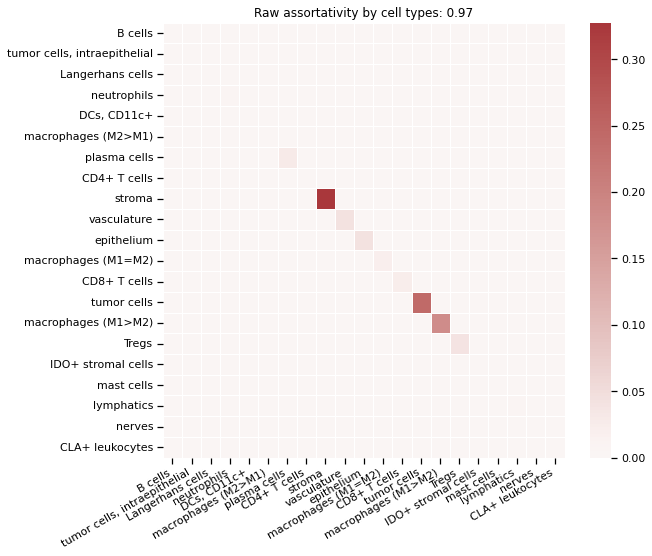

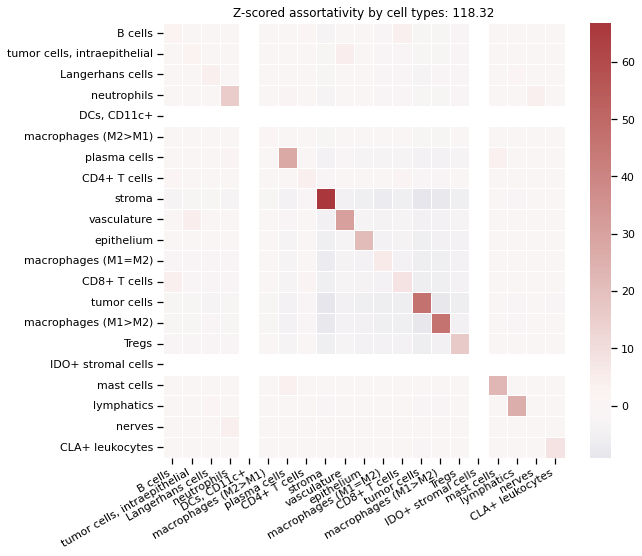

In [24]:
# sns.set_context('talk')
sns.set_context("notebook")
figsize = (9, 8)

title = "Raw assortativity by cell types: {:.2f}".format(assort_raw)
print(title)
f, ax = plt.subplots(figsize=figsize)
sns.heatmap(mixmat_raw, center=0, cmap="vlag", annot=False, linewidths=.5, ax=ax)
ax.set_title(title)
plt.xticks(rotation=30, ha='right');
plt.xticks(rotation=30, ha='right');
# plt.xticks(rotation=30, ha='right', fontsize=20);
# plt.yticks(fontsize=20);
plt.savefig(save_dir / f"assortativity_raw_sample-{sample_id}", bbox_inches='tight', facecolor='white')

title = "Z-scored assortativity by cell types: {:.2f}".format(assort_z)
print(title)
f, ax = plt.subplots(figsize=figsize)
sns.heatmap(mixmat_z, center=0, cmap="vlag", annot=False, linewidths=.5, ax=ax)
ax.set_title(title)
plt.xticks(rotation=30, ha='right');
plt.savefig(save_dir / "assortativity_z-scored_sample-{sample_id}", bbox_inches='tight', facecolor='white')

Raw assortativity by cell types: 0.97
Z-scored assortativity by cell types: 118.32


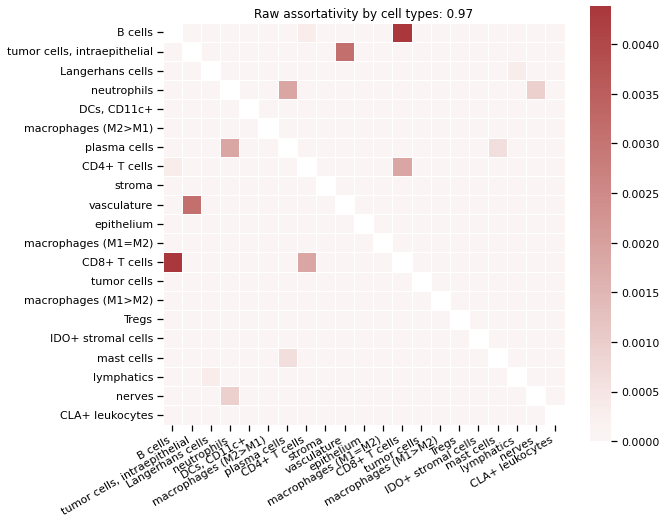

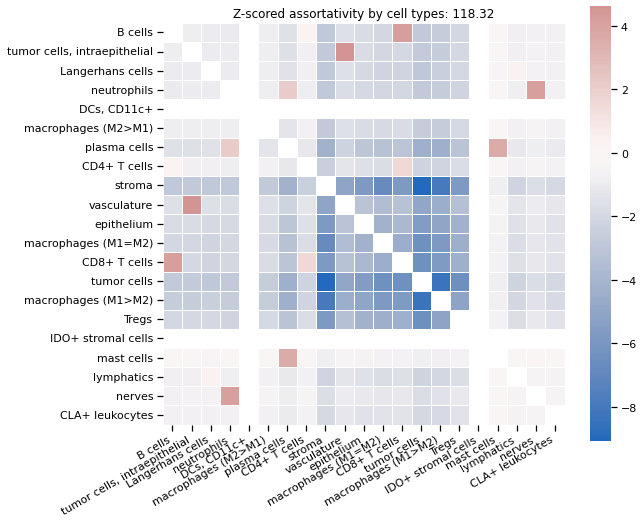

In [25]:
# Hide diagonal
# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(mixmat_raw, dtype=bool))
# Generate a mask for the diagonal
mask = np.eye(mixmat_raw.shape[0], dtype=bool)

# sns.set_context('talk')
sns.set_context("notebook")
figsize = (9, 8)

title = "Raw assortativity by cell types: {:.2f}".format(assort_raw)
print(title)
f, ax = plt.subplots(figsize=figsize)
sns.heatmap(mixmat_raw, mask=mask, center=0, cmap="vlag", annot=False, square=True, linewidths=.5, ax=ax)
ax.set_title(title)
plt.xticks(rotation=30, ha='right');
plt.xticks(rotation=30, ha='right');#, fontsize=20);
# plt.yticks(fontsize=20);
plt.savefig(save_dir / f"assortativity_raw_sample-{sample_id}_diagonal", bbox_inches='tight', facecolor='white')

title = "Z-scored assortativity by cell types: {:.2f}".format(assort_z)
print(title)
f, ax = plt.subplots(figsize=figsize)
sns.heatmap(mixmat_z, mask=mask, center=0, cmap="vlag", annot=False, square=True, linewidths=.5, ax=ax)
ax.set_title(title)
plt.xticks(rotation=30, ha='right');
plt.savefig(save_dir / "assortativity_z-scored_sample-{sample_id}_diagonal", bbox_inches='tight', facecolor='white')

After removing highly self-assortative cell-types, we can notice that ~~most cell types tend to avoid other cell types in this sample.~~

#### Assortativity and patients response

In [26]:
z_cols = [x for x in net_stats.columns if x.endswith('Z')]
z_net_stats = net_stats[z_cols]

In [27]:
z_net_stats

assort Z  B cells - B cells Z  CD4+ T cells - B cells Z  \
id                                                                  
reg001  118.322045             2.303197                  0.319617   
reg002  137.208092            -0.231748                  0.942463   
reg006   55.655024            -0.177131                 -0.257600   
reg035   97.992931                  NaN                 -0.135388   
reg036   49.643293                  NaN                 -0.119159   
reg039   89.780443            -0.100504                 -0.209383   
reg040   94.477780            -0.077693                  5.031480   
reg042   38.666432            -0.044766                       NaN   
reg051   73.188113            -0.044766                  2.821890   
reg052  104.690865            -0.089803                 -0.312898   
reg009  147.886215                  NaN                 -0.553307   
reg013   99.901993            35.849881                 -0.370389   
reg014   86.175295            55.901497                 -0.567971   
reg021  136.845297            13.848983                  5.456032   
reg022  133.376411             3.625914                  4.726838   
reg029  102.072976            -0.119159                 -0.320670   
reg030  119.073960            -0.477477                  0.455965   
reg031   72.228813            -0.063372                 -0.135388   
reg045  126.599272             3.486817                  3.561252   
reg046   58.320174            -0.127515                  2.069256   
reg057   67.795311             6.120583                  5.854129   
reg058  119.864610            -0.163383                 -0.452958   
reg041   76.101295                  NaN                       NaN   
reg010  129.346618                  NaN                       NaN   
reg017   36.384874                  NaN                       NaN   
reg005   10.062674                  NaN                       NaN   
reg018   29.590299                  NaN                       NaN   
reg026   24.519013                  NaN                       NaN   
reg025   13.905883                  NaN                       NaN   

        CD4+ T cells - CD4+ T cells Z  CD8+ T cells - B cells Z  \
id                                                                
reg001                       3.737300                  4.237213   
reg002                       6.068523                  7.768863   
reg006                      -0.127515                 -0.280056   
reg035                      15.522748                 -0.189234   
reg036                      -0.135388                 -0.243207   
reg039                       4.554887                  2.984606   
reg040                      -0.156813                 -0.344047   
reg042                            NaN                 -0.135388   
reg051                       8.566951                 -0.163383   
reg052                      13.080265                 -0.182989   
reg009                      31.125710                 -0.529696   
reg013                       2.200929                 -2.356323   
reg014                      -0.156813                 -0.920241   
reg021                      25.691575                 -3.959517   
reg022                      31.095367                 -3.060520   
reg029                      17.265671                 -0.234839   
reg030                      19.548258                 -0.803581   
reg031                      -0.135388                 -0.127515   
reg045                      16.656528                 -1.014089   
reg046                      14.043893                 -0.536480   
reg057                      13.788085                 -0.831624   
reg058                       5.909709                 -0.597786   
reg041                      13.915332                       NaN   
reg010                      18.643403                       NaN   
reg017                            NaN                       NaN   
reg005                            NaN                       N

In [28]:
# Have a look at nan values
for name, value in z_net_stats.isna().sum().iteritems():
    print(name, ' ' * (52- len(name)), value)

assort Z                                              0
B cells - B cells Z                                   10
CD4+ T cells - B cells Z                              8
CD4+ T cells - CD4+ T cells Z                         6
CD8+ T cells - B cells Z                              7
CD8+ T cells - CD4+ T cells Z                         6
CD8+ T cells - CD8+ T cells Z                         5
CLA+ leukocytes - B cells Z                           15
CLA+ leukocytes - CD4+ T cells Z                      13
CLA+ leukocytes - CD8+ T cells Z                      13
CLA+ leukocytes - CLA+ leukocytes Z                   15
DCs, CD11c+ - B cells Z                               28
DCs, CD11c+ - CD4+ T cells Z                          27
DCs, CD11c+ - CD8+ T cells Z                          27
DCs, CD11c+ - CLA+ leukocytes Z                       28
DCs, CD11c+ - DCs, CD11c+ Z                           29
epithelium - B cells Z                                7
epithelium - CD4+ T cells Z           

(array([31., 45., 53., 21., 29., 11.,  1.,  0., 19., 22.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

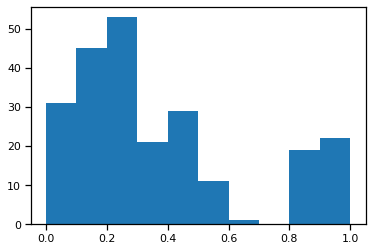

In [29]:
plt.hist(z_net_stats.isna().sum(axis=0) / z_net_stats.shape[0])

In [30]:
z_net_stats.isna().sum(axis=1) / z_net_stats.shape[1]

id
reg001    0.176724
reg002    0.176724
reg006    0.181034
reg035    0.422414
reg036    0.482759
reg039    0.271552
reg040    0.262931
reg042    0.482759
reg051    0.258621
reg052    0.181034
reg009    0.198276
reg013    0.336207
reg014    0.418103
reg021    0.099138
reg022    0.181034
reg029    0.189655
reg030    0.262931
reg031    0.426724
reg045    0.094828
reg046    0.267241
reg057    0.262931
reg058    0.107759
reg041    0.413793
reg010    0.340517
reg017    0.646552
reg005    0.844828
reg018    0.724138
reg026    0.810345
reg025    0.909483
dtype: float64

There are some nan values due to interactions between rare cell types that never happened.  
Can can have a first look at the sample, but it would be more informative to have a look at samples before therapy, grouping them per patient.

In [31]:
# we need to clean-up data for further analyses and visualizations
z_net_stats_cleaned, select_finite = mosna.clean_data(
    z_net_stats, 
    method='mixed',
    thresh=0.9,
    )
print("Final z_net_stats shape:", z_net_stats_cleaned.shape)

There are 2422 non finite values
Imputing data
Final z_net_stats shape: (29, 210)


/home/alexis/Postdoc_CRCT/Projects/mosna/mosna/mosna.py:1384: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[to_nan] = np.nan
/home/alexis/Postdoc_CRCT/Projects/mosna/mosna/mosna.py:1384: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[to_nan] = np.nan


In [32]:
# try dropping first observations with too many NaN, then columns:
print("Original z_net_stats shape:", z_net_stats.shape)
z_net_stats_cleaned, select_finite = mosna.clean_data(
    z_net_stats, 
    method='drop',
    thresh=0.8,
    axis=1,
    )
unselected = ~select_finite
print(f"There are {unselected.sum()} observations discarded")
print("Intermediate z_net_stats shape:", z_net_stats_cleaned.shape)

z_net_stats_cleaned, select_finite = mosna.clean_data(
    z_net_stats_cleaned, 
    method='mixed',
    thresh=0.7,
    axis=0,
    )
unselected = ~select_finite
print(f"There are {unselected.sum()} variables discarded")
print("Final z_net_stats shape:", z_net_stats_cleaned.shape)

Original z_net_stats shape: (29, 232)
There are 2422 non finite values
There are 3 observations discarded
Intermediate z_net_stats shape: (26, 232)
There are 1827 non finite values
Imputing data
There are 41 variables discarded
Final z_net_stats shape: (26, 191)


/home/alexis/Postdoc_CRCT/Projects/mosna/mosna/mosna.py:1384: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[to_nan] = np.nan
/home/alexis/Postdoc_CRCT/Projects/mosna/mosna/mosna.py:1384: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[to_nan] = np.nan


In [33]:
z_net_stats_cleaned

assort Z  B cells - B cells Z  CD4+ T cells - B cells Z  \
id                                                                  
reg001  118.322045             2.303197                  0.319617   
reg002  137.208092            -0.231748                  0.942463   
reg006   55.655024            -0.177131                 -0.257600   
reg035   97.992931             0.353385                 -0.135388   
reg036   49.643293             0.903052                 -0.119159   
reg039   89.780443            -0.100504                 -0.209383   
reg040   94.477780            -0.077693                  5.031480   
reg042   38.666432            -0.044766                  0.827143   
reg051   73.188113            -0.044766                  2.821890   
reg052  104.690865            -0.089803                 -0.312898   
reg009  147.886215             0.569049                 -0.553307   
reg013   99.901993            35.849881                 -0.370389   
reg014   86.175295            55.901497                 -0.567971   
reg021  136.845297            13.848983                  5.456032   
reg022  133.376411             3.625914                  4.726838   
reg029  102.072976            -0.119159                 -0.320670   
reg030  119.073960            -0.477477                  0.455965   
reg031   72.228813            -0.063372                 -0.135388   
reg045  126.599272             3.486817                  3.561252   
reg046   58.320174            -0.127515                  2.069256   
reg057   67.795311             6.120583                  5.854129   
reg058  119.864610            -0.163383                 -0.452958   
reg041   76.101295            15.160629                  0.716309   
reg010  129.346618             6.780520                 -0.236597   
reg017   36.384874             0.796432                  1.537718   
reg018   29.590299             0.847082                  1.547971   

        CD4+ T cells - CD4+ T cells Z  CD8+ T cells - B cells Z  \
id                                                                
reg001                       3.737300                  4.237213   
reg002                       6.068523                  7.768863   
reg006                      -0.127515                 -0.280056   
reg035                      15.522748                 -0.189234   
reg036                      -0.135388                 -0.243207   
reg039                       4.554887                  2.984606   
reg040                      -0.156813                 -0.344047   
reg042                       6.618173                 -0.135388   
reg051                       8.566951                 -0.163383   
reg052                      13.080265                 -0.182989   
reg009                      31.125710                 -0.529696   
reg013                       2.200929                 -2.356323   
reg014                      -0.156813                 -0.920241   
reg021                      25.691575                 -3.959517   
reg022                      31.095367                 -3.060520   
reg029                      17.265671                 -0.234839   
reg030                      19.548258                 -0.803581   
reg031                      -0.135388                 -0.127515   
reg045                      16.656528                 -1.014089   
reg046                      14.043893                 -0.536480   
reg057                      13.788085                 -0.831624   
reg058                       5.909709                 -0.597786   
reg041                      13.915332                 -0.162637   
reg010                      18.643403                 -0.785932   
reg017                       5.712723                 -0.339451   
reg018                       5.645596                 -0.344136   

        CD8+ T cells - CD4+ T cells Z  CD8+ T cells - CD8+ T cells Z  \
id                                                                     
reg001                       1.592328                   

Let's add information about patients' group and time of biopsy

In [34]:
if 'FileName' in status.columns:
    status.index = status['FileName']
    status.drop(columns=['FileName'], inplace=True)
    status.index.name = 'id'
# status.sort_values('Spots')
status

Patients  Groups  Spots
id                             
reg001         1       1      1
reg002         1       1      2
reg005         2       1      5
reg006         2       1      6
reg009         3       2      9
reg010         3       2     10
reg013         4       2     13
reg014         4       2     14
reg017         5       1     17
reg018         5       1     18
reg021         6       2     21
reg022         6       2     22
reg025         7       2     25
reg026         7       2     26
reg029         8       2     29
reg030         8       2     30
reg031         8       2     31
reg035         9       1     35
reg036         9       1     36
reg039        10       1     39
reg040        10       1     40
reg041        11       1     41
reg042        11       1     42
reg045        12       2     45
reg046        12       2     46
reg051        13       1     51
reg052        13       1     52
reg057        14       2     57
reg058        14       2     58

In [35]:
# samples 25, 36, 37, 40, 44 are missing
# pd.set_option('display.max_rows', 10)
# reg026 and reg044 not in biopsies
z_net_stats_cleaned = pd.concat([status, z_net_stats_cleaned], axis=1, join='inner')#.sort_values('Spots')
# z_net_stats_cleaned.drop(columns=['Spots'], inplace=True)
z_net_stats_cleaned

Patients  Groups  Spots    assort Z  B cells - B cells Z  \
id                                                                 
reg001         1       1      1  118.322045             2.303197   
reg002         1       1      2  137.208092            -0.231748   
reg006         2       1      6   55.655024            -0.177131   
reg009         3       2      9  147.886215             0.569049   
reg010         3       2     10  129.346618             6.780520   
reg013         4       2     13   99.901993            35.849881   
reg014         4       2     14   86.175295            55.901497   
reg017         5       1     17   36.384874             0.796432   
reg018         5       1     18   29.590299             0.847082   
reg021         6       2     21  136.845297            13.848983   
reg022         6       2     22  133.376411             3.625914   
reg029         8       2     29  102.072976            -0.119159   
reg030         8       2     30  119.073960            -0.477477   
reg031         8       2     31   72.228813            -0.063372   
reg035         9       1     35   97.992931             0.353385   
reg036         9       1     36   49.643293             0.903052   
reg039        10       1     39   89.780443            -0.100504   
reg040        10       1     40   94.477780            -0.077693   
reg041        11       1     41   76.101295            15.160629   
reg042        11       1     42   38.666432            -0.044766   
reg045        12       2     45  126.599272             3.486817   
reg046        12       2     46   58.320174            -0.127515   
reg051        13       1     51   73.188113            -0.044766   
reg052        13       1     52  104.690865            -0.089803   
reg057        14       2     57   67.795311             6.120583   
reg058        14       2     58  119.864610            -0.163383   

        CD4+ T cells - B cells Z  CD4+ T cells - CD4+ T cells Z  \
id                                                                
reg001                  0.319617                       3.737300   
reg002                  0.942463                       6.068523   
reg006                 -0.257600                      -0.127515   
reg009                 -0.553307                      31.125710   
reg010                 -0.236597                      18.643403   
reg013                 -0.370389                       2.200929   
reg014                 -0.567971                      -0.156813   
reg017                  1.537718                       5.712723   
reg018                  1.547971                       5.645596   
reg021                  5.456032                      25.691575   
reg022                  4.726838                      31.095367   
reg029                 -0.320670                      17.265671   
reg030                  0.455965                      19.548258   
reg031                 -0.135388                      -0.135388   
reg035                 -0.135388                      15.522748   
reg036                 -0.119159                      -0.135388   
reg039                 -0.209383                       4.554887   
reg040                  5.031480                      -0.156813   
reg041                  0.716309                      13.915332   
reg042                  0.827143                       6.618173   
reg045                  3.561252                      16.656528   
reg046                  2.069256                      14.043893   
reg051                  2.821890                       8.566951   
reg052                 -0.312898                      13.080265   
reg057                  5.854129                      13.788085   
reg058                 -0.452958                       5.909709   

        CD8+ T cells - B cells Z  CD8+ T cells - CD4+ T cells Z  \
id                                                                
reg001                  4.237213                       1.592328   
reg002                  7

In [36]:
pvals = mosna.find_DE_markers(z_net_stats_cleaned.iloc[:, 1:], group_ref=2, group_tgt=1, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

In [37]:
pvals.head(20)

pval  pval_corr
CD8+ T cells - B cells Z                            0.000062   0.011999
vasculature - vasculature Z                         0.000500   0.047997
tumor cells - macrophages (M1>M2) Z                 0.002875   0.061330
CLA+ leukocytes - CD8+ T cells Z                    0.002875   0.061330
tumor cells - lymphatics Z                          0.002875   0.061330
Langerhans cells - Langerhans cells Z               0.002875   0.061330
tumor cells - CD8+ T cells Z                        0.002875   0.061330
neutrophils - neutrophils Z                         0.002875   0.061330
CD8+ T cells - CD4+ T cells Z                       0.002875   0.061330
tumor cells - CD4+ T cells Z                        0.012649   0.127824
tumor cells - B cells Z                             0.012649   0.127824
nerves - nerves Z                                   0.012649   0.127824
tumor cells - macrophages (M1=M2) Z                 0.012649   0.127824
neutrophils - nerves Z                              0.012649   0.127824
tumor cells - tumor cells Z                         0.012649   0.127824
lymphatics - CD4+ T cells Z                         0.012649   0.127824
tumor cells, intraepithelial - tumor cells, int...  0.012649   0.127824
macrophages (M1>M2) - CLA+ leukocytes Z             0.012649   0.127824
CLA+ leukocytes - CD4+ T cells Z                    0.012649   0.127824
macrophages (M2>M1) - CD4+ T cells Z                0.044272   0.274204

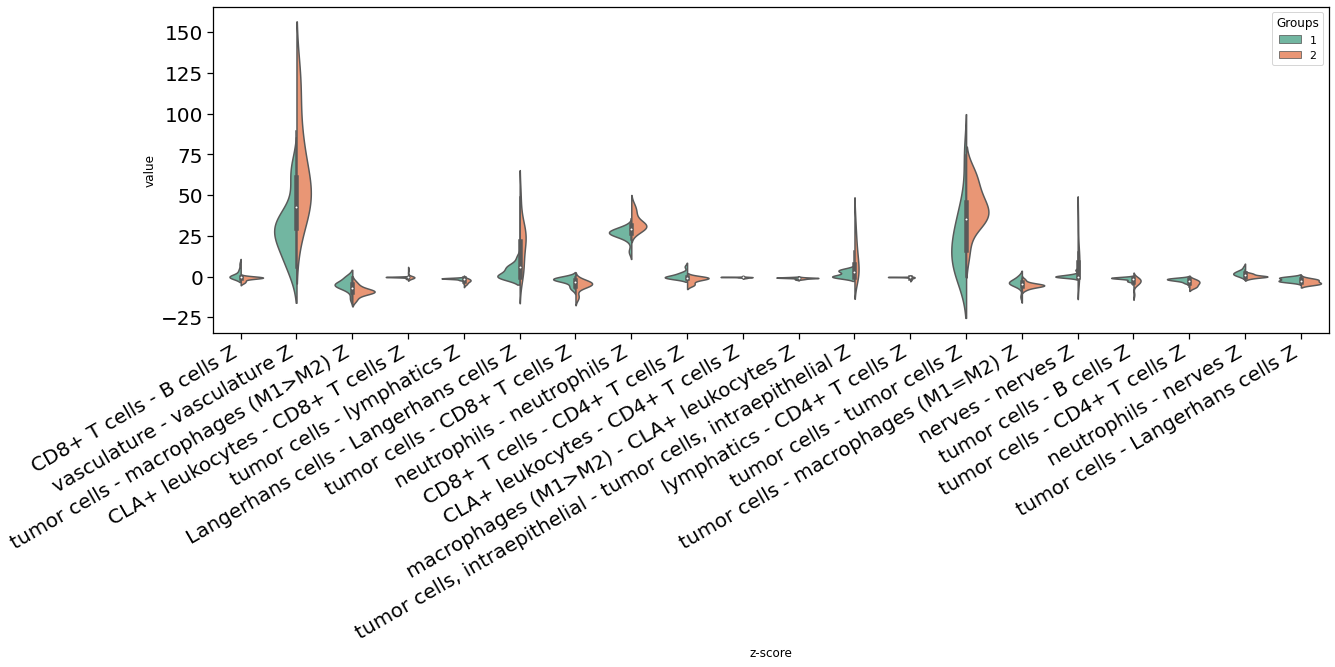

In [38]:
reload(mosna)
fig, ax = mosna.plot_distrib_groups(
    z_net_stats_cleaned, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    var_name='z-score',
    )

Some variables hide the distribution of other variables by their much larger range, we can exclude them to better see the other variables:

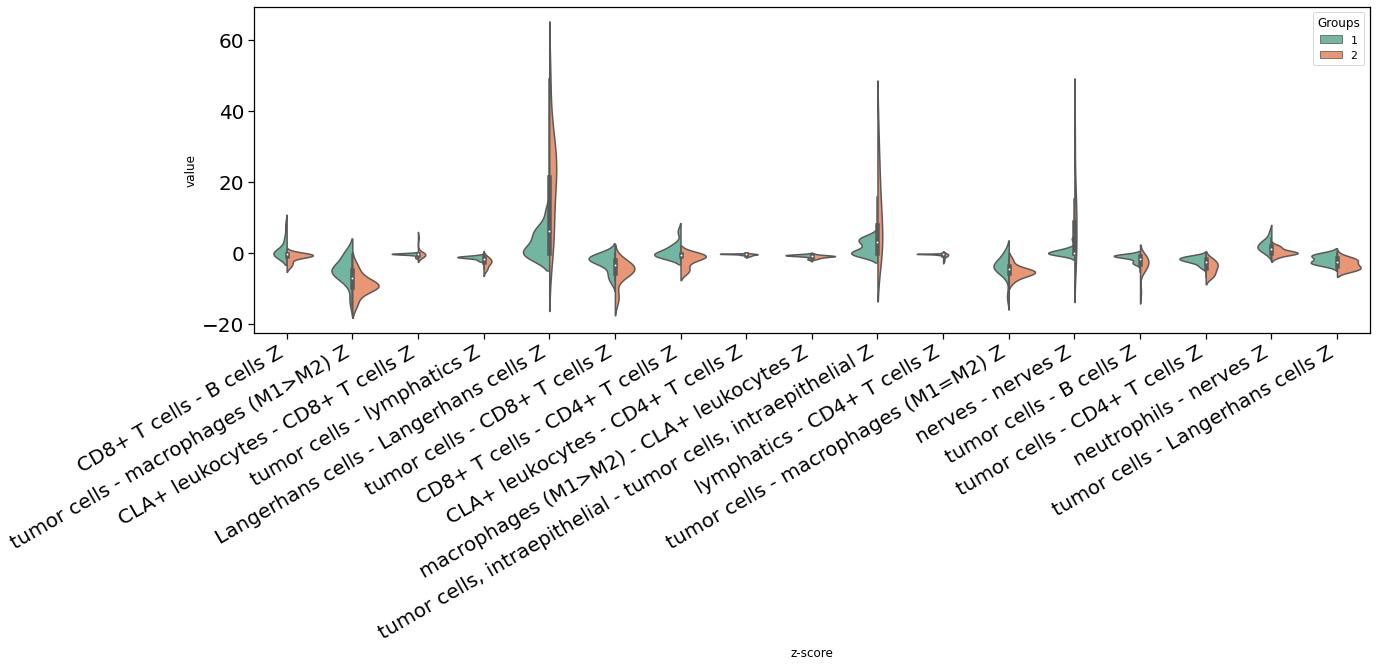

In [39]:
exclude_vars = [
    'assort Z',
    'vasculature - vasculature Z',
    'neutrophils - neutrophils Z',
    'tumor cells - tumor cells Z',
]
fig, ax = mosna.plot_distrib_groups(
    z_net_stats_cleaned, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    var_name='z-score',
    exclude_vars=exclude_vars,
    )

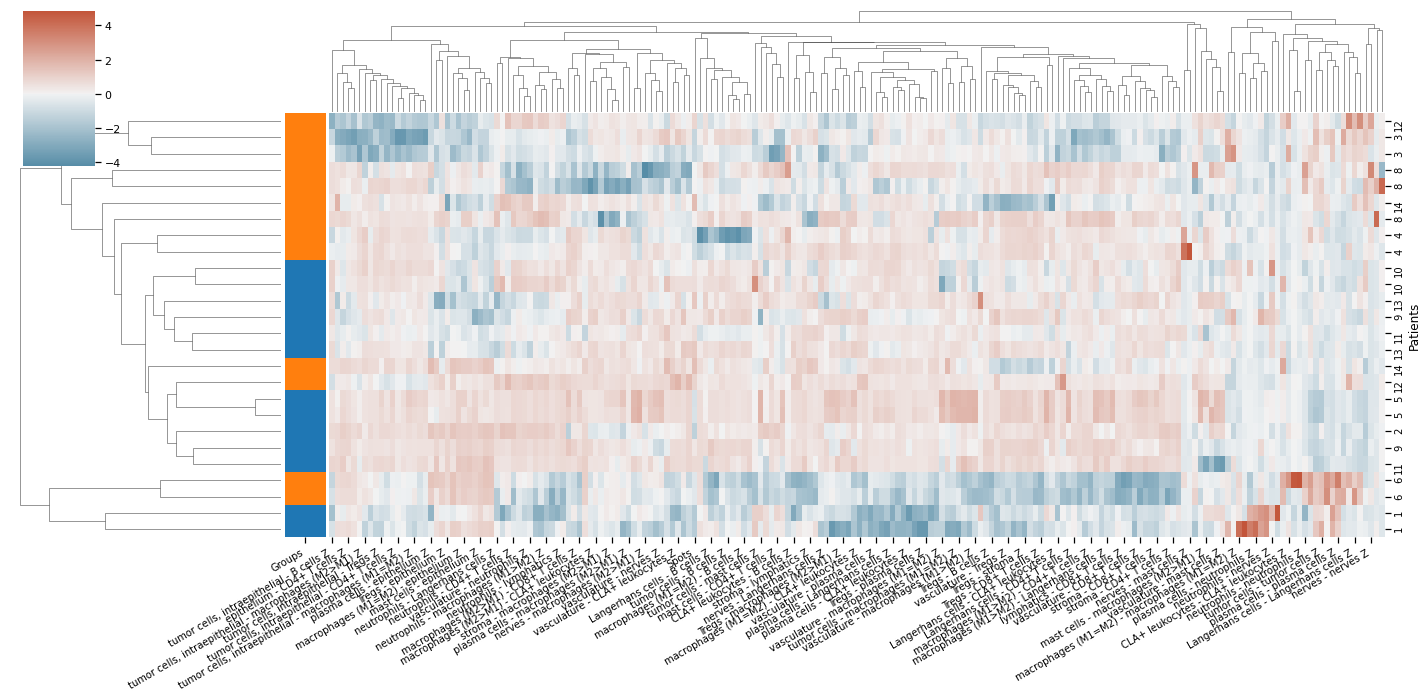

In [40]:
mosna.plot_heatmap(
    z_net_stats_cleaned, 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(20, 12),
    skip_cols=['assort Z'],
    )

Samples are a bit clustered into consistent response groups, but it's not incredible.  
We also need to aggregate samples per patient and time of biopsy, that may help us correcting nan values and have more variables, and hopefully better clusters.

#### Samples aggregation per patient and time point.

In [41]:
z_net_stats = pd.concat([status, z_net_stats], axis=1, join='inner')#.sort_values('Spots')
# z_net_stats.drop(columns=['Spots'], inplace=True)

In [42]:
# good news: the mean of aggregated data already ignores nans
z_net_stats_agg = z_net_stats.groupby(['Patients', 'Groups']).mean()
z_net_stats_agg

Spots    assort Z  B cells - B cells Z  \
Patients Groups                                           
1        1         1.5  127.765069             1.035724   
2        1         5.5   32.858849            -0.177131   
3        2         9.5  138.616416                  NaN   
4        2        13.5   93.038644            45.875689   
5        1        17.5   32.987587                  NaN   
6        2        21.5  135.110854             8.737449   
7        2        25.5   19.212448                  NaN   
8        2        30.0   97.791916            -0.220003   
9        1        35.5   73.818112                  NaN   
10       1        39.5   92.129112            -0.089098   
11       1        41.5   57.383863            -0.044766   
12       2        45.5   92.459723             1.679651   
13       1        51.5   88.939489            -0.067284   
14       2        57.5   93.829961             2.978600   

                 CD4+ T cells - B cells Z  CD4+ T cells - CD4+ T cells Z  \
Patients Groups                                                            
1        1                       0.631040                       4.902911   
2        1                      -0.257600                      -0.127515   
3        2                      -0.553307                      24.884557   
4        2                      -0.469180                       1.022058   
5        1                            NaN                            NaN   
6        2                       5.091435                      28.393471   
7        2                            NaN                            NaN   
8        2                      -0.000031                      12.226180   
9        1                      -0.127273                       7.693680   
10       1                       2.411048                       2.199037   
11       1                            NaN                      13.915332   
12       2                       2.815254                      15.350211   
13       1                       1.254496                      10.823608   
14       2                       2.700585                       9.848897   

                 CD8+ T cells - B cells Z  CD8+ T cells - CD4+ T cells Z  \
Patients Groups                                                            
1        1                       6.003038                       1.823127   
2        1                      -0.280056                      -0.201949   
3        2                      -0.529696                      -3.575596   
4        2                      -1.638282                      -0.664937   
5        1                            NaN                            NaN   
6        2                      -3.510018                      -5.323816   
7        2                            NaN                            NaN   
8        2                      -0.388645                      -0.541957   
9        1                      -0.216220                      -0.653556   
10       1                       1.320280                       3.977240   
11       1                      -0.135388                      -0.600945   
12       2                      -0.775285                      -1.416192   
13       1                      -0.173186                      -0.536489   
14       2                      -0.714705                      -1.219656   

                 CD8+ T cells - CD8+ T cells Z  CLA+ leukocytes - B cells Z  \
Patients Groups                                                               
1        1                           18.625760                    -0.493305   
2        1                           12.910897                    -0.181818   
3        2                           32.704188                    -0.119159   
4        2                            8.211085                          NaN   
5        1                                 NaN                          NaN   
6        2                           15.450405                    -0.524361   
7     

In [43]:
# Have a look at nan values
for name, value in z_net_stats_agg.isna().sum().iteritems():
    print(name, ' ' * (52- len(name)), value)

Spots                                                 0
assort Z                                              0
B cells - B cells Z                                   4
CD4+ T cells - B cells Z                              3
CD4+ T cells - CD4+ T cells Z                         2
CD8+ T cells - B cells Z                              2
CD8+ T cells - CD4+ T cells Z                         2
CD8+ T cells - CD8+ T cells Z                         2
CLA+ leukocytes - B cells Z                           6
CLA+ leukocytes - CD4+ T cells Z                      5
CLA+ leukocytes - CD8+ T cells Z                      5
CLA+ leukocytes - CLA+ leukocytes Z                   6
DCs, CD11c+ - B cells Z                               13
DCs, CD11c+ - CD4+ T cells Z                          12
DCs, CD11c+ - CD8+ T cells Z                          12
DCs, CD11c+ - CLA+ leukocytes Z                       13
DCs, CD11c+ - DCs, CD11c+ Z                           14
epithelium - B cells Z                     

(array([95., 40., 19., 15., 21.,  1.,  1., 17., 17.,  7.]),
 array([0.        , 0.04827586, 0.09655172, 0.14482759, 0.19310345,
        0.24137931, 0.28965517, 0.33793103, 0.3862069 , 0.43448276,
        0.48275862]),
 <BarContainer object of 10 artists>)

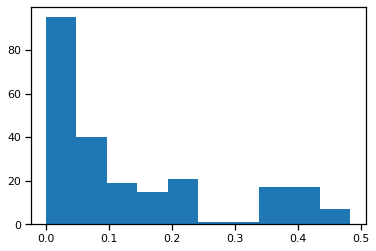

In [44]:
plt.hist(z_net_stats_agg.isna().sum(axis=0) / z_net_stats.shape[0])

In [45]:
pd.set_option('display.max_rows', 20)
z_net_stats_agg.isna().sum(axis=1) / z_net_stats_agg.shape[1]

Patients  Groups
1         1         0.175966
2         1         0.180258
3         2         0.188841
4         2         0.334764
5         1         0.592275
6         2         0.094421
7         2         0.806867
8         2         0.184549
9         1         0.356223
10        1         0.257511
11        1         0.347639
12        2         0.094421
13        1         0.175966
14        2         0.107296
dtype: float64

There are some nan values due to interactions between rare cell types that never happened.  
Can can have a first look at the sample, but it would be more informative to have a look at samples before therapy, grouping them per patient.

In [46]:
print("Original z_net_stats_agg shape:", z_net_stats_agg.shape)
z_net_agg_cleaned, select_finite = mosna.clean_data(
    z_net_stats_agg, 
    method='mixed',
    thresh=0.9,
    )
print("Final z_net_stats_agg shape:", z_net_agg_cleaned.shape)

Original z_net_stats_agg shape: (14, 233)
There are 908 non finite values
Imputing data
Final z_net_stats_agg shape: (14, 226)


In [47]:
pvals = mosna.find_DE_markers(z_net_agg_cleaned.iloc[:, 1:], group_ref=2, group_tgt=1, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

In [48]:
pvals.head(20)

pval  pval_corr
neutrophils - neutrophils Z                         0.000583   0.131119
tumor cells, intraepithelial - tumor cells, int...  0.008159   0.397727
CD8+ T cells - B cells Z                            0.008159   0.397727
tumor cells, intraepithelial - B cells Z            0.008159   0.397727
assort Z                                            0.053030   0.397727
lymphatics - CD4+ T cells Z                         0.053030   0.397727
lymphatics - DCs, CD11c+ Z                          0.053030   0.397727
macrophages (M1=M2) - DCs, CD11c+ Z                 0.053030   0.397727
macrophages (M1>M2) - DCs, CD11c+ Z                 0.053030   0.397727
macrophages (M2>M1) - DCs, CD11c+ Z                 0.053030   0.397727
mast cells - DCs, CD11c+ Z                          0.053030   0.397727
nerves - DCs, CD11c+ Z                              0.053030   0.397727
nerves - nerves Z                                   0.053030   0.397727
stroma - DCs, CD11c+ Z                              0.053030   0.397727
Langerhans cells - Langerhans cells Z               0.053030   0.397727
Tregs - DCs, CD11c+ Z                               0.053030   0.397727
tumor cells - CD4+ T cells Z                        0.053030   0.397727
tumor cells - DCs, CD11c+ Z                         0.053030   0.397727
tumor cells - lymphatics Z                          0.053030   0.397727
tumor cells - macrophages (M1>M2) Z                 0.053030   0.397727

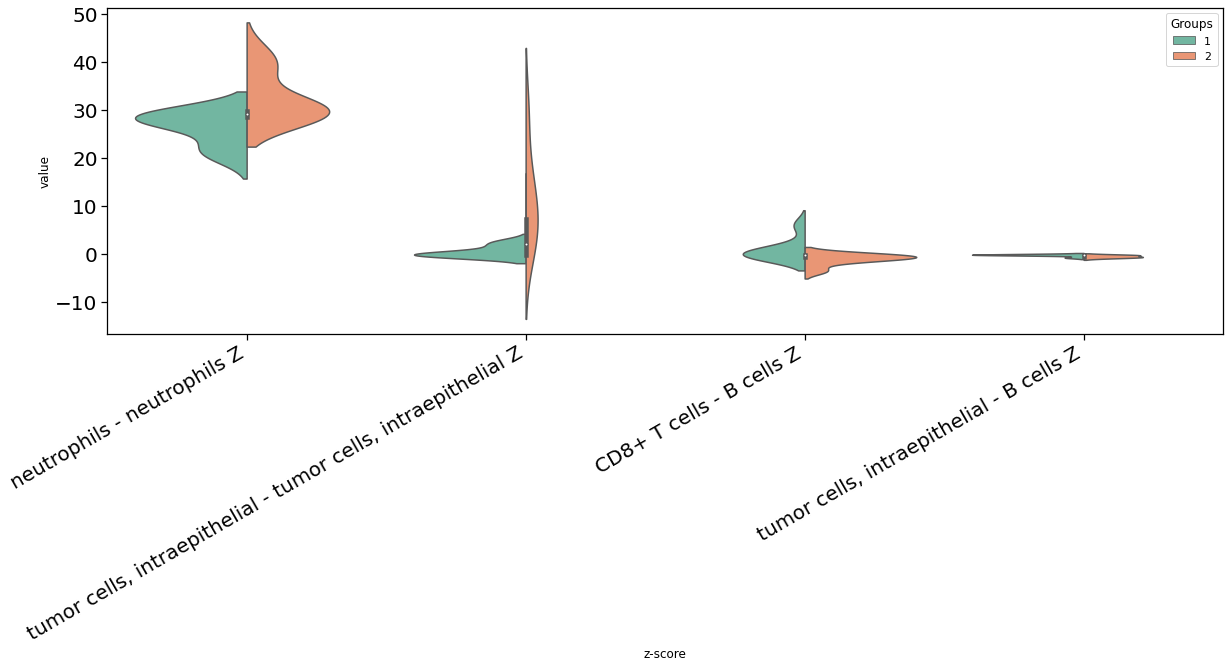

In [49]:
fig, ax = mosna.plot_distrib_groups(
    z_net_agg_cleaned, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    var_name='z-score',
    )

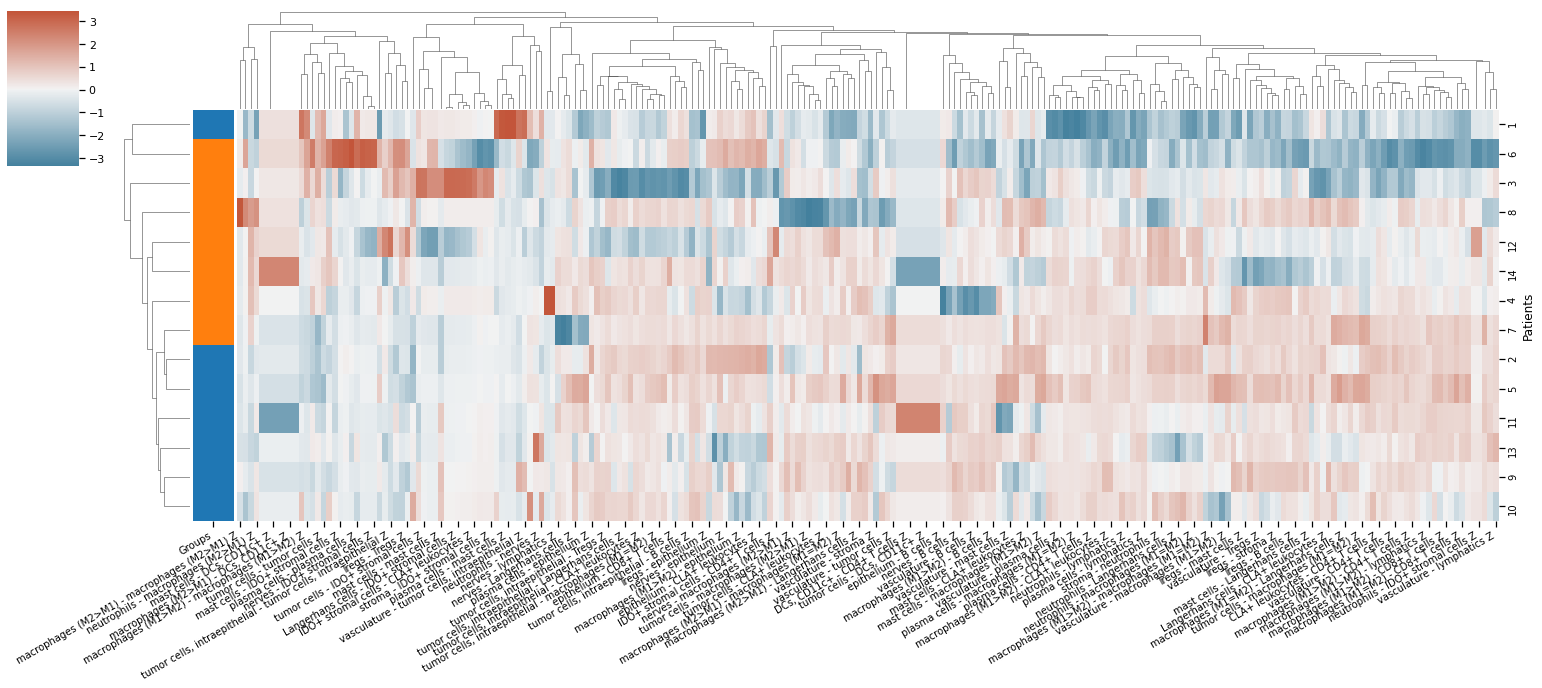

In [50]:
mosna.plot_heatmap(
    z_net_agg_cleaned.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(20, 12),
    dendrogram_ratio=[0.05, 0.2],
    cbar_pos=(-0.07, 0.8, 0.05, 0.18)
    )
plt.savefig(save_dir / "assortativity_z-scored_clustering-patients", bbox_inches='tight', facecolor='white')

In [155]:
# mosna.plot_heatmap(
#     z_net_agg_cleaned.reset_index(), 
#     obs_labels='Patients', 
#     group_var='Groups', 
#     groups=[1, 2],
#     figsize=(80, 12),
#     dendrogram_ratio=[0.05, 0.2],
#     cbar_pos=(-0.07, 0.8, 0.05, 0.18)
#     )
# plt.savefig(save_dir / "assortativity_z-scored_clustering-patients_wide", bbox_inches='tight', facecolor='white')

#### Logistic regression on interaction coefficients

In [ ]:
# # use the most statistically relevant variable separating groups
# # Note: that's to have a clue, do not use this method for real,
# # it's a tautology!

# nb_vars = np.sum(pvals['pval'] <= 0.06)
# nb_vars = min(nb_vars, 20)
# marker_vars = pvals.sort_values(by='pval', ascending=True).head(nb_vars).index.tolist()

# mosna.plot_heatmap(
#     z_net_agg_cleaned[marker_vars].reset_index(), 
#     obs_labels='Patients', 
#     group_var='Groups', 
#     groups=[1, 2],
#     figsize=(10, 10),
#     )

### Marker-positive cells interactions

We can also compute the mixing matrix and assortativity between marker-positive cells.

## Cellular neighborhoods

The mixing matrix and assortativity give us information about the global network organization.  
Here we will see how to use the *Neighbors Aggregation Statistics* method to find local "cellular communities", or "neighborhoods", or "niches", that can be relevant to understand disease progression or response to therapies.  

### On cell types

First order neighbors, mean and std

In [50]:
order = 1
var_type = 'cell-types'
stat_names = 'mean-std'
aggreg_vars = cell_type_cols

# For UMAP visualization
marker = '.'
size_points = 10

In [51]:
nas_dir = reconst_dir / f"nas_on-{var_type}_stats-{stat_names}_order-{order}"    
if not os.path.exists(nas_dir):
    os.makedirs(nas_dir)

In [52]:
# attrib_all = obj[cell_type_cols]
X = obj[aggreg_vars].values
edges_all = pd.read_csv(reconst_dir/ 'sample_all-edges.csv')
pairs = edges_all.values

In [53]:
filename = nas_dir / f'aggregation_statistics.csv'

if filename.exists():
    var_aggreg = pd.read_csv(filename)
else:
    var_aggreg = mosna.aggregate_k_neighbors(
        X=X,
        pairs=pairs,
        order=order,
        var_names=aggreg_vars,
    )
    var_aggreg.to_csv(filename, index=False)

In [54]:
n_neighbors = 70
metric = 'euclidean'
min_dist = 0.0

reducer = umap.UMAP(
    random_state=0,
    n_neighbors=n_neighbors,
    metric=metric,
    min_dist=min_dist,
    # we don't modify the other parameters
    # spread=1.0,
    # set_op_mix_ratio=1.0,
    # local_connectivity=1.0,
    # repulsion_strength=1.0,
    # negative_sample_rate=5,
    # transform_queue_size=4.0,
    )
embedding = reducer.fit_transform(var_aggreg)
reducer_name = f"reducer-umap_nneigh-{n_neighbors}_metric-{metric}_min_dist-{min_dist}"
# save reduced coordinates
np.save(nas_dir / (reducer_name + '.npy'), embedding, allow_pickle=False, fix_imports=False)
# save the reducer object
joblib.dump(reducer, nas_dir / (reducer_name + '.pkl'))
embedding.shape

/home/alexis/.pyenv/versions/3.8.10/envs/spatial-networks/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


(117170, 2)

In [47]:
joblib.dump(reducer, str(nas_dir / (reducer_name + '.pkl')))

['../data/processed/CODEX_CTCL/all_samples_networks_xy_trim_dist-percentile_size_solitary-0/nas_on-cell-types_stats-mean-std_order-1/reducer-umap_nneigh-70_metric-euclidean_min_dist-0.0.pkl']

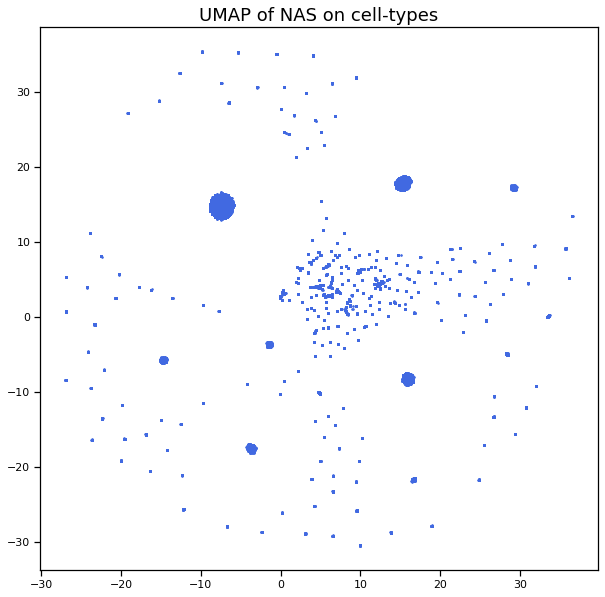

In [48]:
plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c='royalblue', marker=marker, s=size_points)
title = f"UMAP of NAS on {var_type}"
plt.title(title, fontsize=18);

#### Screen NAS parameters

In [ ]:
from importlib import reload
reload(mosna)

orders = [1]
dim_clusts = [2, 3, 4, 5, 6, 7, 8, 9]
min_cluster_sizes = [100, 250, 500, 750, 1000]
parallel_dim = 'max'
parallel_clustering = 4
processed_dir = Path('../data/processed/CODEX_CTCL')
opt_str = '_samples-all_stat-mean-std'
save_dir = 'test-parallel'

mosna.screen_nas_parameters(X, pairs, markers, orders, dim_clusts, min_cluster_sizes, processed_dir, save_dir=save_dir, soft_clustering=True, 
                            opt_str=opt_str, parallel_dim=parallel_dim, parallel_clustering=parallel_clustering, memory_limit='800GB')


#### Clusters visualization

dim_clust: 2
    min_cluster_size: 100


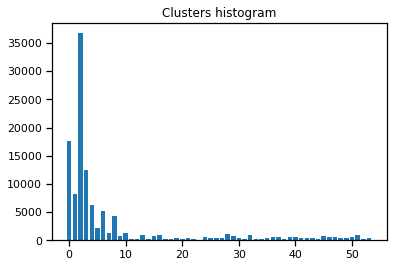

No handles with labels found to put in legend.


        sample: 1


In [188]:
reload(mosna)

orders = [1]
dim_clusts = [2, 3, 4, 5, 6, 7, 8, 9]
min_cluster_sizes = [100, 250, 500, 750, 1000]
processed_dir = Path('../data/processed/CODEX_CTCL')
opt_str = '_samples-all_stat-mean-std'

mosna.plot_screened_parameters(obj, cell_pos_cols, cell_type_cols, orders, dim_clusts, processed_dir,
                               min_cluster_sizes, all_edges='all_samples_networks', sampling=False, var_type=None, 
                               downsample=False, aggreg_dir=None, load_dir=None, save_dir=None, opt_str=opt_str)

### On markers

In [51]:
order = 1
var_type = 'markers'
stat_names = 'mean-std'
aggreg_vars = marker_cols

# For UMAP visualization
marker = '.'
size_points = 10

In [52]:
nas_dir = reconst_dir / f"nas_on-{var_type}_stats-{stat_names}_order-{order}"    
if not os.path.exists(nas_dir):
    os.makedirs(nas_dir)

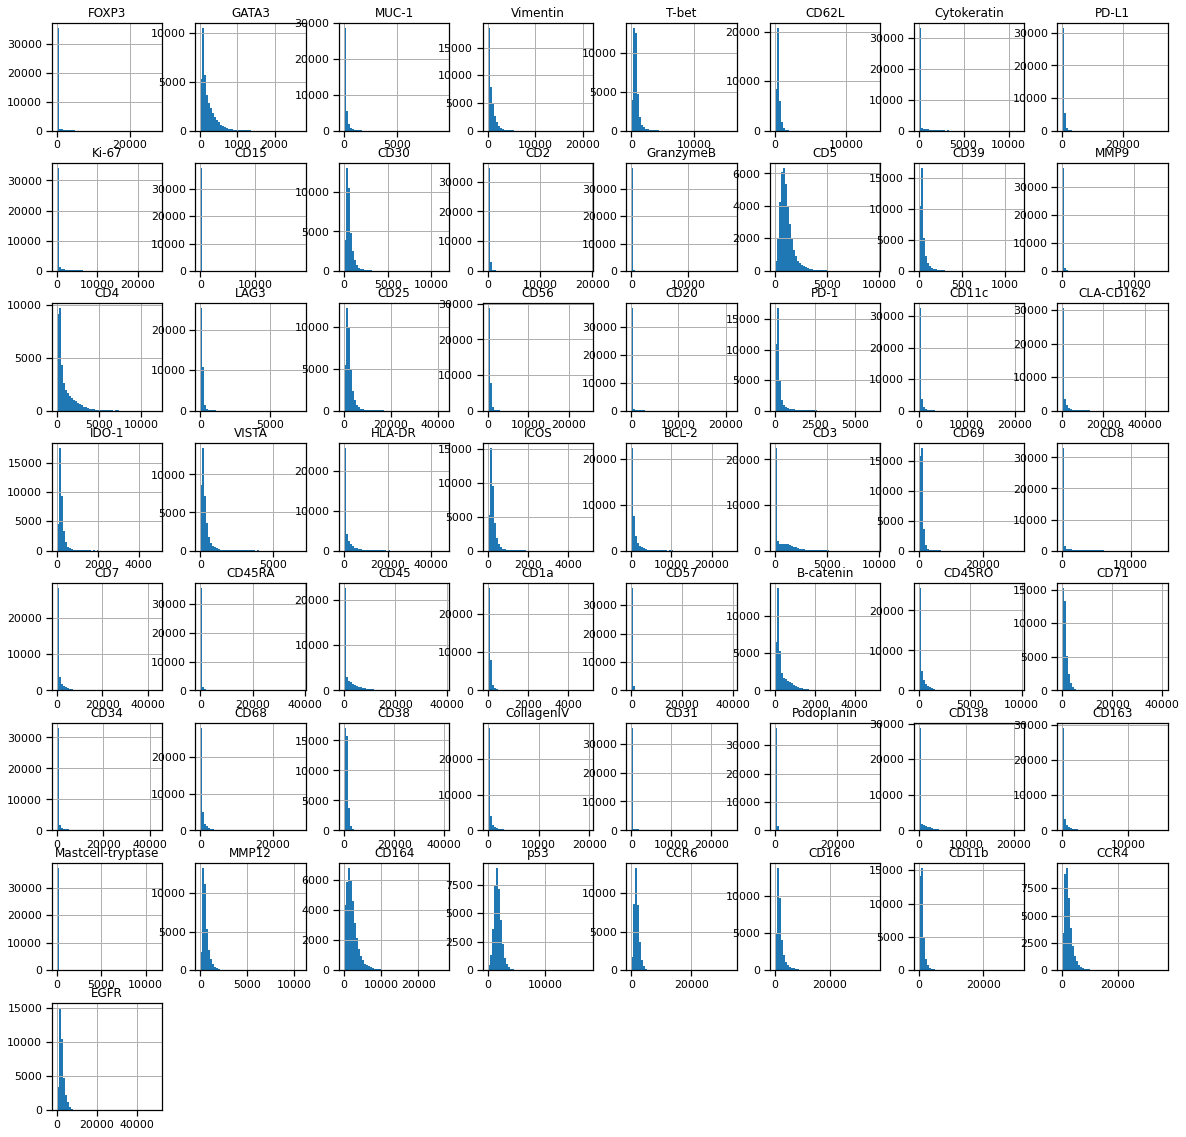

In [53]:
obj[aggreg_vars].hist(bins=50, figsize=(20, 20));

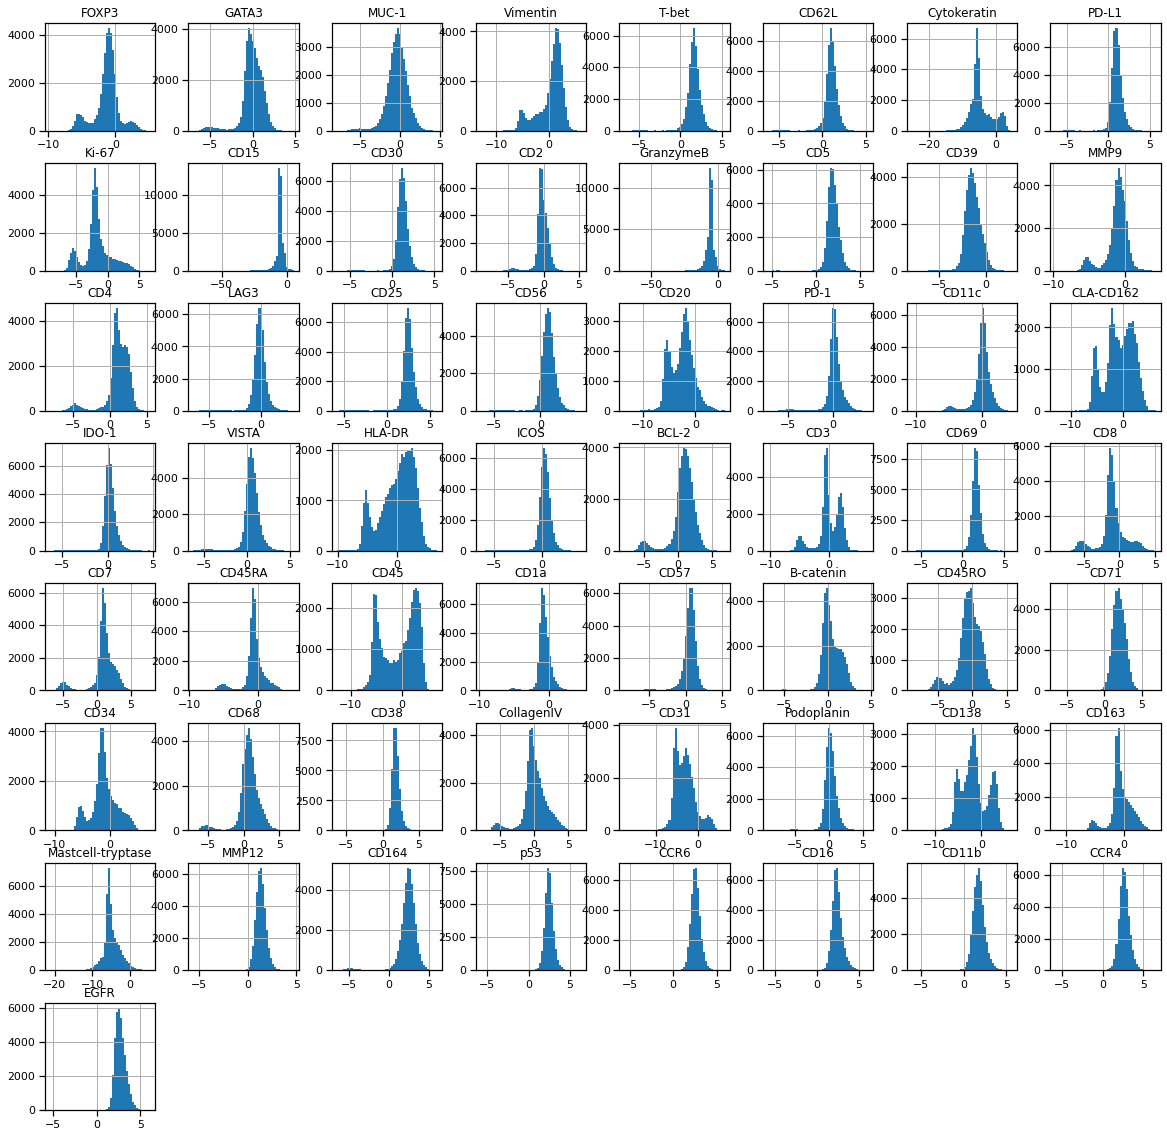

In [54]:
X = obj[aggreg_vars].values
X[X == 0] = X.max() / 100000

X_clr = cs.clr(cs.closure(X))
aggreg_vars_clr = obj[aggreg_vars].copy()
aggreg_vars_clr.loc[:, :] = X_clr
aggreg_vars_clr.hist(bins=50, figsize=(20, 20));

In [55]:
edges_all = pd.read_csv(reconst_dir/ 'all_samples-edges.csv')
pairs = edges_all.values

In [56]:
file_path = nas_dir / f'aggregation_statistics.csv'

if file_path.is_file():
    print("Loading Neighbors Aggregation Statistics file")
    var_aggreg = pd.read_csv(file_path)
else:
    print("Computing Neighbors Aggregation Statistics")
    var_aggreg = mosna.aggregate_k_neighbors(
        X=X_clr,
        pairs=pairs,
        order=order,
        var_names=aggreg_vars,
    )
    var_aggreg.to_csv(file_path, index=False)

Loading Neighbors Aggregation Statistics file


In [57]:
embedding, reducer = mosna.get_reducer(
    data=var_aggreg, 
    save_dir=nas_dir,
    reducer_type='umap', 
    n_neighbors=15, 
    metric='euclidean', 
    min_dist=0.0,
    )

Loading reducer object and reduced coordinates


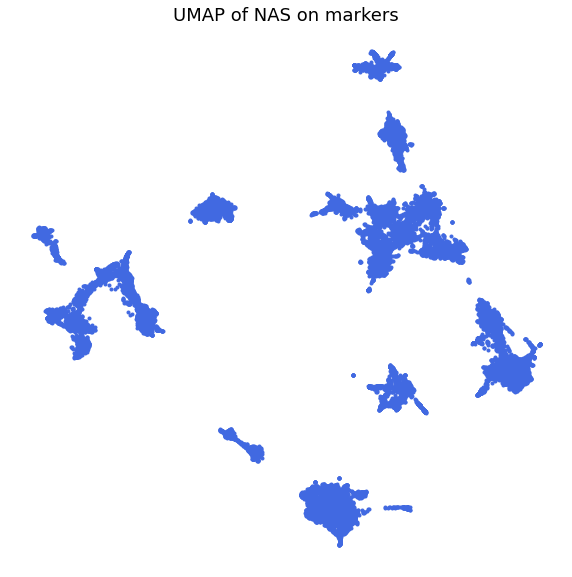

In [58]:
mosna.plot_clusters(embedding)
title = f"UMAP of NAS on {var_type}"
plt.title(title, fontsize=18);

#### Leinden clustering

Test:
  - reducer-umap_dim-2_nneigh-75_metric-euclidean_min_dist-0.0/clusterer-leiden_n_neighbors-15/biclustering_resolution-0.05_normalized-clr
  - reducer-umap_dim-2_nneigh-75_metric-euclidean_min_dist-0.0/clusterer-leiden_n_neighbors-15/biclustering_resolution-0.05_normalized-obs

In [63]:
cluster_params = {
    'reducer_type': 'umap', 
    'n_neighbors': 75, 
    'metric': 'euclidean', 
    'min_dist': 0.0,
    'clusterer_type': 'leiden', 
    'dim_clust': 2, 
    'k_cluster': 15, 
    'resolution_parameter': 0.05,
}

cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)

Loading clusterer object and cluster labels
There are 17 clusters


In [64]:
nas_dir

PosixPath('../data/processed/CODEX_CTCL/pretreatment_samples_networks_xy_trim_dist-200_solitary-0/nas_on-markers_stats-mean-std_order-1')

Loading reducer object and reduced coordinates


(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

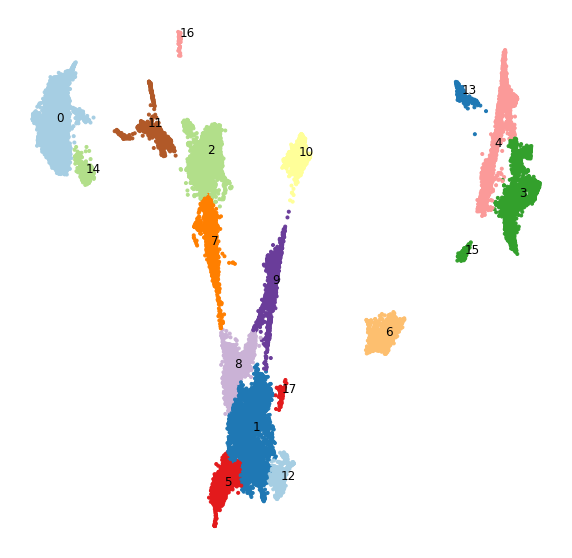

In [65]:
embed_viz, _ = mosna.get_reducer(var_aggreg, nas_dir, reducer_type='umap', n_neighbors=cluster_params['n_neighbors'])
mosna.plot_clusters(embed_viz, cluster_labels, nas_dir, cluster_params=cluster_params)

#### Screen clustering parameters

In [ ]:
# for dim_clust in tqdm([2, 3, 4, 5], leave=False):
for dim_clust in tqdm([2], leave=False):
    for n_neighbors in tqdm([15, 45, 75, 100, 200], leave=False):
        for metric in tqdm(['euclidean', 'cosine'], leave=False):
            for k_cluster in tqdm([15, 50], leave=False):
                cluster_params = {
                    'reducer_type': 'umap', 
                    'n_neighbors': n_neighbors, 
                    'metric': metric,
                    'min_dist': 0.0,
                    'clusterer_type': 'leiden', 
                    'dim_clust': dim_clust, 
                    'k_cluster': 15, 
                    'resolution_parameter': 0.005,
                }

                cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)
                
                embed_viz, _ = mosna.get_reducer(
                    var_aggreg, 
                    nas_dir, 
                    reducer_type='umap', 
                    n_neighbors=n_neighbors, 
                    metric=metric,
                    )
                
                mosna.plot_clusters(embed_viz, cluster_labels, nas_dir, cluster_params=cluster_params)

Loading clusterer object and cluster labels
There are 23 clusters
Loading reducer object and reduced coordinates


(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

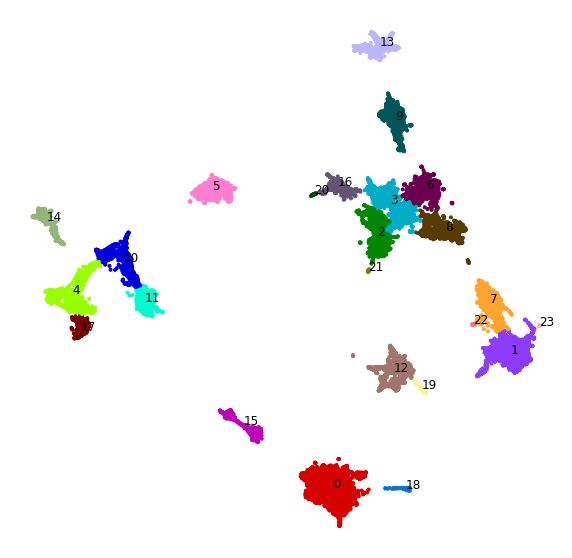

In [62]:
cluster_params = {
    'reducer_type': 'umap', 
    'n_neighbors': 15, 
    'metric': 'euclidean',
    'min_dist': 0.0,
    'clusterer_type': 'leiden', 
    'dim_clust': 2, 
    'k_cluster': 15, 
    'resolution_parameter': 0.05,
}

cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)

embed_viz, _ = mosna.get_reducer(
    var_aggreg, 
    nas_dir, 
    reducer_type='umap', 
    n_neighbors=15, 
    metric='euclidean',
    )

mosna.plot_clusters(embed_viz, cluster_labels, nas_dir, cluster_params=cluster_params)

Loading clusterer object and cluster labels
There are 18 clusters
Loading reducer object and reduced coordinates


(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

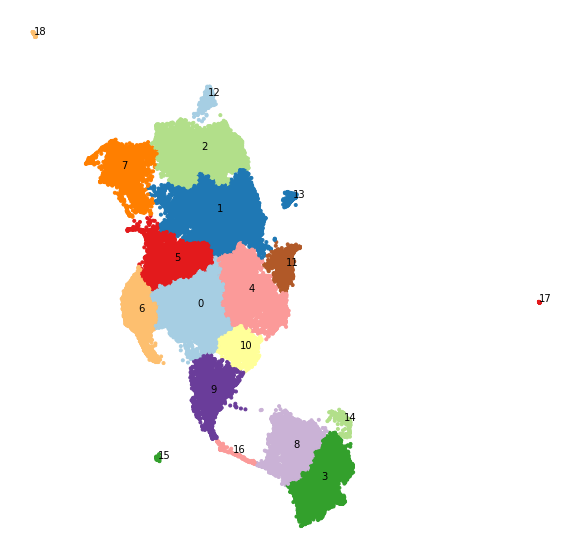

In [ ]:
cluster_params = {
    'reducer_type': 'umap', 
    'n_neighbors': 15, 
    'metric': 'euclidean',
    'min_dist': 0.0,
    'clusterer_type': 'leiden', 
    'dim_clust': 2, 
    'k_cluster': 15, 
    'resolution_parameter': 0.05,
}

cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)

embed_viz, _ = mosna.get_reducer(
    var_aggreg, 
    nas_dir, 
    reducer_type='umap', 
    n_neighbors=15, 
    metric='euclidean',
    )

mosna.plot_clusters(embed_viz, cluster_labels, nas_dir, cluster_params=cluster_params)

In [29]:
# Merge some small adjacent clusters
# merge_dict = {
#     19: 18,
#     21: 17,
#     24: 1,
#     # 23: 1,
#     # 25: 1,
# }
merge_dict = {
    20: 2,
    18: 16,
    19: 16,
    # 23: 1,
    # 25: 1,
}
for old, new in merge_dict.items():
    cluster_labels[cluster_labels == old] = new
    
# rename clusters ordered by size
class_id, class_count = np.unique(cluster_labels, return_counts=True)


In [30]:
# rename clusters ordered by size
class_id, class_count = np.unique(cluster_labels, return_counts=True)
decreasing_counts_ids = np.argsort(class_count)[::-1]
new_ids = np.arange(len(class_id))[decreasing_counts_ids]
for old, new in zip(class_id, new_ids):
    cluster_labels[cluster_labels == old] = new

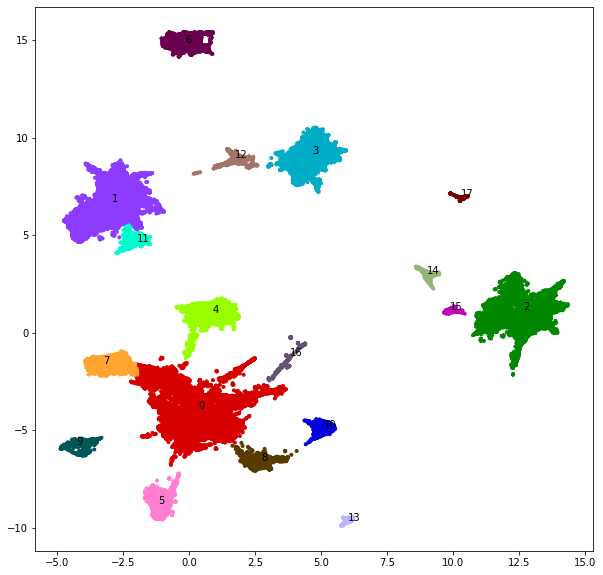

In [31]:
embed_viz = embedding

# choose colormap
if nb_clust < 20:
    clusters_cmap = sns.color_palette('Paired', 20)
    cluster_colors = [clusters_cmap[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in cluster_labels]
else:
    clusters_cmap = cc.palette["glasbey"]
    # make color mapper
    # series to sort by decreasing order
    uniq = pd.Series(cluster_labels).value_counts().index.astype(int)
    n_colors = len(clusters_cmap)
    labels_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}
    labels_color_mapper[-1] = (0.5, 0.5, 0.5)
    cluster_colors = [labels_color_mapper[x] for x in cluster_labels]

plt.figure(figsize=(10,10))
plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=cluster_colors, marker='.');

for clust_id in np.unique(cluster_labels):
    clust_targ = cluster_labels == clust_id
    x_mean = embed_viz[clust_targ, 0].mean()
    y_mean = embed_viz[clust_targ, 1].mean()
    plt.text(x_mean, y_mean, str(clust_id))

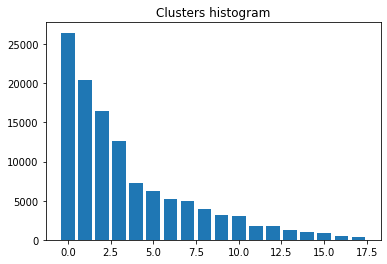

In [32]:
class_id, class_count = np.unique(cluster_labels, return_counts=True)
plt.bar(class_id, class_count, width=0.8);
plt.title('Clusters histogram');

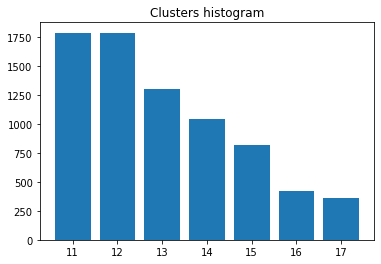

In [33]:
class_id, class_count = np.unique(cluster_labels[cluster_labels > 10], return_counts=True)
plt.bar(class_id, class_count, width=0.8);
plt.title('Clusters histogram');

In [34]:
other_str = '_manual-cleaning'

clusterer_name = f"partition-{'RBConfigurationVertexPartition'}_resolution-{resolution_parameter}{other_str}"
file_path = cluster_dir / clusterer_name

# save cluster labels
np.save(str(file_path) + '.npy', cluster_labels, allow_pickle=False, fix_imports=False)

#### HDBSCAN clustering

In [65]:
n_neighbors = 70
metric = 'euclidean'
min_dist = 0.0

reducer_name = f"reducer-umap_nneigh-{n_neighbors}_metric-{metric}_min_dist-{min_dist}"
file_path = nas_dir / reducer_name
if os.path.exists(str(file_path) + '.npy'):
    print("Loading reducer object and reduced coordinates")
    embedding = np.load(str(file_path) + '.npy')
    reducer = joblib.load(str(file_path) + '.pkl')
else:
    print("Computing dimensionality reduction")
    reducer = umap.UMAP(
        random_state=0,
        n_neighbors=n_neighbors,
        metric=metric,
        min_dist=min_dist,
        )
    embedding = reducer.fit_transform(var_aggreg)
    # save reduced coordinates
    np.save(str(file_path) + '.npy', embedding, allow_pickle=False, fix_imports=False)
    # save the reducer object
    joblib.dump(reducer, str(file_path) + '.pkl');


Computing dimensionality reduction


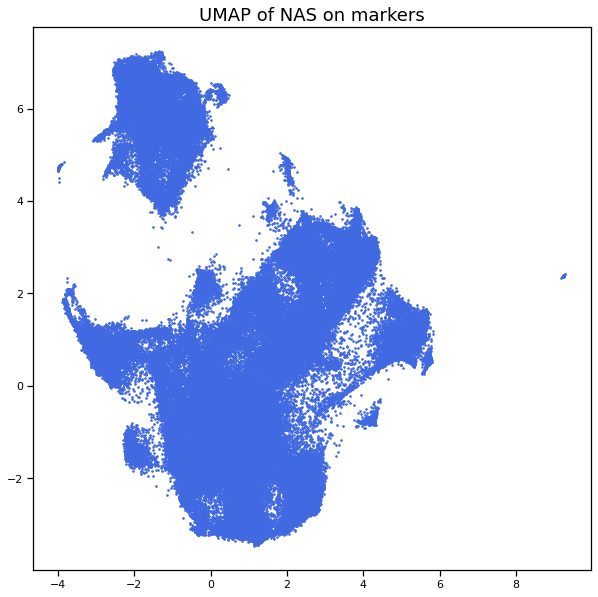

In [66]:
plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c='royalblue', marker=marker, s=size_points)
title = f"UMAP of NAS on {var_type}"
plt.title(title, fontsize=18);

In [58]:
dim_clust = 2
min_samples = 10
min_cluster_size = 2000
epsilon = 0.0 # cluster_selection_epsilon=0.0 by default
# soft_clustering = False or 'knn' or 'proba'
soft_clustering = False 
parallel_clustering = 16
force_recompute = False

cluster_dir = nas_dir / f"clusterer-HDBSCAN_dim_clust-{dim_clust}_min_samples-{min_samples}"   
if not os.path.exists(cluster_dir):
    os.makedirs(cluster_dir)

clusterer_name = f"min_cluster_size-{min_cluster_size}_epsilon-{epsilon}_soft_clustering-{soft_clustering}"
file_path = cluster_dir / clusterer_name
cache_dir = cluster_dir / 'memory_cache'

if os.path.exists(str(file_path) + '.npy') and not force_recompute:
    print("Loading clusterer object and cluster labels")
    cluster_labels = np.load(str(file_path) + '.npy')
    clusterer = joblib.load(str(file_path) + '.pkl')
    nb_clust = cluster_labels.max() # + 1
else:
    print("Performing clustering")
    # select embedded data
    embed_clust = embedding
    # Clustering
    start = time()
    if soft_clustering is False or soft_clustering == 'knn':
        clusterer = hdbscan.HDBSCAN( 
            min_cluster_size=min_cluster_size, 
            min_samples=min_samples,
            cluster_selection_epsilon=epsilon,
            core_dist_n_jobs=parallel_clustering,
            memory=cache_dir.as_posix(),
        )
        clusterer.fit(embed_clust)
        cluster_labels = clusterer.labels_

        # replace points with label -1 to closest labels in the UMAP space
        if soft_clustering == 'knn':
            cluster_labels = cluster_labels.astype(float)
            # set labels -1 to nan
            select = cluster_labels == -1
            cluster_labels[select] = np.nan
            # perform data imputation
            imputer = KNNImputer(n_neighbors=5, weights="distance")
            cluster_labels = imputer.fit_transform(cluster_labels.reshape(-1, 1)).flatten()
            # set to 0/1 the imputed categorical variables
            cluster_labels = cluster_labels.round().astype(int)
            
    # use max proba of labels different from -1
    # it can lead to very different clustering for unknow reason so far
    elif soft_clustering == 'proba':
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size, 
            min_samples=min_samples, 
            cluster_selection_epsilon=epsilon,
            prediction_data=True, 
            core_dist_n_jobs=parallel_clustering,
            memory=cache_dir.as_posix(),
        )
        clusterer.fit(embed_clust)
        soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
        if len(soft_clusters.shape) > 1:
            # set to 0 the probability of being noise
            if -1 in np.unique(clusterer.labels_):
                soft_clusters[:, 0] = 0
            cluster_labels = soft_clusters.argmax(axis=1)
        else:
            cluster_labels = soft_clusters

    end = time()
    duration = end - start
    nb_clust = cluster_labels.max() # + 1
    print("HDBSCAN has detected {} clusters in {:.2f}s".format(nb_clust, duration))
    # save cluster labels
    np.save(str(file_path) + '.npy', cluster_labels, allow_pickle=False, fix_imports=False)
    # save the reducer object
    joblib.dump(clusterer, str(file_path) + '.pkl');
nb_clust = cluster_labels.max() # + 1

Performing clustering
HDBSCAN has detected 10 clusters in 5.33s


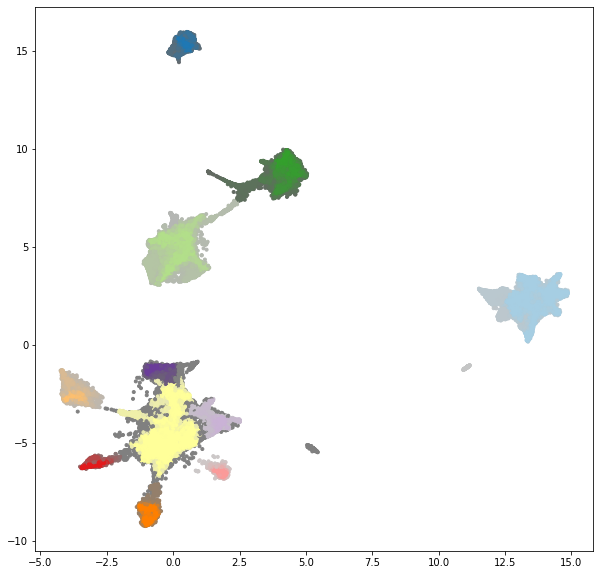

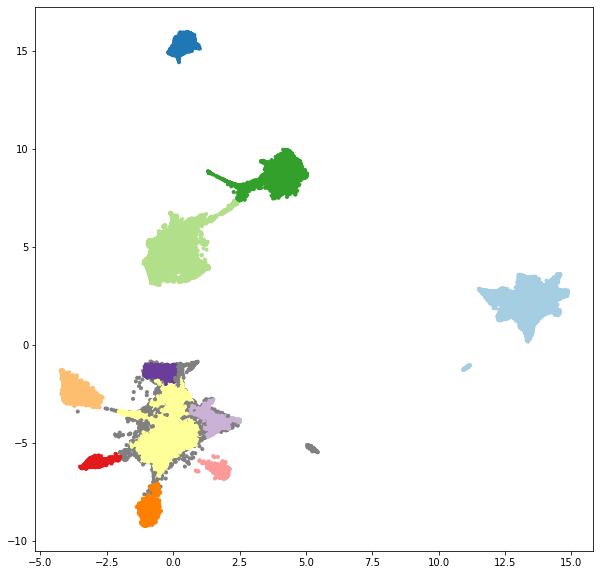

In [59]:
embed_viz = embedding

# make a cohort-wide cmap
clusters_cmap = cc.palette["glasbey_category10"]
# make color mapper
# series to sort by decreasing order
uniq = pd.Series(cluster_labels).value_counts().index.astype(int)
n_colors = len(clusters_cmap)
labels_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}
# make list of colors
labels_colors = [labels_color_mapper[x] for x in cluster_labels]
labels_colors = pd.Series(labels_colors)

# choose colormap
if nb_clust <= 20:
    clusters_cmap = sns.color_palette('Paired', 20)
    cluster_colors = [clusters_cmap[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in clusterer.labels_]
else:
    clusters_cmap = cc.palette["glasbey"]
    # make color mapper
    # series to sort by decreasing order
    uniq = pd.Series(cluster_labels).value_counts().index.astype(int)
    n_colors = len(clusters_cmap)
    labels_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}
    labels_color_mapper[-1] = (0.5, 0.5, 0.5)
    cluster_colors = [labels_color_mapper[x] for x in cluster_labels]

cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

plt.figure(figsize=(10,10))
# plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=labels_colors, marker='.');
plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=cluster_member_colors, marker='.');

plt.figure(figsize=(10,10))
# plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=labels_colors, marker='.');
plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=cluster_colors, marker='.');

That looks good, let's add soft clustering.

In [62]:
dim_clust = 2
min_samples = 10
min_cluster_size = 2000
epsilon = 0.0 # cluster_selection_epsilon=0.0 by default
# soft_clustering = False or 'knn' or 'proba'
soft_clustering = 'knn' 
parallel_clustering = 16
force_recompute = False

cluster_dir = nas_dir / f"clusterer-HDBSCAN_dim_clust-{dim_clust}_min_samples-{min_samples}"   
if not os.path.exists(cluster_dir):
    os.makedirs(cluster_dir)

clusterer_name = f"min_cluster_size-{min_cluster_size}_epsilon-{epsilon}_soft_clustering-{soft_clustering}"
file_path = cluster_dir / clusterer_name
cache_dir = cluster_dir / 'memory_cache'

if os.path.exists(str(file_path) + '.npy') and not force_recompute:
    print("Loading clusterer object and cluster labels")
    cluster_labels = np.load(str(file_path) + '.npy')
    clusterer = joblib.load(str(file_path) + '.pkl')
    nb_clust = cluster_labels.max() # + 1
else:
    print("Performing clustering")
    # select embedded data
    embed_clust = embedding
    # Clustering
    start = time()
    if soft_clustering is False or soft_clustering == 'knn':
        clusterer = hdbscan.HDBSCAN( 
            min_cluster_size=min_cluster_size, 
            min_samples=min_samples,
            cluster_selection_epsilon=epsilon,
            core_dist_n_jobs=parallel_clustering,
            memory=cache_dir.as_posix(),
        )
        clusterer.fit(embed_clust)
        cluster_labels = clusterer.labels_

        # replace points with label -1 to closest labels in the UMAP space
        if soft_clustering == 'knn':
            cluster_labels = cluster_labels.astype(float)
            # set labels -1 to nan
            select = cluster_labels == -1
            cluster_labels[select] = np.nan
            # perform data imputation
            imputer = KNNImputer(n_neighbors=5, weights="distance")
            cluster_labels = imputer.fit_transform(cluster_labels.reshape(-1, 1)).flatten()
            # set to 0/1 the imputed categorical variables
            cluster_labels = cluster_labels.round().astype(int)
            
    # use max proba of labels different from -1
    # it can lead to very different clustering for unknow reason so far
    elif soft_clustering == 'proba':
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size, 
            min_samples=min_samples, 
            cluster_selection_epsilon=epsilon,
            prediction_data=True, 
            core_dist_n_jobs=parallel_clustering,
            memory=cache_dir.as_posix(),
        )
        clusterer.fit(embed_clust)
        soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
        if len(soft_clusters.shape) > 1:
            # set to 0 the probability of being noise
            if -1 in np.unique(clusterer.labels_):
                soft_clusters[:, 0] = 0
            cluster_labels = soft_clusters.argmax(axis=1)
        else:
            cluster_labels = soft_clusters

    end = time()
    duration = end - start
    nb_clust = cluster_labels.max() # + 1
    print("HDBSCAN has detected {} clusters in {:.2f}s".format(nb_clust, duration))
    # save cluster labels
    np.save(str(file_path) + '.npy', cluster_labels, allow_pickle=False, fix_imports=False)
    # save the reducer object
    joblib.dump(clusterer, str(file_path) + '.pkl'.as_posix());
nb_clust = cluster_labels.max() # + 1

Performing clustering
HDBSCAN has detected 10 clusters in 17.62s


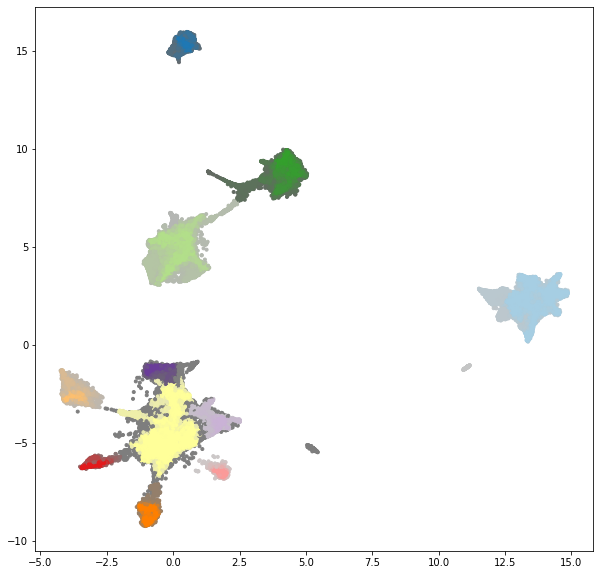

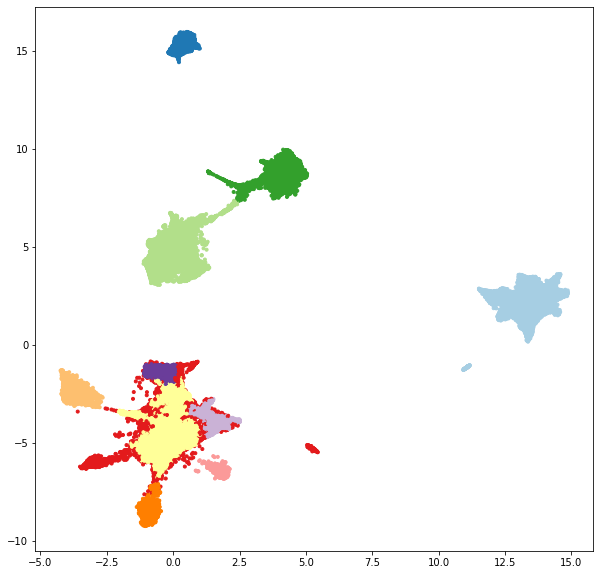

In [63]:
embed_viz = embedding

# make a cohort-wide cmap
clusters_cmap = cc.palette["glasbey_category10"]
# make color mapper
# series to sort by decreasing order
uniq = pd.Series(cluster_labels).value_counts().index.astype(int)
n_colors = len(clusters_cmap)
labels_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}
# make list of colors
labels_colors = [labels_color_mapper[x] for x in cluster_labels]
labels_colors = pd.Series(labels_colors)

# choose colormap
if nb_clust <= 20:
    clusters_cmap = sns.color_palette('Paired', 20)
    cluster_colors = [clusters_cmap[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in cluster_labels]
else:
    clusters_cmap = cc.palette["glasbey"]
    # make color mapper
    # series to sort by decreasing order
    uniq = pd.Series(cluster_labels).value_counts().index.astype(int)
    n_colors = len(clusters_cmap)
    labels_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}
    labels_color_mapper[-1] = (0.5, 0.5, 0.5)
    cluster_colors = [labels_color_mapper[x] for x in cluster_labels]

cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

plt.figure(figsize=(10,10))
# plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=labels_colors, marker='.');
plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=cluster_member_colors, marker='.');

plt.figure(figsize=(10,10))
# plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=labels_colors, marker='.');
plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=cluster_colors, marker='.');

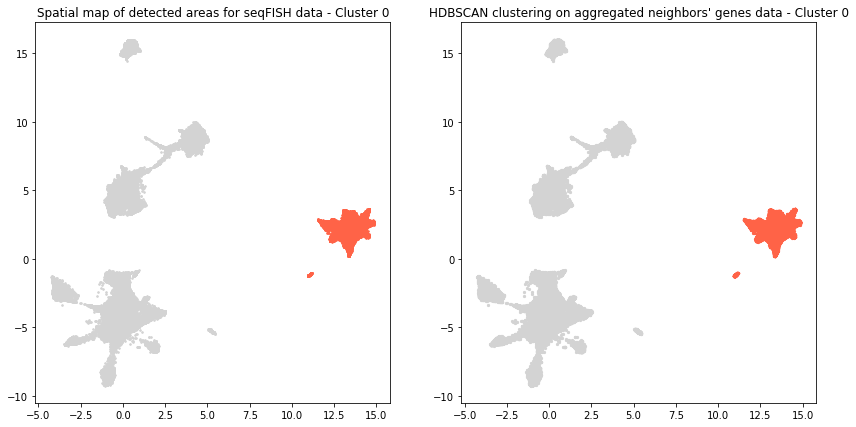

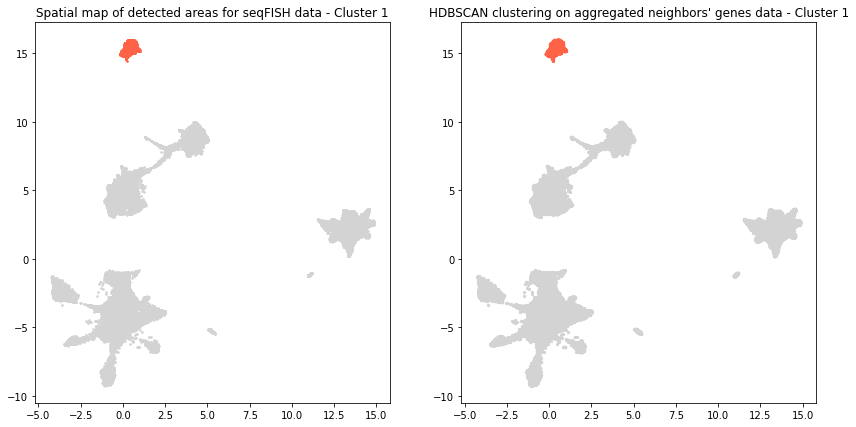

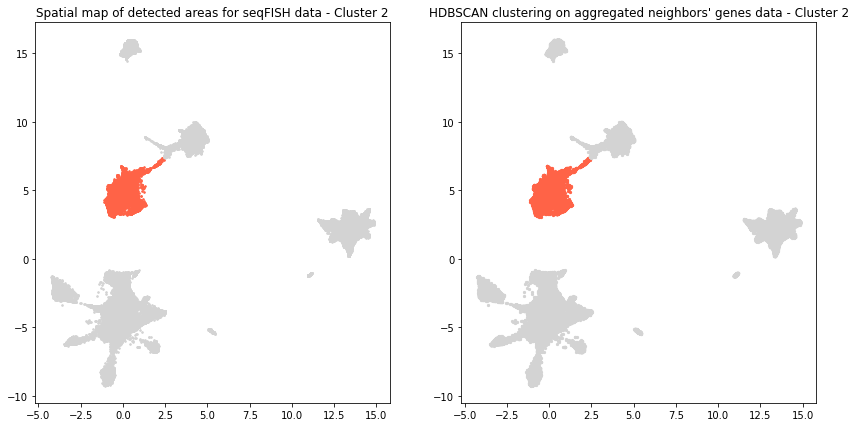

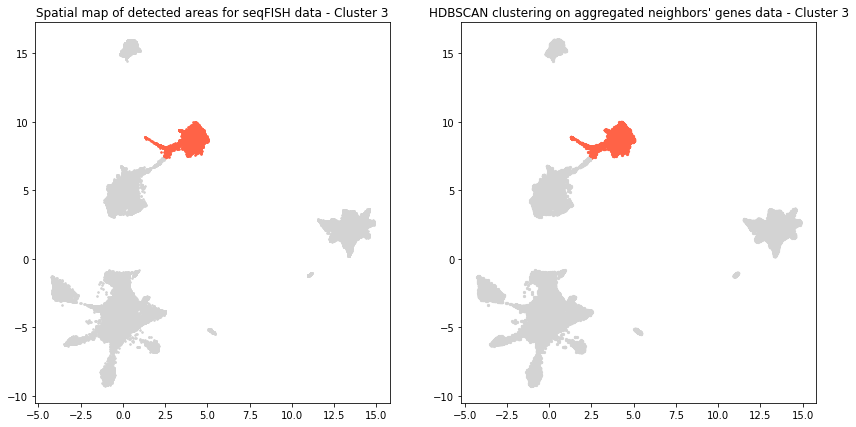

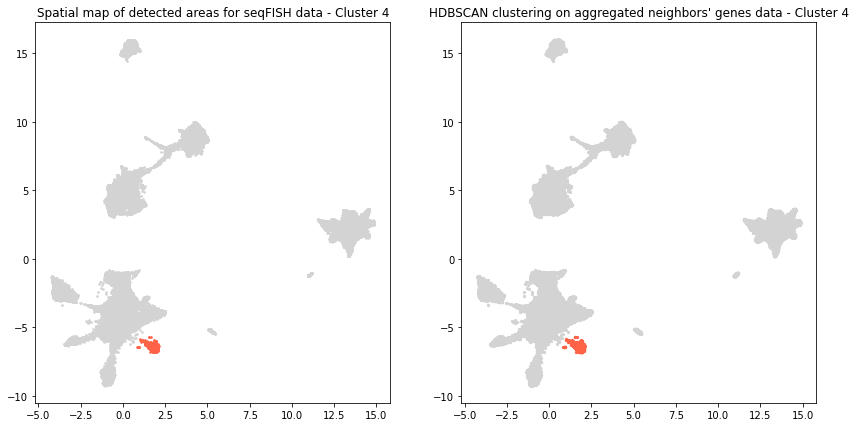

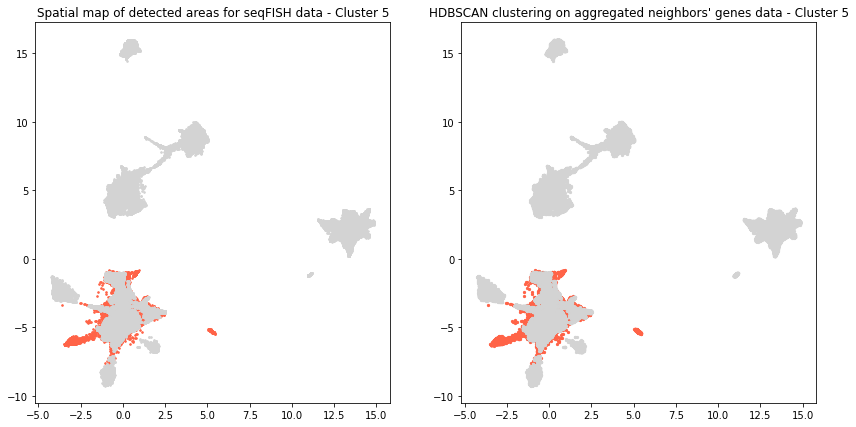

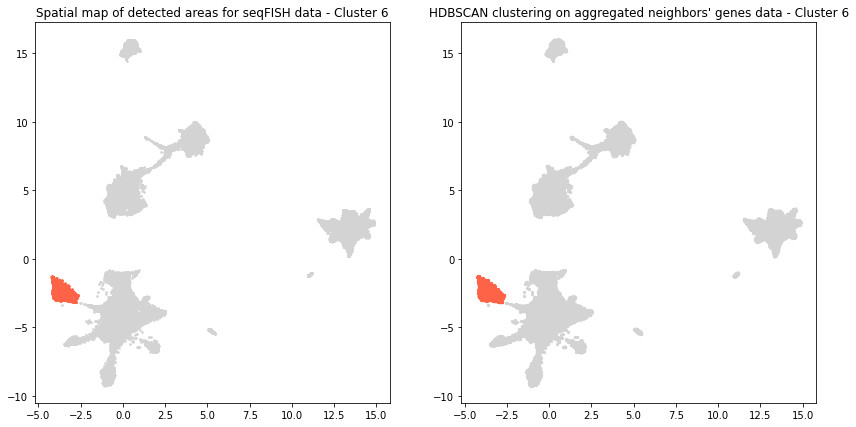

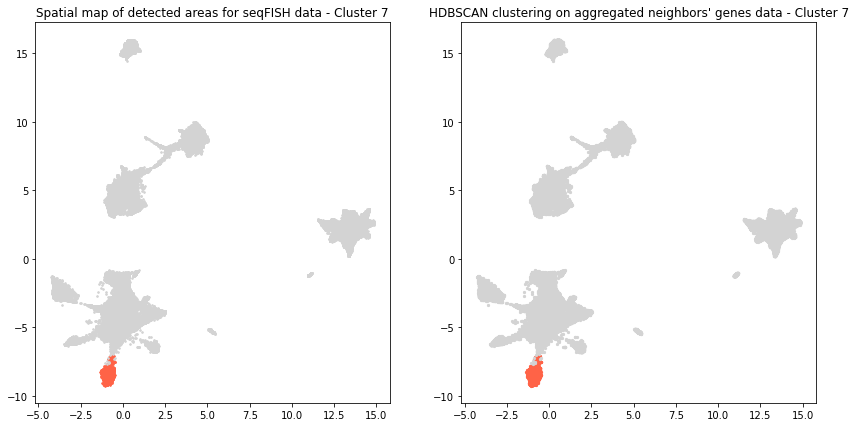

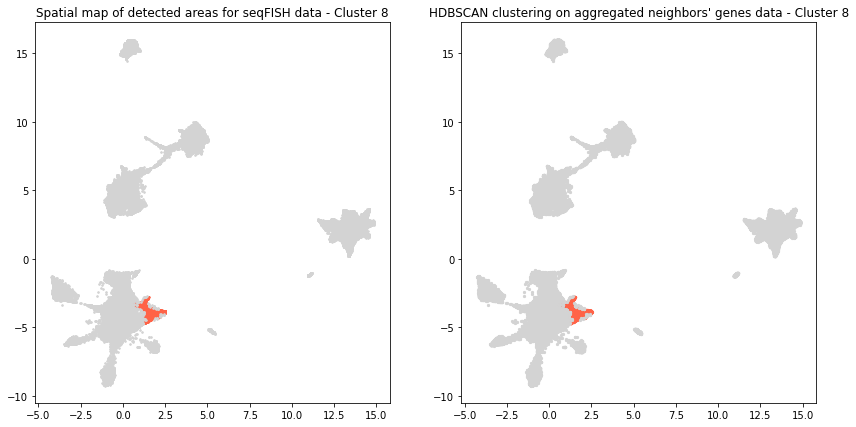

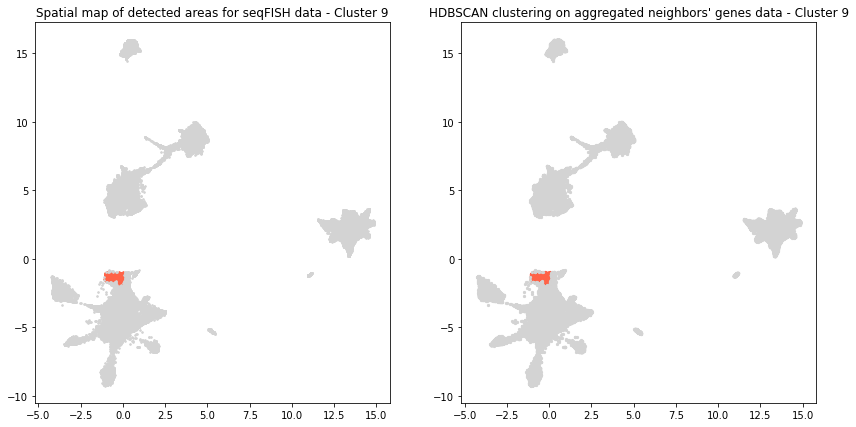

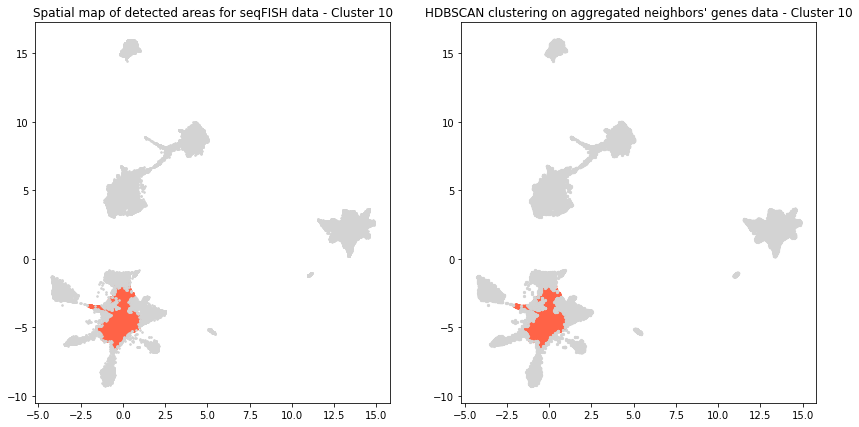

In [64]:
for clust_id in np.unique(cluster_labels):
    clust_targ = cluster_labels == clust_id  # cluster of interest (target)
    clust_comp = cluster_labels != clust_id  # cluster(s) we compare with

    fig, ax = plt.subplots(1, 2, figsize=(14,7), tight_layout=False)

    ax[0].scatter(embed_viz[clust_targ,0], embed_viz[clust_targ,1], c='tomato', marker=marker, s=size_points)
    ax[0].scatter(embed_viz[clust_comp,0], embed_viz[clust_comp,1], c='lightgrey', marker=marker, s=size_points)
    ax[0].set_title('Spatial map of detected areas for seqFISH data - Cluster '+str(clust_id), fontsize=12);
    
    ax[1].scatter(embed_viz[clust_targ, 0], embed_viz[clust_targ, 1], s=5, c='tomato');
    ax[1].scatter(embed_viz[clust_comp, 0], embed_viz[clust_comp, 1], s=5, c='lightgrey');
    ax[1].set_title("HDBSCAN clustering on aggregated neighbors' genes data - Cluster "+str(clust_id), fontsize=12);
    plt.show()

It seems impossible to ave a partition that makes sense, there are really wrong cluster labeling.

#### Leiden clustering using Scanpy

In [78]:
# Leiden requires an iGraph object
# we could use a network produced by UMAP
# but it's more straightforward to use Scanpy

import anndata as ad
import scanpy as sc

adata = ad.AnnData(X_clr)
adata.var_names = aggreg_vars
adata

/tmp/ipykernel_19796/2195255581.py:4: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X_clr)


AnnData object with n_obs × n_vars = 117170 × 57

In [ ]:
# Computing the neighborhood graph
sc.pp.neighbors(adata)
# sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [ ]:
# sc.tl.paga(adata)
# sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
# sc.tl.umap(adata, init_pos='paga')

In [ ]:
# Embedding the neighborhood graph
sc.tl.umap(adata)

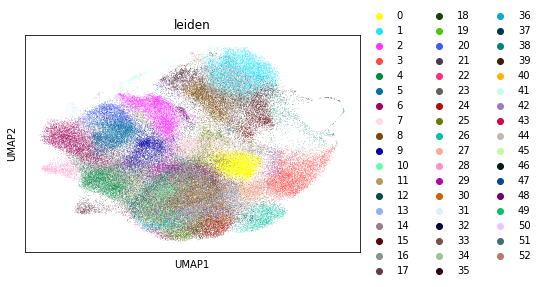

In [ ]:
# Clustering the neighborhood graph
sc.tl.leiden(adata, resolution=2)
sc.pl.umap(adata, color=['leiden'])

The UMAP projected data doesn't look promising.  
Let's try our own UMAP projection.

#### Leiden clustering using scikit knn on UMAP data

In [30]:
import igraph as ig
import leidenalg as la

k_cluster = 15
nas_coords = embedding
nas_pairs = ty.build_knn(nas_coords, k=k_cluster)

G = ty.to_iGraph(nas_coords, nas_pairs, attributes=None)

partition = la.find_partition(G, la.RBConfigurationVertexPartition, resolution_parameter=0.01)
# partition = la.find_partition(G, la.CPMVertexPartition, resolution_parameter=0.00001)
cluster_labels = np.array(partition.membership)
nb_clust = cluster_labels.max()
print(f"Found {nb_clust} clusters")

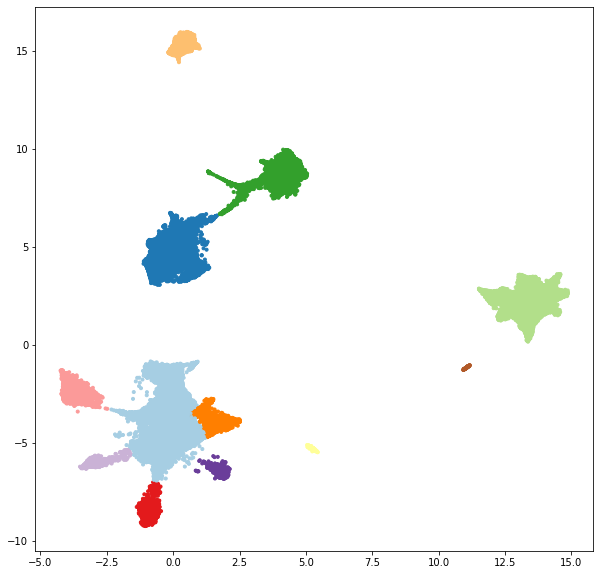

In [65]:
embed_viz = embedding

# choose colormap
if nb_clust <= 20:
    clusters_cmap = sns.color_palette('Paired', 20)
    cluster_colors = [clusters_cmap[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in cluster_labels]
else:
    clusters_cmap = cc.palette["glasbey"]
    # make color mapper
    # series to sort by decreasing order
    uniq = pd.Series(cluster_labels).value_counts().index.astype(int)
    n_colors = len(clusters_cmap)
    labels_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}
    labels_color_mapper[-1] = (0.5, 0.5, 0.5)
    cluster_colors = [labels_color_mapper[x] for x in cluster_labels]

plt.figure(figsize=(10,10))
# plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=labels_colors, marker='.');
plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=cluster_colors, marker='.');

That looks great, we'll do the same with n_neighbors=15, see above.

#### On markers, order 2

In [40]:
order = 2
nas_dir = reconstruction_dir / f"nas_on-{var_type}_stats-{stat_names}_order-{order}"    
if not os.path.exists(nas_dir):
    os.makedirs(nas_dir)

file_path = nas_dir / f'aggregation_statistics.csv'
if file_path.is_file():
    print("Loading Neighbors Aggregation Statistics file")
    var_aggreg = pd.read_csv(file_path)
else:
    print("Compouting Neighbors Aggregation Statistics")
    var_aggreg = mosna.aggregate_k_neighbors(
        X=X_clr,
        pairs=pairs,
        order=order,
        var_names=aggreg_vars,
    )
    var_aggreg.to_csv(file_path, index=False)

Loading Neighbors Aggregation Statistics file


In [ ]:
n_neighbors = 70
metric = 'euclidean'
min_dist = 0.0

reducer_name = f"reducer-umap_nneigh-{n_neighbors}_metric-{metric}_min_dist-{min_dist}"
file_path = nas_dir / reducer_name
if os.path.exists(str(file_path) + '.npy'):
    print("Loading reducer object and reduced coordinates")
    embedding = np.load(str(file_path) + '.npy')
    reducer = joblib.load(str(file_path) + '.pkl')
else:
    print("Computing dimensionality reduction")
    reducer = umap.UMAP(
        random_state=0,
        n_neighbors=n_neighbors,
        metric=metric,
        min_dist=min_dist,
        )
    embedding = reducer.fit_transform(var_aggreg)
    # save reduced coordinates
    np.save(str(file_path) + '.npy', embedding, allow_pickle=False, fix_imports=False)
    # save the reducer object
    joblib.dump(reducer, str(file_path) + '.pkl');

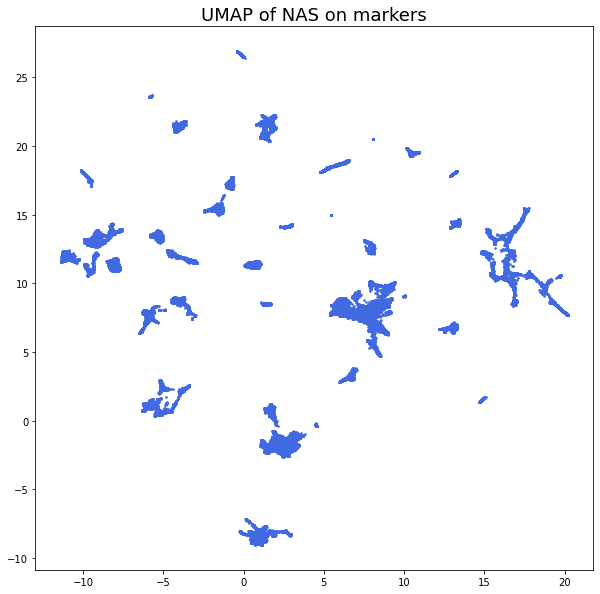

In [44]:
plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c='royalblue', marker=marker, s=size_points)
title = f"UMAP of NAS on {var_type}"
plt.title(title, fontsize=18);

In [45]:
n_neighbors = 100
metric = 'euclidean'
min_dist = 0.0

reducer_name = f"reducer-umap_nneigh-{n_neighbors}_metric-{metric}_min_dist-{min_dist}"
file_path = nas_dir / reducer_name
if os.path.exists(str(file_path) + '.npy'):
    print("Loading reducer object and reduced coordinates")
    embedding = np.load(str(file_path) + '.npy')
    reducer = joblib.load(str(file_path) + '.pkl')
else:
    print("Computing dimensionality reduction")
    reducer = umap.UMAP(
        random_state=0,
        n_neighbors=n_neighbors,
        metric=metric,
        min_dist=min_dist,
        )
    embedding = reducer.fit_transform(var_aggreg)
    # save reduced coordinates
    np.save(str(file_path) + '.npy', embedding, allow_pickle=False, fix_imports=False)
    # save the reducer object
    joblib.dump(reducer, str(file_path) + '.pkl')

Computing dimensionality reduction


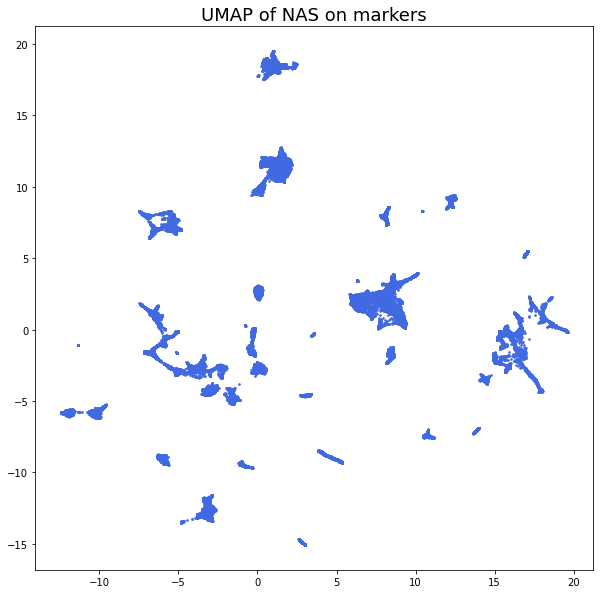

In [46]:
plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c='royalblue', marker=marker, s=size_points)
title = f"UMAP of NAS on {var_type}"
plt.title(title, fontsize=18);

## Survival analysis

We use labels from the Leiden clustering.

In [141]:
cell_types = nodes_all['CellCluster']
niches = cluster_labels

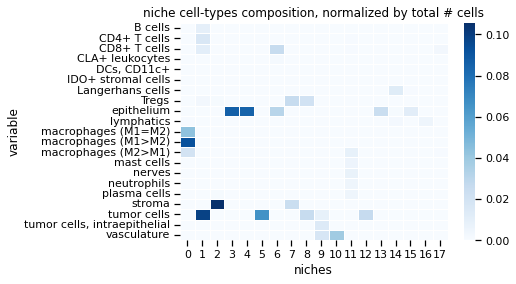

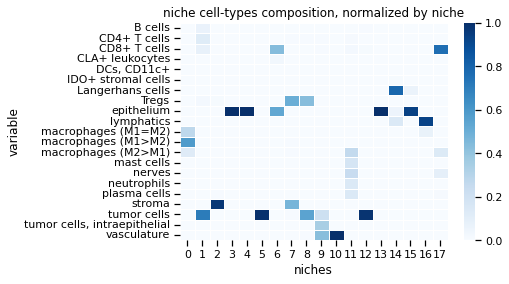

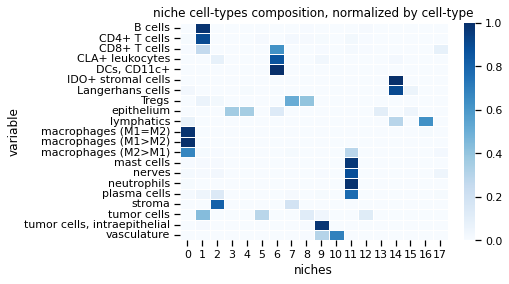

In [151]:
mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types')
title = "niche cell-types composition, normalized by total # cells"
plt.title(title)
plt.savefig(cluster_dir / title, bbox_inches='tight', facecolor='white')

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='niche')
title = "niche cell-types composition, normalized by niche"
plt.title(title)
plt.savefig(cluster_dir / title, bbox_inches='tight', facecolor='white')

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='obs')
title = "niche cell-types composition, normalized by cell-type"
plt.title(title)
plt.savefig(cluster_dir / title, bbox_inches='tight', facecolor='white')

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

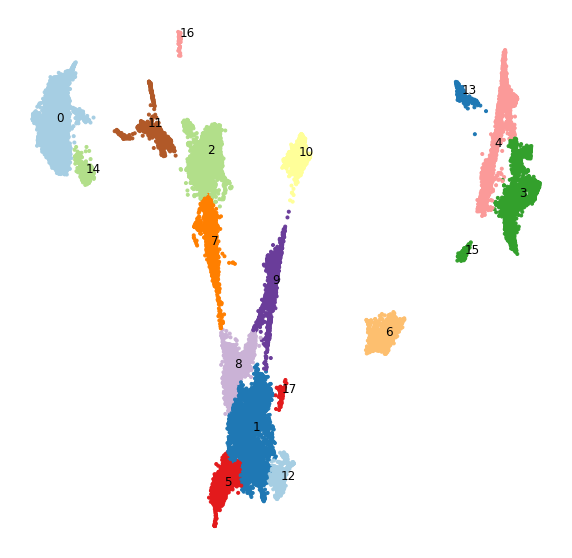

In [158]:
mosna.plot_clusters(embed_viz, cluster_labels, cluster_params=cluster_params)

In [147]:
# proportion of cells in niches per sample
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize='obs')
counts

niches          0         1         2         3         4         5   \
variable                                                               
reg001    0.238278  0.242890  0.172944  0.000000  0.001537  0.000769   
reg002    0.299914  0.083477  0.159639  0.000000  0.000000  0.000861   
reg005    0.125000  0.008929  0.419643  0.000000  0.000000  0.000000   
reg006    0.295191  0.185738  0.260365  0.000000  0.000000  0.001658   
reg009    0.151671  0.167952  0.061268  0.002142  0.415167  0.000428   
...            ...       ...       ...       ...       ...       ...   
reg046    0.194307  0.250000  0.011139  0.004950  0.000000  0.016089   
reg051    0.103512  0.196858  0.131238  0.392791  0.002773  0.000000   
reg052    0.076743  0.147042  0.057996  0.574107  0.056825  0.000000   
reg057    0.162093  0.198113  0.039451  0.000000  0.000858  0.006003   
reg058    0.149407  0.046926  0.037217  0.000000  0.001618  0.000000   

niches          6         7         8         9         10        11  \
variable                                                               
reg001    0.075327  0.073021  0.033820  0.061491  0.004612  0.066872   
reg002    0.012048  0.096816  0.234079  0.043460  0.004733  0.047762   
reg005    0.017857  0.000000  0.044643  0.348214  0.026786  0.008929   
reg006    0.008292  0.023217  0.096186  0.084577  0.003317  0.014925   
reg009    0.021851  0.022708  0.003428  0.073693  0.012425  0.010283   
...            ...       ...       ...       ...       ...       ...   
reg046    0.037129  0.123762  0.047030  0.047030  0.061881  0.018564   
reg051    0.001848  0.012015  0.001848  0.007394  0.087800  0.033272   
reg052    0.001757  0.018161  0.004101  0.005272  0.014060  0.024019   
reg057    0.060034  0.056604  0.246141  0.124357  0.060034  0.013722   
reg058    0.017260  0.028047  0.293959  0.102481  0.050701  0.010787   

niches          12        13        14        15        16        17  
variable                                                              
reg001    0.000000  0.000000  0.026902  0.000000  0.001537  0.000000  
reg002    0.001721  0.000000  0.012048  0.000000  0.000000  0.003442  
reg005    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
reg006    0.000000  0.000000  0.026534  0.000000  0.000000  0.000000  
reg009    0.001285  0.000000  0.033847  0.000857  0.000428  0.020566  
...            ...       ...       ...       ...       ...       ...  
reg046    0.000000  0.148515  0.025990  0.000000  0.012376  0.001238  
reg051    0.003697  0.000000  0.020333  0.001848  0.000000  0.002773  
reg052    0.000000  0.000000  0.019332  0.000000  0.000000  0.000586  
reg057    0.000000  0.000000  0.025729  0.003431  0.002573  0.000858  
reg058    0.000000  0.000000  0.022654  0.230852  0.008091  0.000000  

[29 rows x 18 columns]

In [148]:
# merge clinical data and proportion of cells in niches per sample
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()

In [149]:
counts_clinic

0         1         2         3         4         5  \
Patients Groups                                                               
1        1       0.269096  0.163183  0.166291  0.000000  0.000769  0.000815   
2        1       0.210095  0.097333  0.340004  0.000000  0.000000  0.000829   
3        2       0.139033  0.173316  0.077588  0.001833  0.406568  0.000214   
4        2       0.101246  0.082147  0.115535  0.004331  0.299507  0.000283   
5        1       0.024358  0.005572  0.034070  0.012122  0.004171  0.000000   
6        2       0.219416  0.126800  0.143711  0.000000  0.002325  0.159572   
7        2       0.071687  0.007363  0.485111  0.000000  0.000000  0.001946   
8        2       0.107294  0.113951  0.056207  0.034313  0.007829  0.304481   
9        1       0.112464  0.288906  0.200127  0.215749  0.002027  0.000244   
10       1       0.246082  0.095088  0.170558  0.141666  0.149721  0.000000   
11       1       0.140224  0.120291  0.269272  0.187724  0.016742  0.000000   
12       2       0.163768  0.231322  0.019153  0.006916  0.000522  0.011963   
13       1       0.090127  0.171950  0.094617  0.483449  0.029799  0.000000   
14       2       0.155750  0.122519  0.038334  0.000000  0.001238  0.003002   

                        6         7         8         9        10        11  \
Patients Groups                                                               
1        1       0.043687  0.084918  0.133950  0.052475  0.004673  0.057317   
2        1       0.013075  0.011609  0.070414  0.216396  0.015051  0.011927   
3        2       0.021078  0.023537  0.003237  0.064258  0.020933  0.015294   
4        2       0.013098  0.003385  0.000000  0.001748  0.060862  0.007116   
5        1       0.879056  0.004872  0.004872  0.017890  0.000896  0.006159   
6        2       0.136767  0.071181  0.004059  0.005386  0.053511  0.017988   
7        2       0.000000  0.000000  0.000000  0.001946  0.060581  0.352329   
8        2       0.007627  0.148038  0.006208  0.001392  0.066297  0.102963   
9        1       0.042621  0.002757  0.013308  0.083416  0.004045  0.021861   
10       1       0.000000  0.036391  0.004233  0.101732  0.020398  0.011552   
11       1       0.000452  0.033760  0.004466  0.008086  0.153558  0.043210   
12       2       0.035806  0.072331  0.057475  0.044152  0.045570  0.014768   
13       1       0.001803  0.015088  0.002975  0.006333  0.050930  0.028645   
14       2       0.038647  0.042326  0.270050  0.113419  0.055368  0.012255   

                       12        13        14        15        16        17  
Patients Groups                                                              
1        1       0.000861  0.000000  0.019475  0.000000  0.000769  0.001721  
2        1       0.000000  0.000000  0.013267  0.000000  0.000000  0.000000  
3        2       0.001658  0.000000  0.032152  0.001190  0.000214  0.017897  
4        2       0.303296  0.000000  0.005243  0.000000  0.001071  0.001133  
5        1       0.000000  0.000000  0.005963  0.000000  0.000000  0.000000  
6        2       0.015304  0.000000  0.017814  0.002457  0.020364  0.003345  
7        2       0.000000  0.000000  0.001946  0.000000  0.007782  0.009309  
8        2       0.000477  0.023695  0.001522  0.000175  0.012038  0.005492  
9        1       0.000244  0.000000  0.007046  0.000244  0.000000  0.004941  
10       1       0.005543  0.000000  0.016658  0.000380  0.000000  0.000000  
11       1       0.000000  0.000000  0.015996  0.004466  0.000000  0.001751  
12       2       0.001306  0.259210  0.023183  0.001045  0.010107  0.001403  
13       1       0.001848  0.000000  0.019832  0.000924  0.000000  0.001679  
14       2       0.000000  0.000000  0.024191  0.117141  0.005332  0.000429

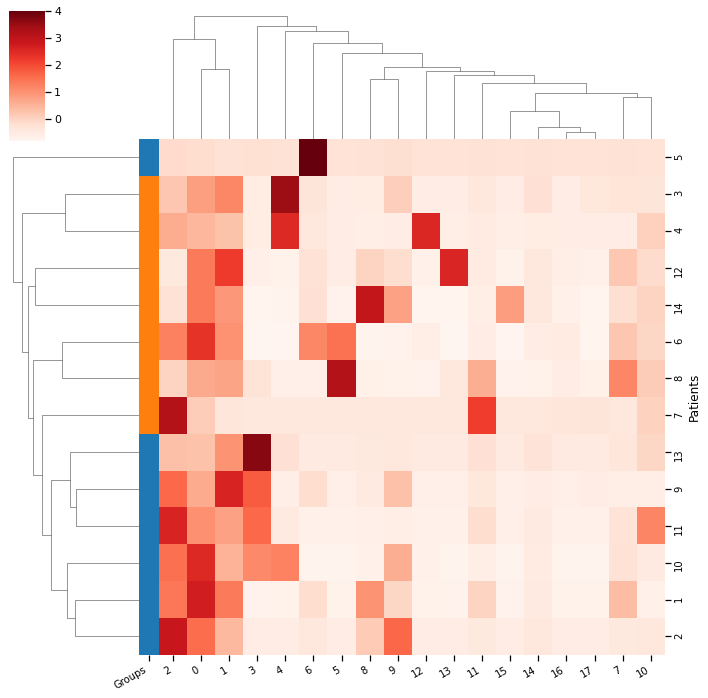

In [173]:
g, d =mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

figname = f"resolution-{cluster_params['resolution_parameter']}{other_str}_biclustering_normalized-obs.png"
plt.savefig(cluster_dir / figname)

In [174]:
# proportion of cells in niches per sample, normalized per niche total count
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize='niche')
counts

niches          0         1         2         3         4         5   \
variable                                                               
reg001    0.051727  0.059611  0.054387  0.000000  0.000617  0.000397   
reg002    0.116302  0.036597  0.089679  0.000000  0.000000  0.000794   
reg005    0.002336  0.000189  0.011361  0.000000  0.000000  0.000000   
reg006    0.029701  0.021128  0.037950  0.000000  0.000000  0.000397   
reg009    0.059069  0.073948  0.034566  0.001524  0.299074  0.000397   
...            ...       ...       ...       ...       ...       ...   
reg046    0.026197  0.038106  0.002175  0.001219  0.000000  0.005163   
reg051    0.018688  0.040181  0.034324  0.129534  0.000926  0.000000   
reg052    0.021859  0.047350  0.023930  0.298689  0.029938  0.000000   
reg057    0.031537  0.043577  0.011119  0.000000  0.000309  0.002780   
reg058    0.046221  0.016412  0.016679  0.000000  0.000926  0.000000   

niches          6         7         8         9         10        11  \
variable                                                               
reg001    0.043750  0.048919  0.024499  0.052390  0.004071  0.070331   
reg002    0.012500  0.115860  0.302895  0.066143  0.007463  0.089733   
reg005    0.000893  0.000000  0.002784  0.025540  0.002035  0.000808   
reg006    0.002232  0.007209  0.032294  0.033399  0.001357  0.007276   
reg009    0.022768  0.027291  0.004454  0.112639  0.019674  0.019402   
...            ...       ...       ...       ...       ...       ...   
reg046    0.013393  0.051493  0.021158  0.024885  0.033921  0.012126   
reg051    0.000893  0.006694  0.001114  0.005239  0.064450  0.029103   
reg052    0.001339  0.015963  0.003898  0.005894  0.016282  0.033145   
reg057    0.031250  0.033986  0.159800  0.094957  0.047490  0.012935   
reg058    0.014286  0.026777  0.303452  0.124427  0.063772  0.016168   

niches          12       13        14        15        16        17  
variable                                                             
reg001    0.000000  0.00000  0.058043  0.000000  0.010101  0.000000  
reg002    0.003902  0.00000  0.046434  0.000000  0.000000  0.049383  
reg005    0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  
reg006    0.000000  0.00000  0.026534  0.000000  0.000000  0.000000  
reg009    0.002927  0.00000  0.131012  0.004292  0.005051  0.296296  
...            ...      ...       ...       ...       ...       ...  
reg046    0.000000  0.12973  0.034826  0.000000  0.050505  0.006173  
reg051    0.003902  0.00000  0.036484  0.004292  0.000000  0.018519  
reg052    0.000000  0.00000  0.054726  0.000000  0.000000  0.006173  
reg057    0.000000  0.00000  0.049751  0.008584  0.015152  0.006173  
reg058    0.000000  0.00000  0.069652  0.918455  0.075758  0.000000  

[29 rows x 18 columns]

In [175]:
# merge clinical data and proportion of cells in niches per sample
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()

In [176]:
counts_clinic

0         1         2         3         4         5  \
Patients Groups                                                               
1        1       0.084015  0.048104  0.072033  0.000000  0.000309  0.000596   
2        1       0.016019  0.010658  0.024656  0.000000  0.000000  0.000199   
3        2       0.050309  0.070175  0.039642  0.001219  0.270525  0.000199   
4        2       0.025363  0.025844  0.043026  0.001676  0.137654  0.000199   
5        1       0.002086  0.000566  0.003988  0.001829  0.000617  0.000000   
6        2       0.088186  0.058291  0.083273  0.000000  0.001698  0.150715   
7        2       0.002419  0.000283  0.022359  0.000000  0.000000  0.000199   
8        2       0.033094  0.027416  0.020063  0.019913  0.004630  0.227164   
9        1       0.017604  0.071590  0.042905  0.130753  0.000926  0.000199   
10       1       0.052311  0.022732  0.052091  0.054404  0.059259  0.000000   
11       1       0.018522  0.019430  0.035533  0.062938  0.005710  0.000000   
12       2       0.034373  0.057442  0.007372  0.003200  0.000309  0.005560   
13       1       0.020274  0.043765  0.029127  0.214112  0.015432  0.000000   
14       2       0.038879  0.029994  0.013899  0.000000  0.000617  0.001390   

                        6         7         8         9        10        11  \
Patients Groups                                                               
1        1       0.028125  0.082389  0.163697  0.059267  0.005767  0.080032   
2        1       0.001562  0.003605  0.017539  0.029470  0.001696  0.004042   
3        2       0.020312  0.026004  0.003898  0.091683  0.029512  0.025869   
4        2       0.008929  0.002575  0.000000  0.001637  0.063094  0.008892   
5        1       0.199777  0.001287  0.001392  0.005894  0.000339  0.002425   
6        2       0.147098  0.088054  0.005290  0.008513  0.086499  0.034762   
7        2       0.000000  0.000000  0.000000  0.000327  0.009498  0.058610   
8        2       0.006399  0.116203  0.005382  0.001746  0.069199  0.119105   
9        1       0.039062  0.002317  0.013920  0.056647  0.001696  0.016572   
10       1       0.000000  0.023944  0.003062  0.085134  0.017639  0.011722   
11       1       0.000223  0.017765  0.002227  0.005239  0.048507  0.018189   
12       2       0.021429  0.036045  0.046771  0.038310  0.035957  0.014551   
13       1       0.001116  0.011329  0.002506  0.005566  0.040366  0.031124   
14       2       0.022768  0.030381  0.231626  0.109692  0.055631  0.014551   

                       12        13        14        15        16        17  
Patients Groups                                                              
1        1       0.001951  0.000000  0.052239  0.000000  0.005051  0.024691  
2        1       0.000000  0.000000  0.013267  0.000000  0.000000  0.000000  
3        2       0.003415  0.000000  0.115257  0.005365  0.002525  0.240741  
4        2       0.444878  0.000000  0.012438  0.000000  0.007576  0.012346  
5        1       0.000000  0.000000  0.004975  0.000000  0.000000  0.000000  
6        2       0.037073  0.000000  0.070481  0.012876  0.247475  0.049383  
7        2       0.000000  0.000000  0.000829  0.000000  0.010101  0.012346  
8        2       0.000650  0.034955  0.004422  0.000715  0.079125  0.061728  
9        1       0.000488  0.000000  0.012438  0.001073  0.000000  0.033951  
10       1       0.006829  0.000000  0.034826  0.001073  0.000000  0.000000  
11       1       0.000000  0.000000  0.021559  0.008584  0.000000  0.006173  
12       2       0.002439  0.447568  0.049751  0.004292  0.063131  0.012346  
13       1       0.001951  0.000000  0.045605  0.002146  0.000000  0.012346  
14       2       0.000000  0.000000  0.059701  0.463519  0.045455  0.003086

In [177]:
counts_clinic.sum(axis=0)

0     0.483453
1     0.486292
2     0.489969
3     0.490044
4     0.497685
5     0.386418
6     0.496801
7     0.441898
8     0.497309
9     0.499127
10    0.465400
11    0.440447
12    0.499675
13    0.482523
14    0.497789
15    0.499642
16    0.460438
17    0.469136
dtype: float64

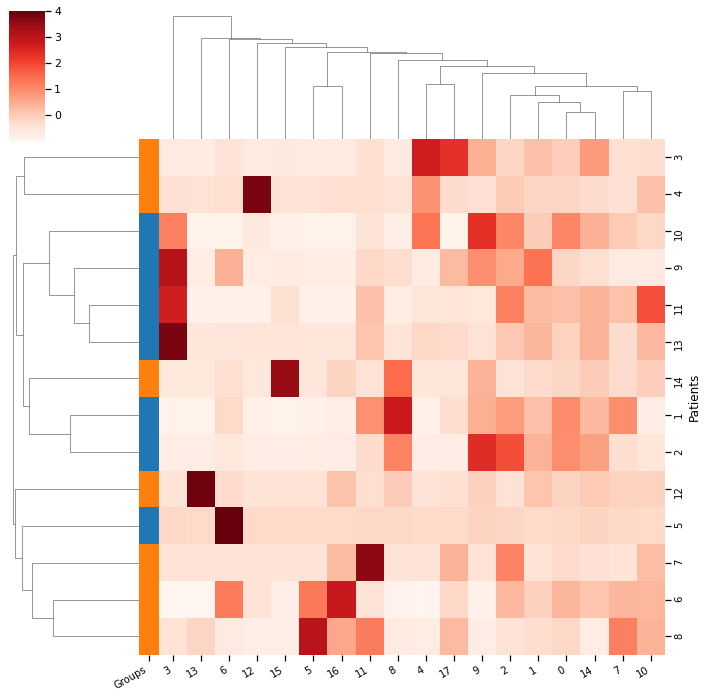

In [178]:
g, d = mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

figname = f"resolution-{cluster_params['resolution_parameter']}{other_str}_biclustering_normalized-niche.png"
plt.savefig(cluster_dir / figname)

Text(0.5, 1.0, 'niche cell-types composition, normalized by niche')

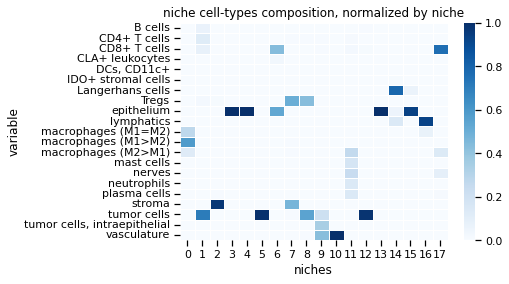

In [179]:
# mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types')
# plt.title("niche cell-types composition, normalized by total # cells")
mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='niche')
plt.title("niche cell-types composition, normalized by niche")
# mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='obs')
# plt.title("niche cell-types composition, normalized by cell-type")

That look just great, but even if the idea that we should also somehow take into account proportions per niche for normalization sounds correct, it doesn't seem right to ignore proportions per patient. For example if we normalize by the total number of cells we obtain again a very different result:

In [180]:
# proportion of cells in niches per sample, normalized per total count
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize='total')
counts

niches          0         1         2         3         4         5   \
variable                                                               
reg001    0.008144  0.008302  0.005911  0.000000  0.000053  0.000026   
reg002    0.018311  0.005097  0.009746  0.000000  0.000000  0.000053   
reg005    0.000368  0.000026  0.001235  0.000000  0.000000  0.000000   
reg006    0.004676  0.002942  0.004125  0.000000  0.000000  0.000026   
reg009    0.009300  0.010298  0.003757  0.000131  0.025456  0.000026   
...            ...       ...       ...       ...       ...       ...   
reg046    0.004125  0.005307  0.000236  0.000105  0.000000  0.000342   
reg051    0.002942  0.005596  0.003730  0.011165  0.000079  0.000000   
reg052    0.003441  0.006594  0.002601  0.025745  0.002548  0.000000   
reg057    0.004965  0.006069  0.001208  0.000000  0.000026  0.000184   
reg058    0.007277  0.002286  0.001813  0.000000  0.000079  0.000000   

niches          6         7         8         9         10        11  \
variable                                                               
reg001    0.002575  0.002496  0.001156  0.002102  0.000158  0.002286   
reg002    0.000736  0.005911  0.014291  0.002653  0.000289  0.002916   
reg005    0.000053  0.000000  0.000131  0.001025  0.000079  0.000026   
reg006    0.000131  0.000368  0.001524  0.001340  0.000053  0.000236   
reg009    0.001340  0.001392  0.000210  0.004519  0.000762  0.000631   
...            ...       ...       ...       ...       ...       ...   
reg046    0.000788  0.002627  0.000998  0.000998  0.001314  0.000394   
reg051    0.000053  0.000342  0.000053  0.000210  0.002496  0.000946   
reg052    0.000079  0.000814  0.000184  0.000236  0.000631  0.001077   
reg057    0.001839  0.001734  0.007540  0.003809  0.001839  0.000420   
reg058    0.000841  0.001366  0.014318  0.004991  0.002469  0.000525   

niches          12        13        14        15        16        17  
variable                                                              
reg001    0.000000  0.000000  0.000919  0.000000  0.000053  0.000000  
reg002    0.000105  0.000000  0.000736  0.000000  0.000000  0.000210  
reg005    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
reg006    0.000000  0.000000  0.000420  0.000000  0.000000  0.000000  
reg009    0.000079  0.000000  0.002075  0.000053  0.000026  0.001261  
...            ...       ...       ...       ...       ...       ...  
reg046    0.000000  0.003153  0.000552  0.000000  0.000263  0.000026  
reg051    0.000105  0.000000  0.000578  0.000053  0.000000  0.000079  
reg052    0.000000  0.000000  0.000867  0.000000  0.000000  0.000026  
reg057    0.000000  0.000000  0.000788  0.000105  0.000079  0.000026  
reg058    0.000000  0.000000  0.001103  0.011244  0.000394  0.000000  

[29 rows x 18 columns]

In [181]:
# merge clinical data and proportion of cells in niches per sample
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()

In [182]:
counts_clinic

0         1         2         3         4         5  \
Patients Groups                                                               
1        1       0.013227  0.006699  0.007829  0.000000  0.000026  0.000039   
2        1       0.002522  0.001484  0.002680  0.000000  0.000000  0.000013   
3        2       0.007921  0.009773  0.004308  0.000105  0.023026  0.000013   
4        2       0.003993  0.003599  0.004676  0.000144  0.011717  0.000013   
5        1       0.000328  0.000079  0.000433  0.000158  0.000053  0.000000   
6        2       0.013884  0.008118  0.009050  0.000000  0.000144  0.009970   
7        2       0.000381  0.000039  0.002430  0.000000  0.000000  0.000013   
8        2       0.005210  0.003818  0.002180  0.001716  0.000394  0.015027   
9        1       0.002772  0.009970  0.004663  0.011270  0.000079  0.000013   
10       1       0.008236  0.003166  0.005661  0.004689  0.005044  0.000000   
11       1       0.002916  0.002706  0.003862  0.005425  0.000486  0.000000   
12       2       0.005412  0.007999  0.000801  0.000276  0.000026  0.000368   
13       1       0.003192  0.006095  0.003166  0.018455  0.001314  0.000000   
14       2       0.006121  0.004177  0.001511  0.000000  0.000053  0.000092   

                        6         7         8         9        10        11  \
Patients Groups                                                               
1        1       0.001655  0.004203  0.007724  0.002378  0.000223  0.002601   
2        1       0.000092  0.000184  0.000828  0.001182  0.000066  0.000131   
3        2       0.001195  0.001327  0.000184  0.003678  0.001143  0.000841   
4        2       0.000525  0.000131  0.000000  0.000066  0.002443  0.000289   
5        1       0.011756  0.000066  0.000066  0.000236  0.000013  0.000079   
6        2       0.008656  0.004492  0.000250  0.000342  0.003350  0.001130   
7        2       0.000000  0.000000  0.000000  0.000013  0.000368  0.001905   
8        2       0.000377  0.005928  0.000254  0.000070  0.002680  0.003871   
9        1       0.002299  0.000118  0.000657  0.002272  0.000066  0.000539   
10       1       0.000000  0.001222  0.000144  0.003415  0.000683  0.000381   
11       1       0.000013  0.000906  0.000105  0.000210  0.001878  0.000591   
12       2       0.001261  0.001839  0.002207  0.001537  0.001392  0.000473   
13       1       0.000066  0.000578  0.000118  0.000223  0.001563  0.001011   
14       2       0.001340  0.001550  0.010929  0.004400  0.002154  0.000473   

                       12        13        14        15        16        17  
Patients Groups                                                              
1        1       0.000053  0.000000  0.000828  0.000000  0.000026  0.000105  
2        1       0.000000  0.000000  0.000210  0.000000  0.000000  0.000000  
3        2       0.000092  0.000000  0.001826  0.000066  0.000013  0.001025  
4        2       0.011980  0.000000  0.000197  0.000000  0.000039  0.000053  
5        1       0.000000  0.000000  0.000079  0.000000  0.000000  0.000000  
6        2       0.000998  0.000000  0.001117  0.000158  0.001287  0.000210  
7        2       0.000000  0.000000  0.000013  0.000000  0.000053  0.000053  
8        2       0.000018  0.000849  0.000070  0.000009  0.000412  0.000263  
9        1       0.000013  0.000000  0.000197  0.000013  0.000000  0.000144  
10       1       0.000184  0.000000  0.000552  0.000013  0.000000  0.000000  
11       1       0.000000  0.000000  0.000342  0.000105  0.000000  0.000026  
12       2       0.000066  0.010876  0.000788  0.000053  0.000328  0.000053  
13       1       0.000053  0.000000  0.000722  0.000026  0.000000  0.000053  
14       2       0.000000  0.000000  0.000946  0.005675  0.000236  0.000013

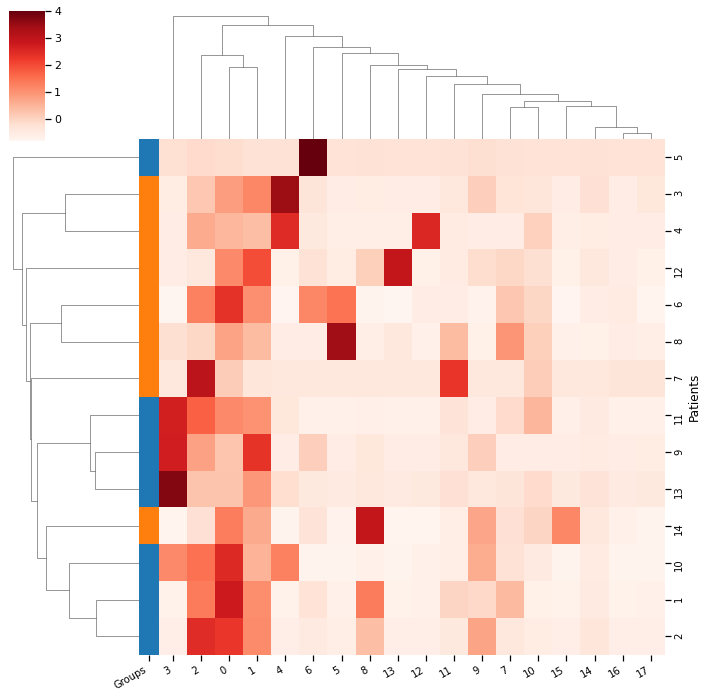

In [184]:
g, d =mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

figname = f"resolution-{cluster_params['resolution_parameter']}{other_str}_biclustering_normalized-total.png"
plt.savefig(cluster_dir / figname)

A more statistically sound way to take jointly into account proportions per variable and per observation is the Central Log Ratio, that we already applied to protein composition:

In [185]:
# proportion of cells in niches per sample, normalized with Central Log Ratio
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize='clr')
counts

niches          0         1         2         3         4         5   \
variable                                                               
reg001    4.487353  4.506523  4.166881 -5.834587 -0.556072 -1.249219   
reg002    4.932069  3.653142  4.301486 -6.200084 -6.200084 -0.921569   
reg005    4.433486  1.794428  5.644576 -2.790939 -2.790939 -2.790939   
reg006    5.139412  4.676128  5.013875 -4.627739 -4.627739 -0.042371   
reg009    2.957600  3.059565  2.051147 -1.302259  3.964567 -2.911697   
...            ...       ...       ...       ...       ...       ...   
reg046    3.123296  3.375318  0.264275 -0.546655 -6.518317  0.632000   
reg051    3.114755  3.757548  3.352083  4.448345 -0.505132 -6.189112   
reg052    3.619916  4.270172  3.339839  5.632271  3.319430 -5.840649   
reg057    3.314849  3.515520  1.901743 -6.512266 -1.926898  0.019012   
reg058    3.873769  2.715660  2.483858 -6.335616 -0.651636 -6.335616   

niches          6         7         8         9         10        11  \
variable                                                               
reg001    3.335748  3.304658  2.534970  3.132807  0.542540  3.216689   
reg002    1.717488  3.801384  4.684233  3.000404  0.783179  3.094814   
reg005    2.487576 -2.790939  3.403866  5.457990  2.893041  1.794428   
reg006    1.567067  2.596686  4.018072  3.889455  0.650776  2.154853   
reg009    1.020128  1.058595 -0.832256  2.235797  0.455599  0.266357   
...            ...       ...       ...       ...       ...       ...   
reg046    1.468248  2.672221  1.704637  1.704637  1.979073  0.775101   
reg051   -0.910597  0.961205 -0.910597  0.475697  2.950133  1.979775   
reg052   -0.156669  2.178706  0.690629  0.941943  1.922773  2.458291   
reg057    2.321597  2.262757  3.732584  3.049836  2.321597  0.845691   
reg058    1.715488  2.200996  4.550538  3.496776  2.793047  1.245484   

niches          12        13        14        15        16        17  
variable                                                              
reg001   -5.834587 -5.834587  2.306129 -5.834587 -0.556072 -5.834587  
reg002   -0.228422 -6.200084  1.717488 -6.200084 -6.200084  0.464725  
reg005   -2.790939 -2.790939 -2.790939 -2.790939 -2.790939 -2.790939  
reg006   -4.627739 -4.627739  2.730218 -4.627739 -4.627739 -4.627739  
reg009   -1.813085 -7.497065  1.457751 -2.218550 -2.911697  0.959504  
...            ...       ...       ...       ...       ...       ...  
reg046   -6.518317  2.854542  1.111573 -6.518317  0.369636 -1.932950  
reg051   -0.217450 -6.189112  1.487298 -0.910597 -6.189112 -0.505132  
reg052   -5.840649 -5.840649  2.241226 -5.840649 -5.840649 -1.255281  
reg057   -6.512266 -6.512266  1.474299 -0.540604 -0.828286 -1.926898  
reg058   -6.335616 -6.335616  1.987421  4.308875  0.957802 -6.335616  

[29 rows x 18 columns]

In [186]:
# merge clinical data and proportion of cells in niches per sample
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()

In [187]:
counts_clinic

0         1         2         3         4         5  \
Patients Groups                                                               
1        1       4.709711  4.079832  4.234183 -6.017335 -3.378078 -1.085394   
2        1       4.786449  3.235278  5.329225 -3.709339 -3.709339 -1.416655   
3        2       3.060523  3.284595  2.458749 -1.278826  4.137485 -4.925535   
4        2       3.745875  3.309193  3.875648 -2.366848  4.825989 -3.565796   
5        1       3.017820  1.317221  3.231542  2.290176  1.061808 -4.072865   
6        2       3.428415  2.786507  3.003251 -7.422767 -1.248372  3.055464   
7        2       4.324976  2.048038  6.222188 -2.883903 -2.883903 -0.591219   
8        2       2.488410  2.296509  2.005034  0.615781 -4.175148  3.336321   
9        1       3.645428  4.771651  4.157127  3.599711 -0.208283 -3.305686   
10       1       4.519810  3.567691  4.141836  3.940317  3.993377 -5.808283   
11       1       3.884978  3.689907  4.363388  2.388023 -1.109714 -5.207856   
12       2       2.583682  2.943468  0.359162 -0.605319 -4.661183 -0.078573   
13       1       3.367335  4.013860  3.345961  5.040308  1.407149 -6.014880   
14       2       3.594309  3.115590  2.192801 -6.423941 -1.289267 -3.158302   

                        6         7         8         9        10        11  \
Patients Groups                                                               
1        1       2.526618  3.553021  3.609602  3.066606  0.662860  3.155751   
2        1       2.027321 -0.097126  3.710969  4.673722  1.771908  1.974641   
3        2       1.177501  1.287895 -0.697251  2.281961  1.081018  0.800615   
4        2       1.702209  0.336326 -5.858480 -0.377232  3.238170  1.086137   
5        1       6.608981  1.408382  1.408382  2.709727 -1.780182  1.552223   
6        2       2.955289  2.304196 -1.074219 -0.284427  1.981254  0.913970   
7        2      -2.883903 -2.883903 -2.883903 -0.591219  3.983638  5.913345   
8        2      -0.385828  2.993825 -0.119659 -3.266943  2.214765  2.510396   
9        1      -0.723293  0.026719  1.269172  3.434813 -2.500967  2.007126   
10       1      -5.808283  2.599544  0.222270  3.627280  2.028479  1.400596   
11       1      -2.915173  2.021645  0.350466  0.731536  3.523284  2.470616   
12       2       1.080353  1.431952  1.537488  1.288444  1.253615  0.161214   
13       1      -0.533633  1.569956 -0.109984  0.708820  2.436453  2.219033   
14       2       2.018542  2.231876  4.141561  3.273306  2.557322  1.045587   

                       12        13        14        15        16        17  
Patients Groups                                                              
1        1      -3.031504 -6.017335  2.011808 -6.017335 -3.378078 -2.684931  
2        1      -3.709339 -3.709339 -0.030361 -3.709339 -3.709339 -3.709339  
3        2      -1.390398 -7.218219  1.599045 -1.736972 -4.925535  1.003348  
4        2       4.843574 -5.858480  0.721380 -5.858480 -0.926538 -2.872649  
5        1      -4.072865 -4.072865  1.611114 -4.072865 -4.072865 -4.072865  
6        2      -2.964717 -7.422767  0.891694 -1.189481  1.052543 -0.765832  
7        2      -2.883903 -2.883903 -0.591219 -2.883903  0.101928  2.250770  
8        2      -3.915580  0.949725 -1.558822 -5.444036  0.172164 -0.716912  
9        1      -3.305686 -5.598369  0.981490 -3.305686 -5.598369  0.653100  
10       1       0.712685 -5.808283  1.803129 -3.515599 -5.808283 -5.808283  
11       1      -5.207856 -5.207856  1.704491  0.350466 -5.207856 -0.622489  
12       2      -4.203037  2.959895  0.638969 -4.314609 -0.209755 -2.165766  
13       1      -3.029049 -6.014880  1.864262 -3.375623 -6.014880 -0.880207  
14       2      -6.423941 -6.423941  1.730860  1.884136  0.064758 -4.131257

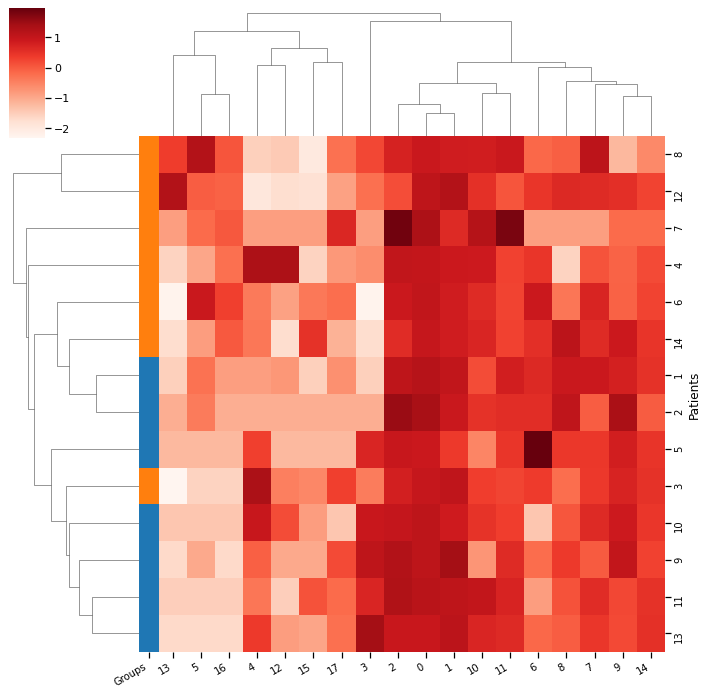

In [188]:
g, d =mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

figname = f"resolution-{cluster_params['resolution_parameter']}{other_str}_biclustering_normalized-clr.png"
plt.savefig(cluster_dir / figname)

With this more statistically sound way of normalizing data we still obtain a good, although not perfect, blind clustering of patients into responders and non responders.

In [189]:
# the colorbar is just wrong
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
s = d.style.background_gradient(cmap=cm)
s

In [190]:
pvals = mosna.find_DE_markers(counts_clinic, group_ref=2, group_tgt=1, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

In [191]:
pvals.head(20)

pval  pval_corr
16  0.008159   0.146853
8   0.053030   0.159091
1   0.053030   0.159091
2   0.053030   0.159091
3   0.053030   0.159091
11  0.053030   0.159091
5   0.212121   0.424242
14  0.212121   0.424242
9   0.212121   0.424242
15  0.575175   0.647072
13  0.575175   0.647072
12  0.575175   0.647072
0   0.575175   0.647072
6   0.575175   0.647072
4   0.575175   0.647072
10  0.575175   0.647072
17  0.962704   0.999961
7   0.999961   0.999961

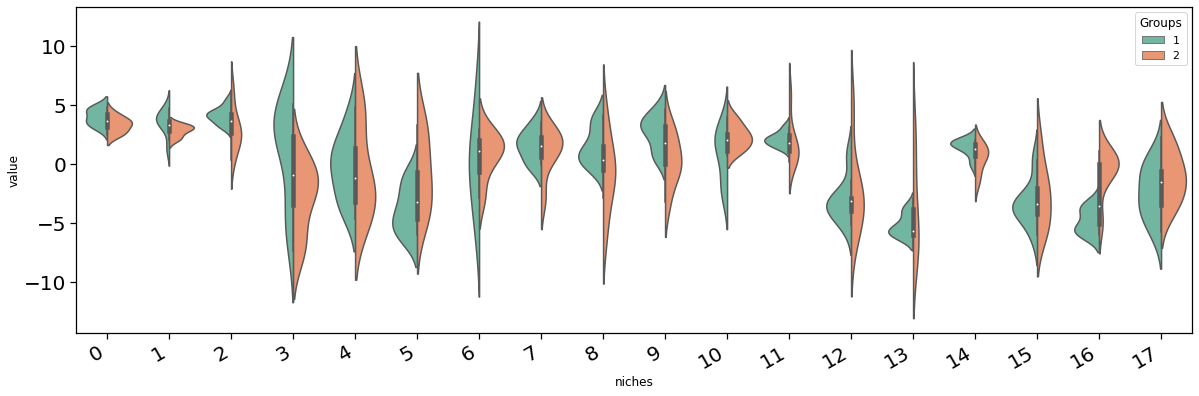

In [192]:
# DE analysis
fig, ax = mosna.plot_distrib_groups(
    counts_clinic, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=None,
    multi_ind_to_col=True,
    var_name='niches',
    )

From this plot we would like to add niches 4 and 17 to those that seggregate patients into groups 1 and 2.

Add                              16 with p-value 0.000363948
Add                               4 with p-value 0.0406529
Add                              17 with p-value 0.0424053
Add                               2 with p-value 0.0361688


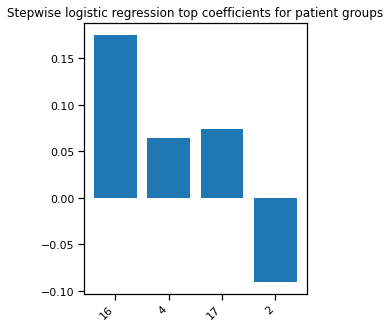

In [196]:
# Stepwise logistic regression
best_pval_names = pvals.loc[pvals['pval'] < 0.05, :].index.tolist()
if len(best_pval_names) > 0:
    model, included = mosna.stepwise_regression(X=counts_clinic, y_name='Groups', y_values=[1, 2], verbose=True)

    # plot the model's coefficients
    coefs = model.params[1:] # skip intercept
    nb_coefs = min(coefs.size, 20)
    if nb_coefs > 0:
        fig, ax = plt.subplots(figsize=(nb_coefs,5))
        ax.bar(range(len(coefs.index)), coefs)
        plt.xticks(ticks=range(len(coefs.index)), labels=coefs.index, rotation=45, ha='right');
        title = f"Stepwise logistic regression top coefficients for patient groups"
        plt.title(title)
else:
    print("There is no niche statistically related to response group")

##### Elasticnet logistic regression

In [197]:
def write_log(file, message):
    print(message)
    file.write(message + '\n')

# l1_ratio = 0 the penalty is an L2 penalty [Ridge]
# l1_ratio = 1 the penalty is an L1 penalty (Lasso)

# Test either one of those combinations
l1_ratios_list = [
    ['default', [0.5]],
    ['naive', np.linspace(0, 1, 21)],           # naive param grid
    ['advised', [.1, .5, .7, .9, .95, .99, 1]], # advised in scikit-learn documentation
]

score_labels = [
    'ROC AUC', # Receiver Operating Characteristic Area Under the Curve
    'AP',      # Average Precision
    'MCC',     # Matthews Correlation Coefficient
]
CV_TRAIN = 5
CV_ADAPT = True
CV_MAX = 10

In [198]:
X = counts_clinic.reset_index()
X = X.loc[(X.loc[:, 'Groups'] == 1) | (X.loc[:, 'Groups'] == 2), :]
y = X['Groups'].values - 1  # to have resp=0, non-resp=1
var_idx = X.iloc[:, 2:].columns
X = X.iloc[:, 2:]







-------------------------------------------
------------------- END -------------------
-------------------------------------------
Training took {duration}s


<Figure size 432x288 with 0 Axes>

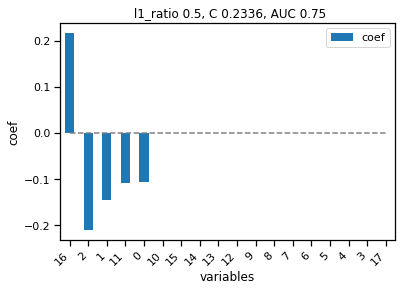

<Figure size 432x288 with 0 Axes>

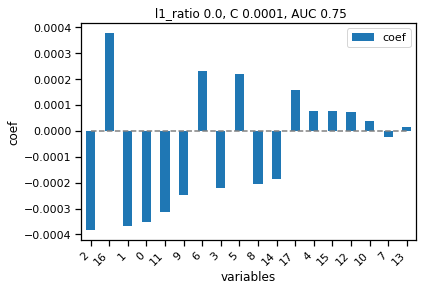

<Figure size 432x288 with 0 Axes>

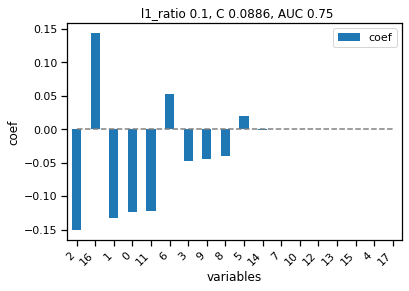

In [200]:
start = time()

for l1_name, l1_ratios in l1_ratios_list:
    dir_save = cluster_dir / "logistic_regression" / f'l1_ratios-{l1_name}'
    dir_save.mkdir(parents=True, exist_ok=True)
    log_file = open(dir_save / "training_logs.txt","a")

    score_split = {}
    # stratify train / test by response
    np.random.seed(0)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.25, 
        random_state=0, 
        shuffle=True, 
    )
    # Standardize data to give same weight to regularization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    training_succeeded = False
    cv_used = CV_TRAIN
    while not training_succeeded and cv_used <= CV_MAX:
        np.random.seed(0)
        clf = linear_model.LogisticRegressionCV(
            cv=cv_used,
            Cs=20, 
            penalty='elasticnet', 
            # scoring='neg_log_loss', 
            scoring='roc_auc', 
            solver='saga', 
            l1_ratios=l1_ratios,
            max_iter=10000,
            n_jobs=-1,  # or n_jobs-1 to leave one core available
        )
        clf = clf.fit(X_train, y_train)
        training_succeeded = not np.all(clf.coef_ == 0)
        if not training_succeeded:
            if CV_ADAPT:
                cv_used += 1
                print("        training failed, trying with cv = {cv_used}")
            else:
                print("        training failed")
                break
        
    if training_succeeded:
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        y_pred = clf.predict(X_test)
        score = {
            'ROC AUC': metrics.roc_auc_score(y_test, y_pred_proba),
            'AP' : metrics.average_precision_score(y_test, y_pred_proba),
            'MCC': metrics.matthews_corrcoef(y_test, y_pred),
        }

        # Save model coefficients and plots
        l1_ratio = np.round(clf.l1_ratio_[0], decimals=4)
        C = np.round(clf.C_[0], decimals=4)

        coef = pd.DataFrame({'coef': clf.coef_.flatten()}, index=var_idx)
        coef['abs coef'] = coef['coef'].abs()
        coef = coef.sort_values(by='abs coef', ascending=False)
        coef['% total'] = coef['abs coef'] / coef['abs coef'].sum()
        coef['cum % total'] = coef['% total'].cumsum()
        coef['coef OR'] = np.exp(coef['coef'])
        coef.to_csv(dir_save / f"LogisticRegressionCV_coefficients.csv")
        nb_coef = coef.shape[0]
        
        nb_coef_plot = min(20, nb_coef)
        labels = coef.index[:nb_coef_plot]

        plt.figure()
        ax = coef.loc[labels, 'coef'].to_frame().plot.bar()
        ax.hlines(y=0, xmin=0, xmax=nb_coef_plot-1, colors='gray', linestyles='dashed')
        ticks_pos = np.linspace(start=0, stop=nb_coef_plot-1, num=nb_coef_plot)
        # ticks_label = np.round(ticks_label, decimals=2)
        ax.set_xticks(ticks_pos);
        # ax.set_xticklabels(ticks_label)
        ax.set_xticklabels(labels, rotation=45, ha='right');
        plt.xlabel('variables')
        plt.ylabel('coef')
        plt.title(f" l1_ratio {l1_ratio}, C {C}, AUC {score['ROC AUC']}")
        plt.savefig(dir_save / f"coef.png", bbox_inches='tight', facecolor='white')

    else:
        score = {
            'ROC AUC': np.nan,
            'AP' : np.nan,
            'MCC': np.nan,
        }
        print("        training failed with cv <= {CV_MAX}")
            
    # plt.show()

    scores = pd.DataFrame.from_dict(score, orient='index')
    scores.to_csv(dir_save / 'scores_niches.csv')

end = time()
duration = end - start
print("\n"*5)
print("-------------------------------------------")
print("------------------- END -------------------")
print("-------------------------------------------")
print("Training took {duration}s")
log_file.close()

In [ ]:
save_dir = cluster_dir / (clusterer_name + "_spatial_networks_figures")
save_dir.mkdir(parents=True, exist_ok=True)

sample_ids = [
    "reg001",
    "reg003",
    "reg005",
    "reg006",
    "reg037",
    "reg040",
    "reg042",
    "reg051",
    "reg054",
    "reg055",
    "reg016",
    "reg058",
    "reg060",
    "reg019",
]

# choose colormap
if nb_clust <= 20:
    clusters_cmap = sns.color_palette('Paired', 20)
    cluster_colors = [clusters_cmap[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in cluster_labels]
else:
    clusters_cmap = cc.palette["glasbey"]
    # make color mapper
    # series to sort by decreasing order
    uniq = pd.Series(cluster_labels).value_counts().index.astype(int)
    n_colors = len(clusters_cmap)
    labels_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}
    labels_color_mapper[-1] = (0.5, 0.5, 0.5)
    cluster_colors = np.array([labels_color_mapper[x] for x in cluster_labels])

# colormap for cell-types
n_cell_types = obj['ClusterName'].unique().size
# palette = sns.color_palette(cc.glasbey, n_colors=n_cell_types).as_hex()
palette = [mpl.colors.rgb2hex(x) for x in mpl.cm.get_cmap('tab20').colors]

plots_marker = '.'
for sample in sample_ids:
    print("filename: {}".format(sample))
    select = np.array(obj['FileName'] == sample)

    # load nodes and edges
    coords = obj.loc[select, cell_pos_cols].values
    pairs = edges_all.loc[edges_all['filename'] == sample, ['source', 'target']].values

    # Big summary plot
    fig, ax = plt.subplots(1, 4, figsize=(int(7*4)+1, 7), tight_layout=False)
    i = 0
    ty.plot_network(coords, pairs, labels=obj.loc[select, 'ClusterName'], cmap_nodes=palette, marker=plots_marker, size_nodes=size_points, ax=ax[0])
    ax[i].set_title('Spatial map of phenotypes', fontsize=14);

    i += 1
    ax[i].scatter(coords[:, 0], coords[:, 1], c=cluster_colors[select], marker=plots_marker, s=size_points)
    ax[i].set_title('Spatial map of detected areas', fontsize=14);
    ax[i].set_aspect('equal')

    i += 1
    ax[i].scatter(embed_viz[select, 0], embed_viz[select, 1], c=cluster_colors[select], s=5);
    ax[i].set_title("HDBSCAN clustering on NAS", fontsize=14);
    ax[i].set_aspect('equal')

    i += 1
    ax[i].scatter(embed_viz[:, 0], embed_viz[:, 1], c=cluster_colors);
    ax[i].set_title("HDBSCAN clustering on NAS of all samples", fontsize=14);
    ax[i].set_aspect('equal')
    
    # make plot limits equal
    ax[i-1].set_xlim(ax[i].get_xlim())
    ax[i-1].set_ylim(ax[i].get_ylim())

    suptitle = f"Spatial omics data and detected areas - sample {sample}";
    fig.suptitle(suptitle, fontsize=18)

    fig.savefig(save_dir / suptitle, bbox_inches='tight', facecolor='white', dpi=300)

#### Explore different clustering wrt survival

In [ ]:
# for dim_clust in tqdm([2, 3, 4, 5], leave=False):
for dim_clust in tqdm([2], leave=False):
    for n_neighbors in tqdm([15, 45, 75, 100, 200], leave=False):
        for metric in tqdm(['euclidean', 'cosine'], leave=False):
            for k_cluster in tqdm([15, 50], leave=False):
                for resolution_parameter in [0.005, 0.01, 0.05, 0.1, 0.5]:
                    cluster_params = {
                        'reducer_type': 'umap', 
                        'n_neighbors': n_neighbors, 
                        'metric': metric,
                        'min_dist': 0.0,
                        'clusterer_type': 'leiden', 
                        'dim_clust': dim_clust, 
                        'k_cluster': 15, 
                        'resolution_parameter': resolution_parameter,
                    }

                    cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)

                    # Survival analysis (just heatmap for now)
                    niches = cluster_labels
                    for normalize in ['total', 'niche', 'obs', 'clr']:
                        counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize=normalize)
                        # merge clinical data and proportion of cells in niches per sample
                        # counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
                        counts_clinic = pd.concat([status, counts], axis=1, join='inner').fillna(0)
                        # counts_clinic.drop(columns=['Spots'], inplace=True)
                        counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()

                        # plot heatmap
                        g, d = mosna.plot_heatmap(
                            counts_clinic.reset_index(), 
                            obs_labels='Patients', 
                            group_var='Groups', 
                            groups=[1, 2],
                            figsize=(10, 10),
                            z_score=False,
                            cmap=sns.color_palette("Reds", as_cmap=True),
                            return_data=True,
                            )
                        # str_params = '_'.join([str(key) + '-' + str(val) for key, val in cluster_params.items()])
                        figname = f"biclustering_resolution-{resolution_parameter}_normalized-{normalize}.png"
                        plt.savefig(cluster_dir / figname, dpi=150)

## Final parameters

```
reducer-umap_dim-2_nneigh-200_metric-euclidean_min_dist-0.0/clusterer-leiden_n_neighbors-15/biclustering_resolution-0.05_normalized-niche  
reducer-umap_dim-2_nneigh-75_metric-euclidean_min_dist-0.0/clusterer-leiden_n_neighbors-15/biclustering_resolution-0.05_normalized-clr  
reducer-umap_dim-2_nneigh-75_metric-euclidean_min_dist-0.0/clusterer-leiden_n_neighbors-15/biclustering_resolution-0.05_normalized-obs
```

In [66]:
cluster_params = {
    'reducer_type': 'umap', 
    'n_neighbors': 75, 
    'metric': 'euclidean', 
    'min_dist': 0.0,
    'clusterer_type': 'leiden', 
    'dim_clust': 2, 
    'k_cluster': 15, 
    'resolution_parameter': 0.05,
}

cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)

Loading clusterer object and cluster labels
There are 17 clusters


In [67]:
nas_dir

PosixPath('../data/processed/CODEX_CTCL/pretreatment_samples_networks_xy_trim_dist-200_solitary-0/nas_on-markers_stats-mean-std_order-1')

Loading reducer object and reduced coordinates


(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

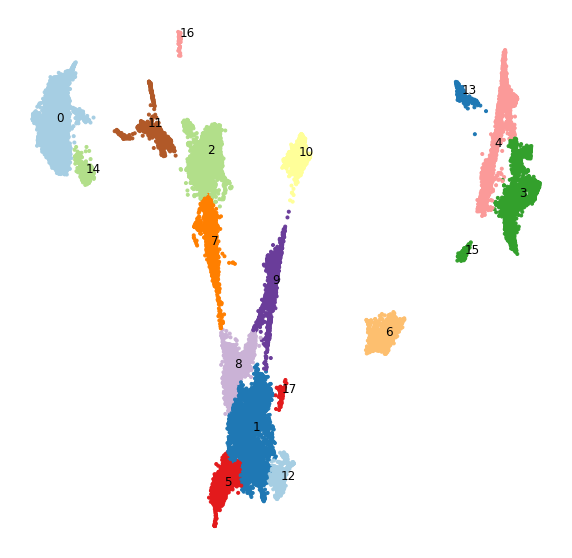

In [68]:
embed_viz, _ = mosna.get_reducer(var_aggreg, nas_dir, reducer_type='umap', n_neighbors=cluster_params['n_neighbors'])
mosna.plot_clusters(embed_viz, cluster_labels, nas_dir, cluster_params=cluster_params)

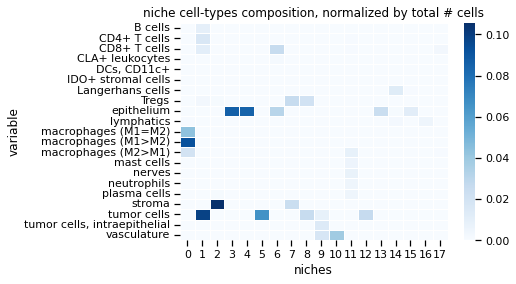

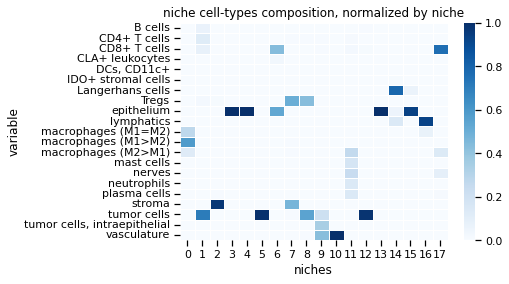

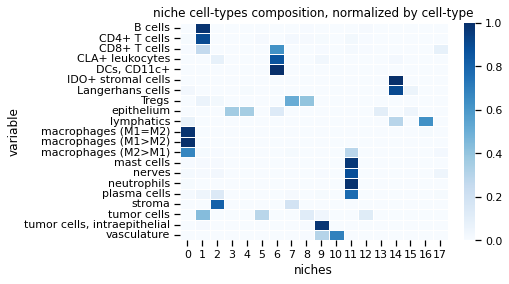

In [70]:
# Survival analysis

cell_types = nodes_all['CellCluster']
niches = cluster_labels

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types')
title = "niche cell-types composition, normalized by total # cells"
plt.title(title)
plt.savefig(cluster_dir / title, bbox_inches='tight', facecolor='white')

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='niche')
title = "niche cell-types composition, normalized by niche"
plt.title(title)
plt.savefig(cluster_dir / title, bbox_inches='tight', facecolor='white')

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='obs')
title = "niche cell-types composition, normalized by cell-type"
plt.title(title)
plt.savefig(cluster_dir / title, bbox_inches='tight', facecolor='white')

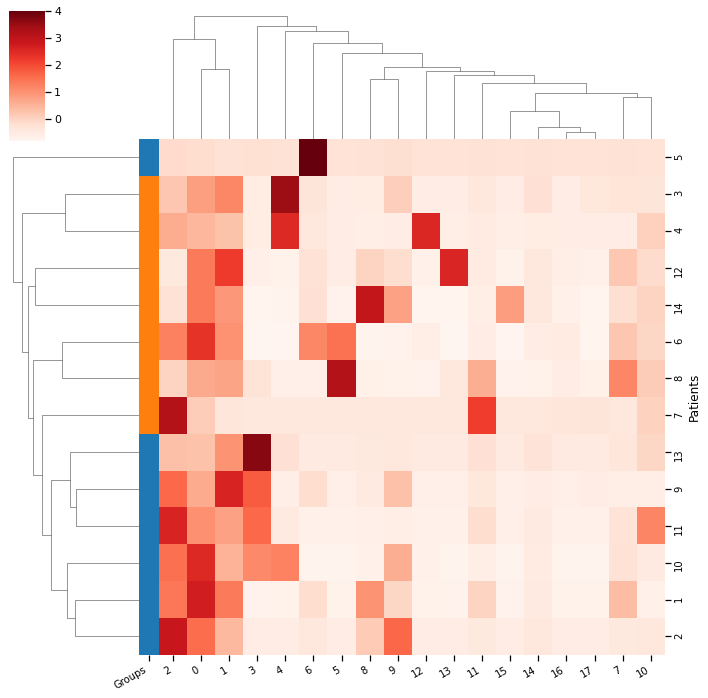

In [81]:
# proportion of cells in niches per sample
other_str = ''
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize='obs')
# merge clinical data and proportion of cells in niches per sample
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()
# heatmap
g, d =mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

figname = f"resolution-{cluster_params['resolution_parameter']}{other_str}_biclustering_normalized-obs.png"
plt.savefig(cluster_dir / figname)

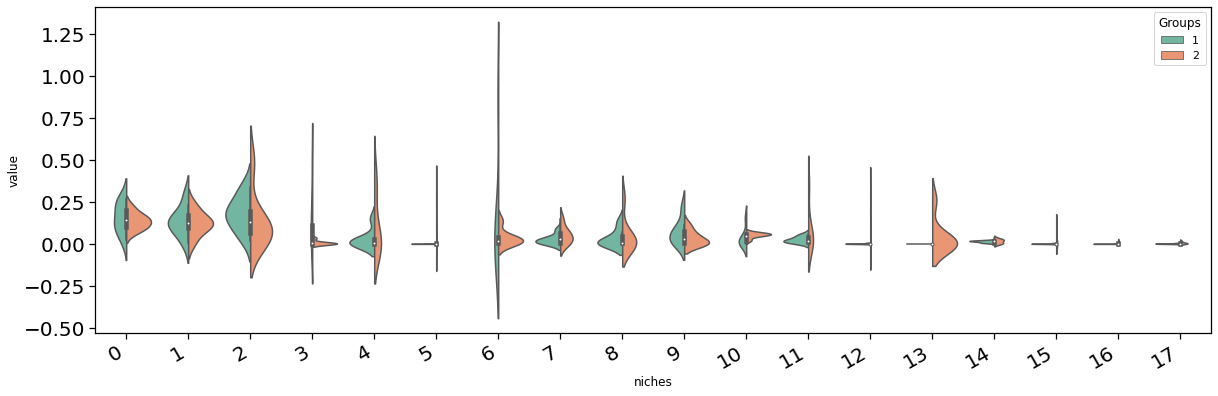

In [82]:
pvals = mosna.find_DE_markers(counts_clinic, group_ref=2, group_tgt=1, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

# DE analysis
fig, ax = mosna.plot_distrib_groups(
    counts_clinic, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=None,
    multi_ind_to_col=True,
    var_name='niches',
    )

Add                              16 with p-value 0.0100267
Add                               4 with p-value 0.00839606


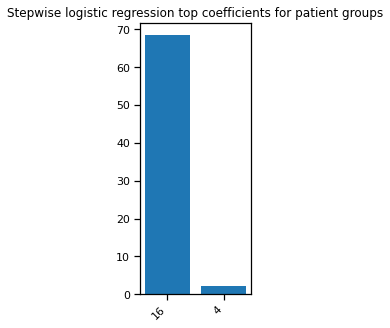

In [83]:
# Stepwise logistic regression
best_pval_names = pvals.loc[pvals['pval'] < 0.05, :].index.tolist()
if len(best_pval_names) > 0:
    model, included = mosna.stepwise_regression(X=counts_clinic, y_name='Groups', y_values=[1, 2], verbose=True)

    # plot the model's coefficients
    coefs = model.params[1:] # skip intercept
    nb_coefs = min(coefs.size, 20)
    if nb_coefs > 0:
        fig, ax = plt.subplots(figsize=(nb_coefs,5))
        ax.bar(range(len(coefs.index)), coefs)
        plt.xticks(ticks=range(len(coefs.index)), labels=coefs.index, rotation=45, ha='right');
        title = f"Stepwise logistic regression top coefficients for patient groups"
        plt.title(title)
else:
    print("There is no niche statistically related to response group")







-------------------------------------------
------------------- END -------------------
-------------------------------------------
Training took {duration}s


<Figure size 432x288 with 0 Axes>

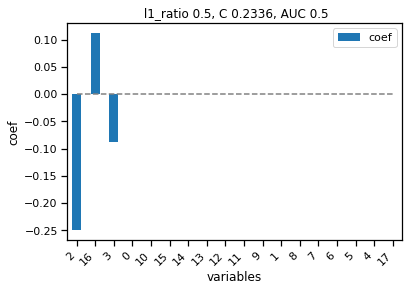

<Figure size 432x288 with 0 Axes>

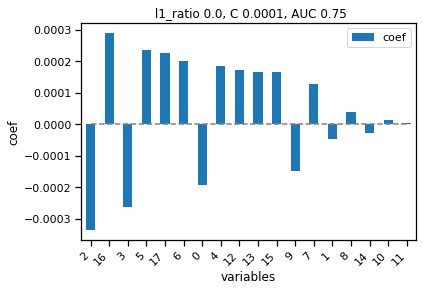

<Figure size 432x288 with 0 Axes>

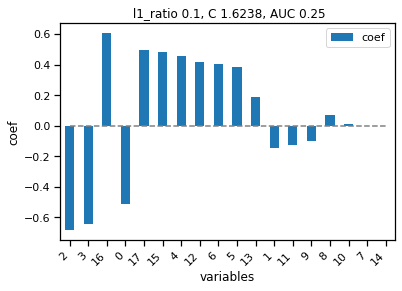

In [84]:
# Elasticnet logistic regression

def write_log(file, message):
    print(message)
    file.write(message + '\n')

# l1_ratio = 0 the penalty is an L2 penalty [Ridge]
# l1_ratio = 1 the penalty is an L1 penalty (Lasso)

# Test either one of those combinations
l1_ratios_list = [
    ['default', [0.5]],
    ['naive', np.linspace(0, 1, 21)],           # naive param grid
    ['advised', [.1, .5, .7, .9, .95, .99, 1]], # advised in scikit-learn documentation
]

score_labels = [
    'ROC AUC', # Receiver Operating Characteristic Area Under the Curve
    'AP',      # Average Precision
    'MCC',     # Matthews Correlation Coefficient
]
CV_TRAIN = 5
CV_ADAPT = True
CV_MAX = 10


# /!\ not related to `X = obj[aggreg_vars].values`
X = counts_clinic.reset_index()
X = X.loc[(X.loc[:, 'Groups'] == 1) | (X.loc[:, 'Groups'] == 2), :]
y = X['Groups'].values - 1  # to have resp=0, non-resp=1
var_idx = X.iloc[:, 2:].columns
X = X.iloc[:, 2:]

start = time()

for l1_name, l1_ratios in l1_ratios_list:
    dir_save = cluster_dir / "logistic_regression" / f'l1_ratios-{l1_name}'
    dir_save.mkdir(parents=True, exist_ok=True)
    log_file = open(dir_save / "training_logs.txt","a")

    score_split = {}
    # stratify train / test by response
    np.random.seed(0)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.25, 
        random_state=0, 
        shuffle=True, 
    )
    # Standardize data to give same weight to regularization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    training_succeeded = False
    cv_used = CV_TRAIN
    while not training_succeeded and cv_used <= CV_MAX:
        np.random.seed(0)
        clf = linear_model.LogisticRegressionCV(
            cv=cv_used,
            Cs=20, 
            penalty='elasticnet', 
            # scoring='neg_log_loss', 
            scoring='roc_auc', 
            solver='saga', 
            l1_ratios=l1_ratios,
            max_iter=10000,
            n_jobs=-1,  # or n_jobs-1 to leave one core available
        )
        clf = clf.fit(X_train, y_train)
        training_succeeded = not np.all(clf.coef_ == 0)
        if not training_succeeded:
            if CV_ADAPT:
                cv_used += 1
                print("        training failed, trying with cv = {cv_used}")
            else:
                print("        training failed")
                break
        
    if training_succeeded:
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        y_pred = clf.predict(X_test)
        score = {
            'ROC AUC': metrics.roc_auc_score(y_test, y_pred_proba),
            'AP' : metrics.average_precision_score(y_test, y_pred_proba),
            'MCC': metrics.matthews_corrcoef(y_test, y_pred),
        }

        # Save model coefficients and plots
        l1_ratio = np.round(clf.l1_ratio_[0], decimals=4)
        C = np.round(clf.C_[0], decimals=4)

        coef = pd.DataFrame({'coef': clf.coef_.flatten()}, index=var_idx)
        coef['abs coef'] = coef['coef'].abs()
        coef = coef.sort_values(by='abs coef', ascending=False)
        coef['% total'] = coef['abs coef'] / coef['abs coef'].sum()
        coef['cum % total'] = coef['% total'].cumsum()
        coef['coef OR'] = np.exp(coef['coef'])
        coef.to_csv(dir_save / f"LogisticRegressionCV_coefficients.csv")
        nb_coef = coef.shape[0]
        
        nb_coef_plot = min(20, nb_coef)
        labels = coef.index[:nb_coef_plot]

        plt.figure()
        ax = coef.loc[labels, 'coef'].to_frame().plot.bar()
        ax.hlines(y=0, xmin=0, xmax=nb_coef_plot-1, colors='gray', linestyles='dashed')
        ticks_pos = np.linspace(start=0, stop=nb_coef_plot-1, num=nb_coef_plot)
        # ticks_label = np.round(ticks_label, decimals=2)
        ax.set_xticks(ticks_pos);
        # ax.set_xticklabels(ticks_label)
        ax.set_xticklabels(labels, rotation=45, ha='right');
        plt.xlabel('variables')
        plt.ylabel('coef')
        plt.title(f" l1_ratio {l1_ratio}, C {C}, AUC {score['ROC AUC']}")
        plt.savefig(dir_save / f"coef.png", bbox_inches='tight', facecolor='white')

    else:
        score = {
            'ROC AUC': np.nan,
            'AP' : np.nan,
            'MCC': np.nan,
        }
        print("        training failed with cv <= {CV_MAX}")
            
    # plt.show()

    scores = pd.DataFrame.from_dict(score, orient='index')
    scores.to_csv(dir_save / 'scores_niches.csv')

end = time()
duration = end - start
print("\n"*5)
print("-------------------------------------------")
print("------------------- END -------------------")
print("-------------------------------------------")
print("Training took {duration}s")
log_file.close()

Text(0.5, 1.0, 'niche cell-types composition, normalized by niche')

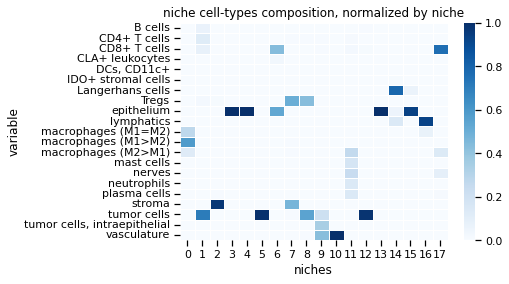

In [85]:
# as a reminder:
mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='niche')
plt.title("niche cell-types composition, normalized by niche")

Ok not so interesting...

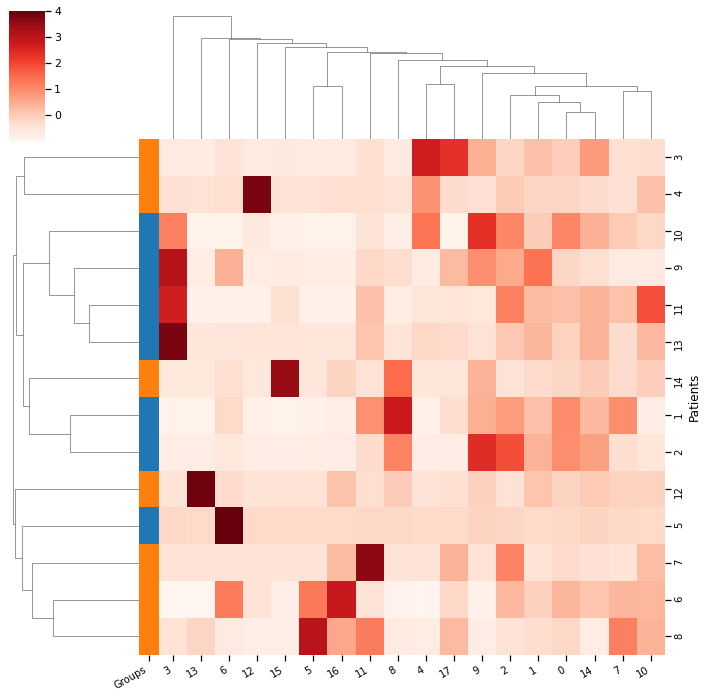

In [73]:
# proportion of cells in niches per sample, normalized per niche total count
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize='niche')
# merge clinical data and proportion of cells
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()
# heatmap
g, d = mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

figname = f"resolution-{cluster_params['resolution_parameter']}{other_str}_biclustering_normalized-niche.png"
plt.savefig(cluster_dir / figname)

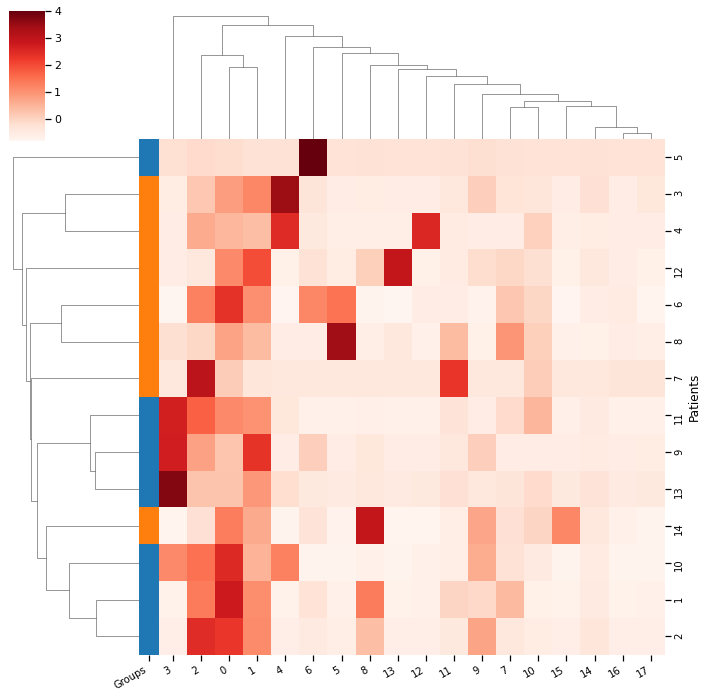

In [74]:
# proportion of cells in niches per sample, normalized per total count
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize='total')
# merge clinical data and proportion of cells in niches per sample
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()
# heatmap
g, d =mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

figname = f"resolution-{cluster_params['resolution_parameter']}{other_str}_biclustering_normalized-total.png"
plt.savefig(cluster_dir / figname)


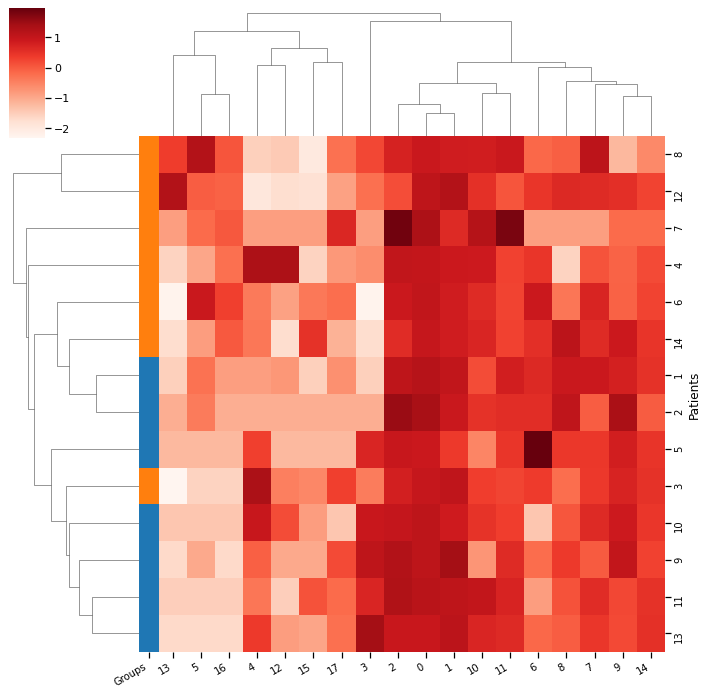

In [75]:
# proportion of cells in niches per sample, normalized with Central Log Ratio
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize='clr')
# merge clinical data and proportion of cells in niches per sample
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()
# heatmap
g, d =mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

figname = f"resolution-{cluster_params['resolution_parameter']}{other_str}_biclustering_normalized-clr.png"
plt.savefig(cluster_dir / figname)

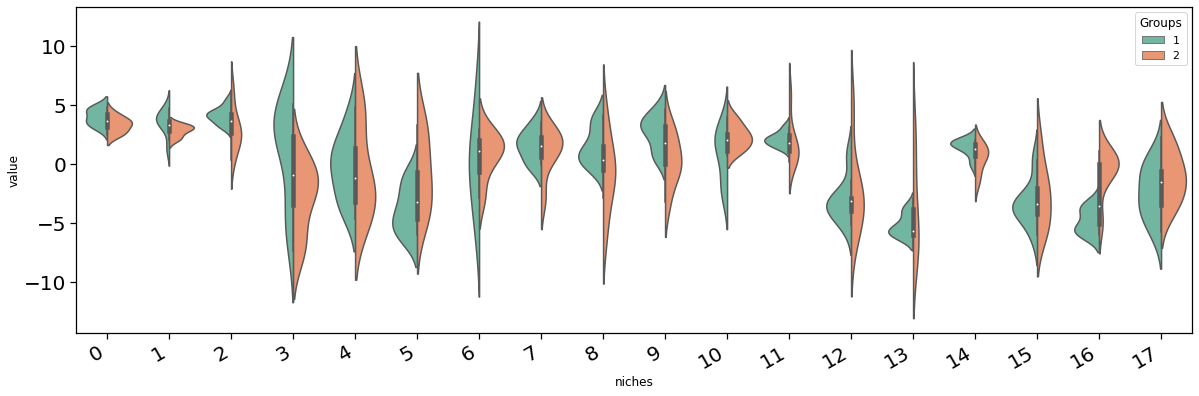

In [76]:
pvals = mosna.find_DE_markers(counts_clinic, group_ref=2, group_tgt=1, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

# DE analysis
fig, ax = mosna.plot_distrib_groups(
    counts_clinic, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=None,
    multi_ind_to_col=True,
    var_name='niches',
    )

Add                              16 with p-value 0.000363948
Add                               4 with p-value 0.0406529
Add                              17 with p-value 0.0424053
Add                               2 with p-value 0.0361688


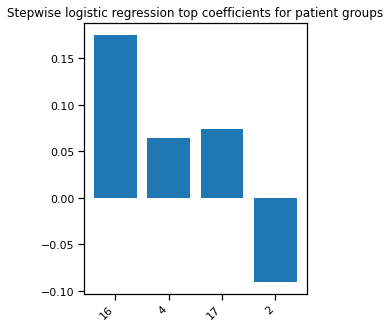

In [77]:
# Stepwise logistic regression
best_pval_names = pvals.loc[pvals['pval'] < 0.05, :].index.tolist()
if len(best_pval_names) > 0:
    model, included = mosna.stepwise_regression(X=counts_clinic, y_name='Groups', y_values=[1, 2], verbose=True)

    # plot the model's coefficients
    coefs = model.params[1:] # skip intercept
    nb_coefs = min(coefs.size, 20)
    if nb_coefs > 0:
        fig, ax = plt.subplots(figsize=(nb_coefs,5))
        ax.bar(range(len(coefs.index)), coefs)
        plt.xticks(ticks=range(len(coefs.index)), labels=coefs.index, rotation=45, ha='right');
        title = f"Stepwise logistic regression top coefficients for patient groups"
        plt.title(title)
else:
    print("There is no niche statistically related to response group")







-------------------------------------------
------------------- END -------------------
-------------------------------------------
Training took {duration}s


<Figure size 432x288 with 0 Axes>

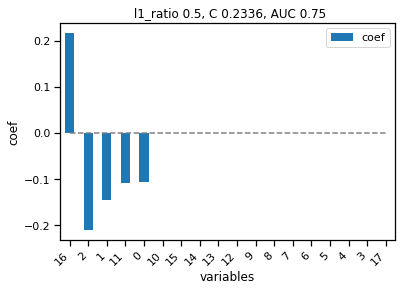

<Figure size 432x288 with 0 Axes>

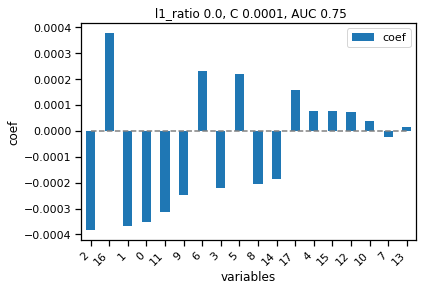

<Figure size 432x288 with 0 Axes>

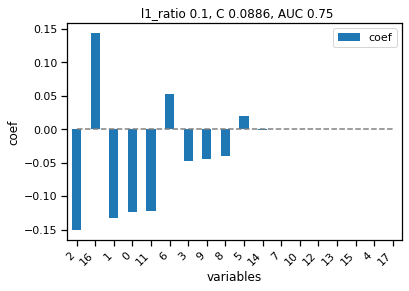

In [79]:
# Elasticnet logistic regression

def write_log(file, message):
    print(message)
    file.write(message + '\n')

# l1_ratio = 0 the penalty is an L2 penalty [Ridge]
# l1_ratio = 1 the penalty is an L1 penalty (Lasso)

# Test either one of those combinations
l1_ratios_list = [
    ['default', [0.5]],
    ['naive', np.linspace(0, 1, 21)],           # naive param grid
    ['advised', [.1, .5, .7, .9, .95, .99, 1]], # advised in scikit-learn documentation
]

score_labels = [
    'ROC AUC', # Receiver Operating Characteristic Area Under the Curve
    'AP',      # Average Precision
    'MCC',     # Matthews Correlation Coefficient
]
CV_TRAIN = 5
CV_ADAPT = True
CV_MAX = 10


# /!\ not related to `X = obj[aggreg_vars].values`
X = counts_clinic.reset_index()
X = X.loc[(X.loc[:, 'Groups'] == 1) | (X.loc[:, 'Groups'] == 2), :]
y = X['Groups'].values - 1  # to have resp=0, non-resp=1
var_idx = X.iloc[:, 2:].columns
X = X.iloc[:, 2:]

start = time()

for l1_name, l1_ratios in l1_ratios_list:
    dir_save = cluster_dir / "logistic_regression" / f'l1_ratios-{l1_name}'
    dir_save.mkdir(parents=True, exist_ok=True)
    log_file = open(dir_save / "training_logs.txt","a")

    score_split = {}
    # stratify train / test by response
    np.random.seed(0)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.25, 
        random_state=0, 
        shuffle=True, 
    )
    # Standardize data to give same weight to regularization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    training_succeeded = False
    cv_used = CV_TRAIN
    while not training_succeeded and cv_used <= CV_MAX:
        np.random.seed(0)
        clf = linear_model.LogisticRegressionCV(
            cv=cv_used,
            Cs=20, 
            penalty='elasticnet', 
            # scoring='neg_log_loss', 
            scoring='roc_auc', 
            solver='saga', 
            l1_ratios=l1_ratios,
            max_iter=10000,
            n_jobs=-1,  # or n_jobs-1 to leave one core available
        )
        clf = clf.fit(X_train, y_train)
        training_succeeded = not np.all(clf.coef_ == 0)
        if not training_succeeded:
            if CV_ADAPT:
                cv_used += 1
                print("        training failed, trying with cv = {cv_used}")
            else:
                print("        training failed")
                break
        
    if training_succeeded:
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        y_pred = clf.predict(X_test)
        score = {
            'ROC AUC': metrics.roc_auc_score(y_test, y_pred_proba),
            'AP' : metrics.average_precision_score(y_test, y_pred_proba),
            'MCC': metrics.matthews_corrcoef(y_test, y_pred),
        }

        # Save model coefficients and plots
        l1_ratio = np.round(clf.l1_ratio_[0], decimals=4)
        C = np.round(clf.C_[0], decimals=4)

        coef = pd.DataFrame({'coef': clf.coef_.flatten()}, index=var_idx)
        coef['abs coef'] = coef['coef'].abs()
        coef = coef.sort_values(by='abs coef', ascending=False)
        coef['% total'] = coef['abs coef'] / coef['abs coef'].sum()
        coef['cum % total'] = coef['% total'].cumsum()
        coef['coef OR'] = np.exp(coef['coef'])
        coef.to_csv(dir_save / f"LogisticRegressionCV_coefficients.csv")
        nb_coef = coef.shape[0]
        
        nb_coef_plot = min(20, nb_coef)
        labels = coef.index[:nb_coef_plot]

        plt.figure()
        ax = coef.loc[labels, 'coef'].to_frame().plot.bar()
        ax.hlines(y=0, xmin=0, xmax=nb_coef_plot-1, colors='gray', linestyles='dashed')
        ticks_pos = np.linspace(start=0, stop=nb_coef_plot-1, num=nb_coef_plot)
        # ticks_label = np.round(ticks_label, decimals=2)
        ax.set_xticks(ticks_pos);
        # ax.set_xticklabels(ticks_label)
        ax.set_xticklabels(labels, rotation=45, ha='right');
        plt.xlabel('variables')
        plt.ylabel('coef')
        plt.title(f" l1_ratio {l1_ratio}, C {C}, AUC {score['ROC AUC']}")
        plt.savefig(dir_save / f"coef.png", bbox_inches='tight', facecolor='white')

    else:
        score = {
            'ROC AUC': np.nan,
            'AP' : np.nan,
            'MCC': np.nan,
        }
        print("        training failed with cv <= {CV_MAX}")
            
    # plt.show()

    scores = pd.DataFrame.from_dict(score, orient='index')
    scores.to_csv(dir_save / 'scores_niches.csv')

end = time()
duration = end - start
print("\n"*5)
print("-------------------------------------------")
print("------------------- END -------------------")
print("-------------------------------------------")
print("Training took {duration}s")
log_file.close()

Text(0.5, 1.0, 'niche cell-types composition, normalized by niche')

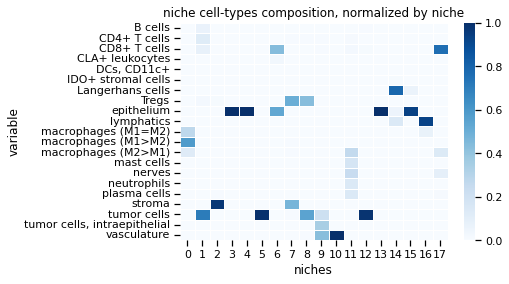

In [80]:
# as a reminder:
mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='niche')
plt.title("niche cell-types composition, normalized by niche")

Niches that matter:
  - 16: lymphatics + macrophages (M1=M2)
  - 2: stroma only
  - 1: tumor cells + B cells + CD4+ T cells + CD8+ T cells
  - 0: macrophages, all 3 definitions
Interestingly, niches of pure epithelium or *even* pure cancer cells don't matter.

In [86]:
cluster_params = {
    'reducer_type': 'umap', 
    'n_neighbors': 200, 
    'metric': 'euclidean', 
    'min_dist': 0.0,
    'clusterer_type': 'leiden', 
    'dim_clust': 2, 
    'k_cluster': 15, 
    'resolution_parameter': 0.05,
}

cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)

Loading clusterer object and cluster labels
There are 15 clusters


In [87]:
nas_dir

PosixPath('../data/processed/CODEX_CTCL/pretreatment_samples_networks_xy_trim_dist-200_solitary-0/nas_on-markers_stats-mean-std_order-1')

Loading reducer object and reduced coordinates


(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

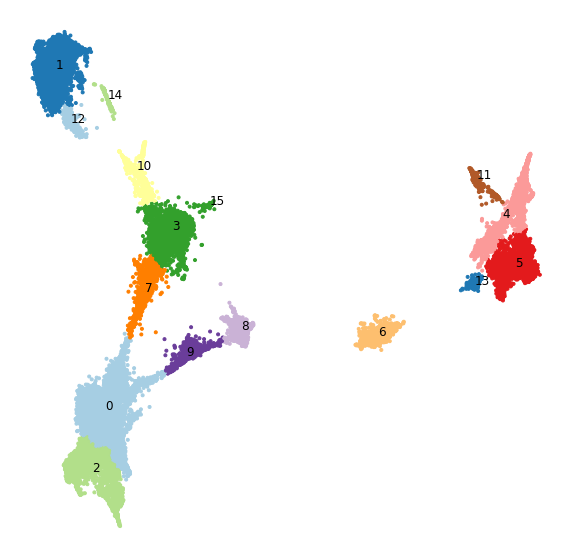

In [88]:
embed_viz, _ = mosna.get_reducer(var_aggreg, nas_dir, reducer_type='umap', n_neighbors=cluster_params['n_neighbors'])
mosna.plot_clusters(embed_viz, cluster_labels, nas_dir, cluster_params=cluster_params)

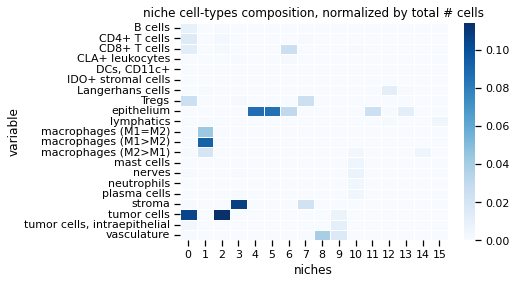

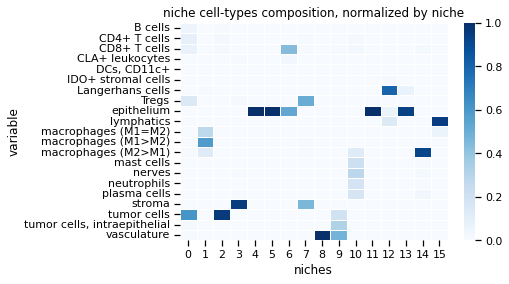

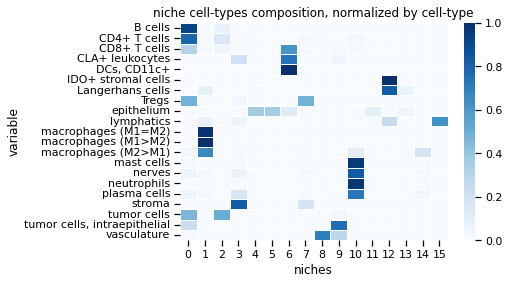

In [89]:
# Survival analysis

cell_types = nodes_all['CellCluster']
niches = cluster_labels

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types')
title = "niche cell-types composition, normalized by total # cells"
plt.title(title)
plt.savefig(cluster_dir / title, bbox_inches='tight', facecolor='white')

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='niche')
title = "niche cell-types composition, normalized by niche"
plt.title(title)
plt.savefig(cluster_dir / title, bbox_inches='tight', facecolor='white')

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='obs')
title = "niche cell-types composition, normalized by cell-type"
plt.title(title)
plt.savefig(cluster_dir / title, bbox_inches='tight', facecolor='white')

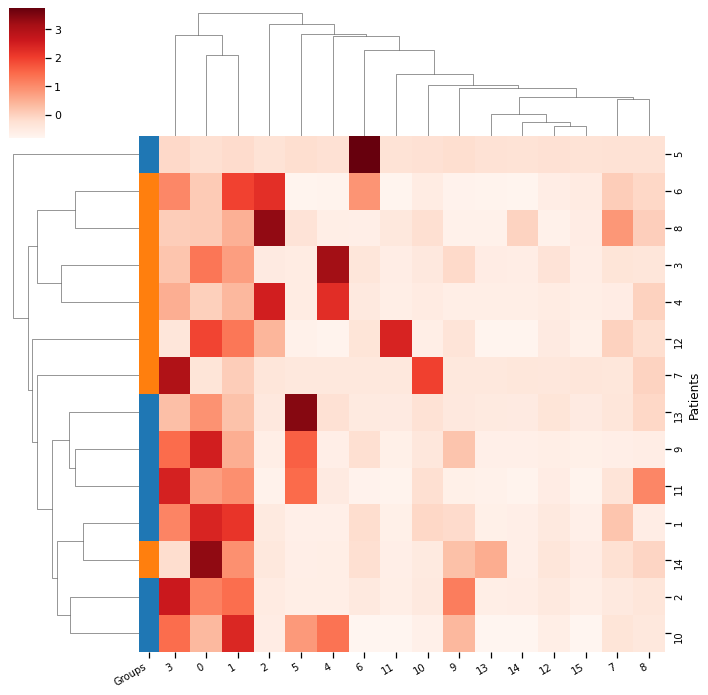

In [90]:
# proportion of cells in niches per sample
other_str = ''
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize='obs')
# merge clinical data and proportion of cells in niches per sample
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()
# heatmap
g, d =mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

figname = f"resolution-{cluster_params['resolution_parameter']}{other_str}_biclustering_normalized-obs.png"
plt.savefig(cluster_dir / figname)

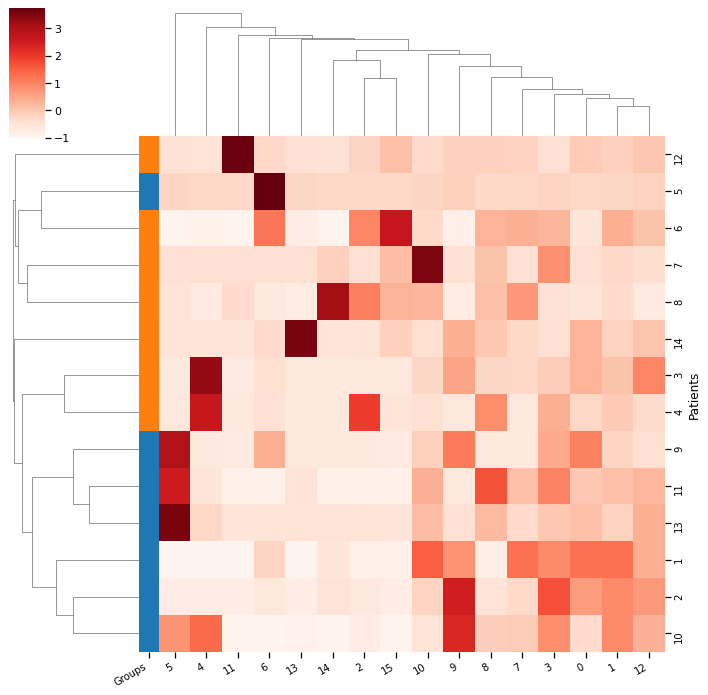

In [91]:
# proportion of cells in niches per sample, normalized per niche total count
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize='niche')
# merge clinical data and proportion of cells
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()
# heatmap
g, d = mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

figname = f"resolution-{cluster_params['resolution_parameter']}{other_str}_biclustering_normalized-niche.png"
plt.savefig(cluster_dir / figname)

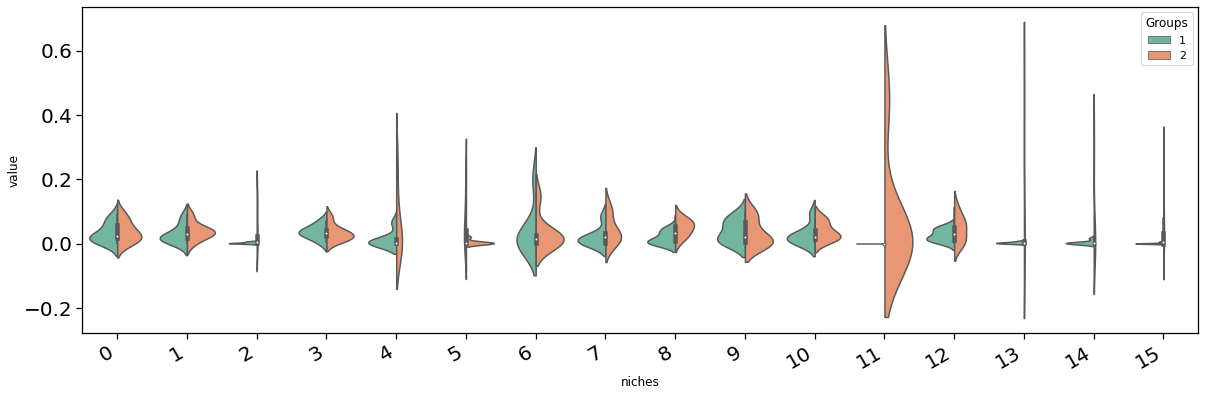

In [92]:
pvals = mosna.find_DE_markers(counts_clinic, group_ref=2, group_tgt=1, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

# DE analysis
fig, ax = mosna.plot_distrib_groups(
    counts_clinic, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=None,
    multi_ind_to_col=True,
    var_name='niches',
    )

Add                               8 with p-value 0.0250028
Add                               5 with p-value 0.0414848


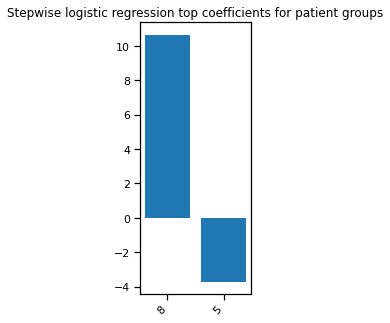

In [93]:
# Stepwise logistic regression
best_pval_names = pvals.loc[pvals['pval'] < 0.05, :].index.tolist()
if len(best_pval_names) > 0:
    model, included = mosna.stepwise_regression(X=counts_clinic, y_name='Groups', y_values=[1, 2], verbose=True)

    # plot the model's coefficients
    coefs = model.params[1:] # skip intercept
    nb_coefs = min(coefs.size, 20)
    if nb_coefs > 0:
        fig, ax = plt.subplots(figsize=(nb_coefs,5))
        ax.bar(range(len(coefs.index)), coefs)
        plt.xticks(ticks=range(len(coefs.index)), labels=coefs.index, rotation=45, ha='right');
        title = f"Stepwise logistic regression top coefficients for patient groups"
        plt.title(title)
else:
    print("There is no niche statistically related to response group")







-------------------------------------------
------------------- END -------------------
-------------------------------------------
Training took {duration}s


<Figure size 432x288 with 0 Axes>

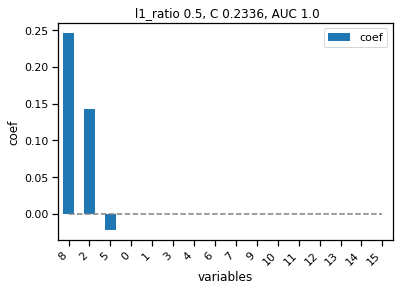

<Figure size 432x288 with 0 Axes>

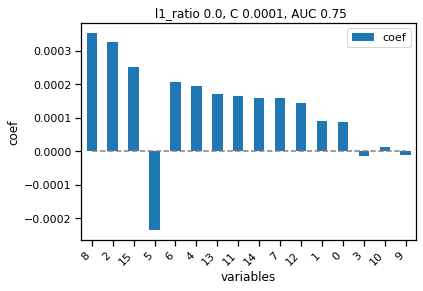

<Figure size 432x288 with 0 Axes>

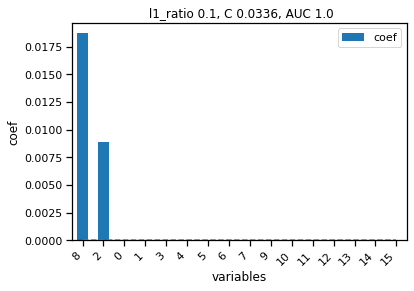

In [94]:
# Elasticnet logistic regression

def write_log(file, message):
    print(message)
    file.write(message + '\n')

# l1_ratio = 0 the penalty is an L2 penalty [Ridge]
# l1_ratio = 1 the penalty is an L1 penalty (Lasso)

# Test either one of those combinations
l1_ratios_list = [
    ['default', [0.5]],
    ['naive', np.linspace(0, 1, 21)],           # naive param grid
    ['advised', [.1, .5, .7, .9, .95, .99, 1]], # advised in scikit-learn documentation
]

score_labels = [
    'ROC AUC', # Receiver Operating Characteristic Area Under the Curve
    'AP',      # Average Precision
    'MCC',     # Matthews Correlation Coefficient
]
CV_TRAIN = 5
CV_ADAPT = True
CV_MAX = 10


# /!\ not related to `X = obj[aggreg_vars].values`
X = counts_clinic.reset_index()
X = X.loc[(X.loc[:, 'Groups'] == 1) | (X.loc[:, 'Groups'] == 2), :]
y = X['Groups'].values - 1  # to have resp=0, non-resp=1
var_idx = X.iloc[:, 2:].columns
X = X.iloc[:, 2:]

start = time()

for l1_name, l1_ratios in l1_ratios_list:
    dir_save = cluster_dir / "logistic_regression" / f'l1_ratios-{l1_name}'
    dir_save.mkdir(parents=True, exist_ok=True)
    log_file = open(dir_save / "training_logs.txt","a")

    score_split = {}
    # stratify train / test by response
    np.random.seed(0)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.25, 
        random_state=0, 
        shuffle=True, 
    )
    # Standardize data to give same weight to regularization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    training_succeeded = False
    cv_used = CV_TRAIN
    while not training_succeeded and cv_used <= CV_MAX:
        np.random.seed(0)
        clf = linear_model.LogisticRegressionCV(
            cv=cv_used,
            Cs=20, 
            penalty='elasticnet', 
            # scoring='neg_log_loss', 
            scoring='roc_auc', 
            solver='saga', 
            l1_ratios=l1_ratios,
            max_iter=10000,
            n_jobs=-1,  # or n_jobs-1 to leave one core available
        )
        clf = clf.fit(X_train, y_train)
        training_succeeded = not np.all(clf.coef_ == 0)
        if not training_succeeded:
            if CV_ADAPT:
                cv_used += 1
                print("        training failed, trying with cv = {cv_used}")
            else:
                print("        training failed")
                break
        
    if training_succeeded:
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        y_pred = clf.predict(X_test)
        score = {
            'ROC AUC': metrics.roc_auc_score(y_test, y_pred_proba),
            'AP' : metrics.average_precision_score(y_test, y_pred_proba),
            'MCC': metrics.matthews_corrcoef(y_test, y_pred),
        }

        # Save model coefficients and plots
        l1_ratio = np.round(clf.l1_ratio_[0], decimals=4)
        C = np.round(clf.C_[0], decimals=4)

        coef = pd.DataFrame({'coef': clf.coef_.flatten()}, index=var_idx)
        coef['abs coef'] = coef['coef'].abs()
        coef = coef.sort_values(by='abs coef', ascending=False)
        coef['% total'] = coef['abs coef'] / coef['abs coef'].sum()
        coef['cum % total'] = coef['% total'].cumsum()
        coef['coef OR'] = np.exp(coef['coef'])
        coef.to_csv(dir_save / f"LogisticRegressionCV_coefficients.csv")
        nb_coef = coef.shape[0]
        
        nb_coef_plot = min(20, nb_coef)
        labels = coef.index[:nb_coef_plot]

        plt.figure()
        ax = coef.loc[labels, 'coef'].to_frame().plot.bar()
        ax.hlines(y=0, xmin=0, xmax=nb_coef_plot-1, colors='gray', linestyles='dashed')
        ticks_pos = np.linspace(start=0, stop=nb_coef_plot-1, num=nb_coef_plot)
        # ticks_label = np.round(ticks_label, decimals=2)
        ax.set_xticks(ticks_pos);
        # ax.set_xticklabels(ticks_label)
        ax.set_xticklabels(labels, rotation=45, ha='right');
        plt.xlabel('variables')
        plt.ylabel('coef')
        plt.title(f" l1_ratio {l1_ratio}, C {C}, AUC {score['ROC AUC']}")
        plt.savefig(dir_save / f"coef.png", bbox_inches='tight', facecolor='white')

    else:
        score = {
            'ROC AUC': np.nan,
            'AP' : np.nan,
            'MCC': np.nan,
        }
        print("        training failed with cv <= {CV_MAX}")
            
    # plt.show()

    scores = pd.DataFrame.from_dict(score, orient='index')
    scores.to_csv(dir_save / 'scores_niches.csv')

end = time()
duration = end - start
print("\n"*5)
print("-------------------------------------------")
print("------------------- END -------------------")
print("-------------------------------------------")
print("Training took {duration}s")
log_file.close()

Text(0.5, 1.0, 'niche cell-types composition, normalized by niche')

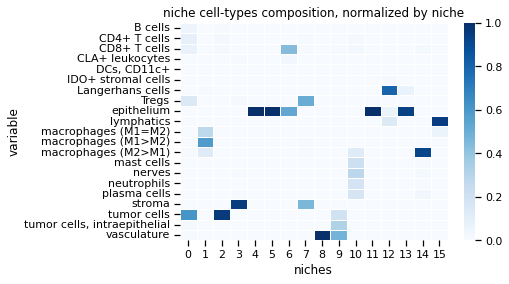

In [95]:
# as a reminder:
mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='niche')
plt.title("niche cell-types composition, normalized by niche")

Not so interesting...

In [98]:
# So we keep
cluster_params = {
    'reducer_type': 'umap', 
    'n_neighbors': 75, 
    'metric': 'euclidean', 
    'min_dist': 0.0,
    'clusterer_type': 'leiden', 
    'dim_clust': 2, 
    'k_cluster': 15, 
    'resolution_parameter': 0.05,
}